In [1]:
!pip install -e .

Obtaining file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels/_md
ERROR: file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels/_md does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# py-tidymodels imports
from py_workflows import workflow
from py_parsnip import linear_reg, rand_forest, boost_tree
from py_rsample import initial_split, training, testing
from py_yardstick import metric_set, rmse, mae, r_squared

# Recipe imports
from py_recipes import recipe
from py_recipes.selectors import (
    all_numeric, all_nominal, all_predictors, all_outcomes,
    all_numeric_predictors, all_nominal_predictors,
    contains, starts_with, ends_with, matches  # ← These are now available
)

from py_visualize import plot_forecast, plot_residuals

# Set random seed for reproducibility
np.random.seed(42)

# Recipes Demonstration Notebook

This notebook demonstrates various preprocessing techniques using py-recipes with the same forecasting data.

## Contents:
1. Data loading and splitting
2. Basic recipes
3. Feature engineering recipes
4. Model comparison with different recipes
5. Advanced recipe patterns

# 1. Import Data

In [3]:
# Import raw data
raw_data = pd.read_csv('__data/preem.csv')

# Convert date to datetime
raw_data['date'] = pd.to_datetime(raw_data['date'])
display(raw_data.head())
print(f"\nData shape: {raw_data.shape}")
print(f"Date range: {raw_data['date'].min()} to {raw_data['date'].max()}")

,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2020-04-01,-56.18,-11.43,-3.07,28.58,-16.09,26.91,0.47,137.65,0.0
1,2020-05-01,-42.36,-9.17,3.89,22.64,-8.75,20.36,0.57,113.53,0.0
2,2020-06-01,-30.21,-8.58,-3.44,13.43,-4.28,11.32,6.61,43.31,0.0
3,2020-07-01,-28.86,-6.86,-2.71,10.74,-3.20,8.53,-1.55,79.77,0.0
4,2020-08-01,-38.80,-5.86,-2.63,4.58,-5.35,6.26,-2.70,48.27,0.0



Data shape: (57, 10)
Date range: 2020-04-01 00:00:00 to 2024-12-01 00:00:00


# 2. Train/Test Split

In [4]:
# Create 75/25 train/test split
split = initial_split(raw_data, prop=0.75, seed=123)
train_data = training(split)
test_data = testing(split)

print(f"Training set: {train_data.shape[0]} rows")
print(f"Test set: {test_data.shape[0]} rows")
print(f"\nTraining date range: {train_data['date'].min()} to {train_data['date'].max()}")
print(f"Test date range: {test_data['date'].min()} to {test_data['date'].max()}")

Training set: 42 rows
Test set: 15 rows

Training date range: 2020-04-01 00:00:00 to 2023-09-01 00:00:00
Test date range: 2023-10-01 00:00:00 to 2024-12-01 00:00:00


# 3. Define Formula

Using dot notation to include all columns except target and date.

In [5]:
FORMULA_STR = "target ~ ."
print(f"Formula: {FORMULA_STR}")
print("\nThis will automatically expand to all numeric columns (excluding date)")

Formula: target ~ .

This will automatically expand to all numeric columns (excluding date)


# 4. Baseline Model (No Recipe)

First, let's fit a baseline linear regression without any preprocessing.

In [6]:
# Baseline: No preprocessing
spec_baseline = linear_reg().set_engine("sklearn")
fit_baseline = spec_baseline.fit(train_data, FORMULA_STR)
fit_baseline = fit_baseline.evaluate(test_data)

print("✓ Baseline model fitted successfully!")

# Extract outputs
outputs_baseline, coefs_baseline, stats_baseline = fit_baseline.extract_outputs()

print("\n=== Baseline Model Statistics ===")
display(stats_baseline[stats_baseline['split'] == 'test'][['metric', 'value']])

# Plot forecast
fig = plot_forecast(fit_baseline, title="Baseline Model (No Preprocessing)")
fig.show()

✓ Baseline model fitted successfully!

=== Baseline Model Statistics ===


,metric,value
7,rmse,40.693426
8,mae,33.265367
9,mape,25.063394
10,smape,30.300796
11,r_squared,-3.283181
12,mda,14.285714


# 5. Recipe Pattern 1: Normalization

Normalize numeric predictors to improve model performance.

In [7]:
# Recipe with normalization
rec_normalize = (
    recipe()
    .step_normalize(all_numeric_predictors())
)

# Workflow with recipe
wf_normalize = (
    workflow()
    .add_recipe(rec_normalize)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_normalize = wf_normalize.fit(train_data)
fit_normalize = fit_normalize.evaluate(test_data)

print("✓ Normalized model fitted successfully!")

# Extract outputs
outputs_normalize, coefs_normalize, stats_normalize = fit_normalize.extract_outputs()

print("\n=== Normalized Model Statistics ===")
display(stats_normalize[stats_normalize['split'] == 'test'][['metric', 'value']])

# Plot forecast
fig = plot_forecast(fit_normalize, title="With Normalization")
fig.show()

# Fit on training data
rec_fit = rec_normalize.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Normalized model fitted successfully!

=== Normalized Model Statistics ===


,metric,value
7,rmse,40.693426
8,mae,33.265367
9,mape,25.063394
10,smape,30.300796
11,r_squared,-3.283181
12,mda,14.285714



Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target', 'totaltar'],
      dtype='object')


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2020-04-01,-0.088770,-0.094595,0.046119,1.487556,-2.378036,2.031849,0.358746,137.65,-0.237232
1,2020-05-01,0.172544,0.089438,1.195442,0.793182,-0.956278,1.074411,0.389075,113.53,-0.237232
2,2020-06-01,0.402280,0.137482,-0.014980,-0.283450,-0.090439,-0.246999,2.220933,43.31,-0.237232
3,2020-07-01,0.427807,0.277542,0.105567,-0.597906,0.118757,-0.654823,-0.253895,79.77,-0.237232
4,2020-08-01,0.239857,0.358972,0.118778,-1.317998,-0.297698,-0.986637,-0.602676,48.27,-0.237232
5,2020-09-01,0.183889,0.378516,0.209601,-0.954445,0.107135,-1.002717,-0.420703,98.01,-0.237232
6,2020-10-01,0.141723,0.420859,0.579498,-0.907686,-0.096250,-1.053877,-0.796780,49.77,-0.237232
7,2020-11-01,0.161577,0.393987,0.850315,-0.934573,-0.694783,-0.879931,-0.551117,35.48,-0.237232
8,2020-12-01,0.187859,0.560105,0.708301,-1.072512,-0.743208,-0.992484,0.216201,63.98,-0.237232
9,2021-01-01,0.194855,0.345129,0.657110,-0.839885,-0.747082,-0.700137,0.201036,109.76,-0.237232


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2023-10-01,-0.603078,0.495775,-0.521937,-0.600244,-0.260895,-0.252846,1.486976,107.65,-0.237232
1,2023-11-01,-0.680981,0.024293,-0.589642,-0.463473,-0.853617,-0.238228,0.813678,118.37,-0.237232
2,2023-12-01,-0.685519,-0.290842,-0.553312,-0.851575,1.366184,-0.413637,-1.078838,113.03,-0.237232
3,2024-01-01,-0.589653,-0.052251,-0.350199,-0.721818,0.426739,-0.227996,0.234398,122.65,-0.237232
4,2024-02-01,-0.479418,1.820648,-0.738261,-0.322026,0.878060,0.545263,1.080571,129.09,-0.237232
5,2024-03-01,-0.467694,-0.179283,-0.578082,-0.099920,0.568140,0.080430,0.725724,145.57,0.432258
6,2024-04-01,-0.509860,1.814133,-0.802663,-0.315013,1.211224,-0.156371,0.774250,158.23,0.983528
7,2024-05-01,-0.574149,-0.285142,-0.829084,0.344293,0.637872,0.179828,0.574080,104.04,0.050824
8,2024-06-01,-0.677388,-0.042480,-0.814222,0.216874,0.064521,0.138900,-0.763419,173.23,0.983528
9,2024-07-01,-0.604402,0.142367,-0.612760,0.034513,-0.028455,-0.327394,-0.017331,126.20,1.244599


# 6. Recipe Pattern 2: Scaling

Scale features to [0, 1] range.

In [8]:
# Recipe with min-max scaling
rec_scale = (
    recipe()
    .step_range(all_numeric_predictors(), min_val=0, max_val=1)
)

# Workflow
wf_scale = (
    workflow()
    .add_recipe(rec_scale)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_scale = wf_scale.fit(train_data)
fit_scale = fit_scale.evaluate(test_data)

print("✓ Scaled model fitted successfully!")

outputs_scale, coefs_scale, stats_scale = fit_scale.extract_outputs()

print("\n=== Scaled Model Statistics ===")
display(stats_scale[stats_scale['split'] == 'test'][['metric', 'value']])

fig = plot_forecast(fit_scale, title="With Min-Max Scaling")
fig.show()

# Fit on training data
rec_fit = rec_scale.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Scaled model fitted successfully!

=== Scaled Model Statistics ===


,metric,value
7,rmse,40.693426
8,mae,33.265367
9,mape,25.063394
10,smape,30.300796
11,r_squared,-3.283181
12,mda,14.285714



Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target', 'totaltar'],
      dtype='object')


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2020-04-01,0.226830,0.363547,0.396897,0.644122,0.000000,0.690772,0.506533,137.65,0.000000
1,2020-05-01,0.291226,0.400590,0.621849,0.484702,0.321648,0.476440,0.511558,113.53,0.000000
2,2020-06-01,0.347840,0.410261,0.384939,0.237520,0.517528,0.180628,0.815075,43.31,0.000000
3,2020-07-01,0.354131,0.438453,0.408533,0.165325,0.564855,0.089332,0.405025,79.77,0.000000
4,2020-08-01,0.307814,0.454843,0.411118,0.000000,0.470640,0.015052,0.347236,48.27,0.000000
5,2020-09-01,0.294022,0.458777,0.428895,0.083468,0.562226,0.011453,0.377387,98.01,0.000000
6,2020-10-01,0.283631,0.467300,0.501293,0.094203,0.516214,0.000000,0.315075,49.77,0.000000
7,2020-11-01,0.288523,0.461891,0.554299,0.088030,0.380806,0.038940,0.355779,35.48,0.000000
8,2020-12-01,0.295000,0.495329,0.526503,0.056361,0.369851,0.013743,0.482915,63.98,0.000000
9,2021-01-01,0.296724,0.452057,0.516484,0.109769,0.368975,0.079188,0.480402,109.76,0.000000


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2023-10-01,0.100089,0.482380,0.285714,0.164788,0.478966,0.179319,0.693467,107.65,0.000000
1,2023-11-01,0.080891,0.387477,0.272463,0.196189,0.344873,0.182592,0.581910,118.37,0.000000
2,2023-12-01,0.079773,0.324045,0.279573,0.107085,0.847064,0.143325,0.268342,113.03,0.000000
3,2024-01-01,0.103397,0.372070,0.319328,0.136876,0.634531,0.184882,0.485930,122.65,0.000000
4,2024-02-01,0.130562,0.749058,0.243374,0.228663,0.736635,0.357984,0.626131,129.09,0.000000
5,2024-03-01,0.133451,0.346501,0.274725,0.279656,0.666521,0.253927,0.567337,145.57,0.109684
6,2024-04-01,0.123060,0.747746,0.230769,0.230274,0.812007,0.200916,0.575377,158.23,0.200000
7,2024-05-01,0.107218,0.325193,0.225598,0.381643,0.682296,0.276178,0.542211,104.04,0.047193
8,2024-06-01,0.081776,0.374037,0.228507,0.352389,0.552585,0.267016,0.320603,173.23,0.200000
9,2024-07-01,0.099762,0.411244,0.267938,0.310521,0.531551,0.162631,0.444221,126.20,0.242772


# 7. Recipe Pattern 3: Centering and Scaling

Combine centering (mean=0) and scaling (sd=1).

In [9]:
# Recipe with centering and scaling
rec_center_scale = (
    recipe()
    .step_center(all_numeric_predictors())
    .step_scale(all_numeric_predictors())
)

# Workflow
wf_center_scale = (
    workflow()
    .add_recipe(rec_center_scale)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_center_scale = wf_center_scale.fit(train_data)
fit_center_scale = fit_center_scale.evaluate(test_data)

print("✓ Centered and scaled model fitted successfully!")

outputs_cs, coefs_cs, stats_cs = fit_center_scale.extract_outputs()

print("\n=== Centered + Scaled Model Statistics ===")
display(stats_cs[stats_cs['split'] == 'test'][['metric', 'value']])

fig = plot_forecast(fit_center_scale, title="With Centering + Scaling")
fig.show()

# Fit on training data
rec_fit = rec_center_scale.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Centered and scaled model fitted successfully!

=== Centered + Scaled Model Statistics ===


,metric,value
7,rmse,40.693426
8,mae,33.265367
9,mape,25.063394
10,smape,30.300796
11,r_squared,-3.283181
12,mda,14.285714



Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target', 'totaltar'],
      dtype='object')


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2020-04-01,-0.087707,-0.093462,0.045567,1.469741,-2.349555,2.007514,0.354450,137.65,-0.234391
1,2020-05-01,0.170477,0.088367,1.181125,0.783682,-0.944825,1.061544,0.384415,113.53,-0.234391
2,2020-06-01,0.397462,0.135835,-0.014800,-0.280055,-0.089356,-0.244041,2.194334,43.31,-0.234391
3,2020-07-01,0.422683,0.274218,0.104303,-0.590745,0.117334,-0.646981,-0.250854,79.77,-0.234391
4,2020-08-01,0.236985,0.354673,0.117355,-1.302213,-0.294133,-0.974821,-0.595458,48.27,-0.234391
5,2020-09-01,0.181686,0.373982,0.207090,-0.943014,0.105851,-0.990708,-0.415665,98.01,-0.234391
6,2020-10-01,0.140026,0.415819,0.572557,-0.896815,-0.095098,-1.041256,-0.787238,49.77,-0.234391
7,2020-11-01,0.159642,0.389269,0.840131,-0.923380,-0.686462,-0.869392,-0.544517,35.48,-0.234391
8,2020-12-01,0.185609,0.553397,0.699818,-1.059667,-0.734307,-0.980598,0.213612,63.98,-0.234391
9,2021-01-01,0.192522,0.340996,0.649240,-0.829826,-0.738135,-0.691752,0.198629,109.76,-0.234391


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2023-10-01,-0.595856,0.489838,-0.515686,-0.593055,-0.257771,-0.249817,1.469168,107.65,-0.234391
1,2023-11-01,-0.672825,0.024002,-0.582580,-0.457922,-0.843394,-0.235375,0.803933,118.37,-0.234391
2,2023-12-01,-0.677309,-0.287359,-0.546686,-0.841376,1.349822,-0.408683,-1.065917,113.03,-0.234391
3,2024-01-01,-0.582592,-0.051625,-0.346005,-0.713173,0.421629,-0.225266,0.231591,122.65,-0.234391
4,2024-02-01,-0.473676,1.798843,-0.729419,-0.318170,0.867544,0.538732,1.067629,129.09,-0.234391
5,2024-03-01,-0.462093,-0.177135,-0.571159,-0.098723,0.561336,0.079467,0.717033,145.57,0.427081
6,2024-04-01,-0.503754,1.792406,-0.793050,-0.311240,1.196718,-0.154498,0.764977,158.23,0.971749
7,2024-05-01,-0.567272,-0.281727,-0.819154,0.340169,0.630233,0.177675,0.567205,104.04,0.050216
8,2024-06-01,-0.669276,-0.041971,-0.804470,0.214276,0.063748,0.137236,-0.754276,173.23,0.971749
9,2024-07-01,-0.597163,0.140662,-0.605421,0.034099,-0.028115,-0.323473,-0.017123,126.20,1.229693


# 8. Recipe Pattern 4: Polynomial Features

Add polynomial features to capture non-linear relationships.

In [10]:
# Recipe with polynomial features (degree 2)
rec_poly = (
    recipe()
    .step_normalize(all_numeric_predictors())  # Normalize first
    .step_poly(all_numeric_predictors(), degree=2, include_interactions=False, inplace=False)  # Add polynomial terms
)

# Workflow
wf_poly = (
    workflow()
    .add_recipe(rec_poly)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_poly = wf_poly.fit(train_data)
fit_poly = fit_poly.evaluate(test_data)

print("✓ Polynomial model fitted successfully!")

outputs_poly, coefs_poly, stats_poly = fit_poly.extract_outputs()

print("\n=== Polynomial Features Model Statistics ===")
display(stats_poly[stats_poly['split'] == 'test'][['metric', 'value']])

fig = plot_forecast(fit_poly, title="With Polynomial Features (Degree 2)")
fig.show()

# Fit on training data
rec_fit = rec_poly.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Polynomial model fitted successfully!

=== Polynomial Features Model Statistics ===


,metric,value
7,rmse,32.866538
8,mae,24.168215
9,mape,17.577236
10,smape,20.420517
11,r_squared,-1.793996
12,mda,85.714286



Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target', 'totaltar',
       'mean_med_diesel_crack_input1_trade_month_lag2_pow_2',
       'mean_nwe_hsfo_crack_trade_month_lag1_pow_2',
       'mean_nwe_lsfo_crack_trade_month_pow_2',
       'mean_nwe_ulsfo_crack_trade_month_lag3_pow_2',
       'mean_sing_gasoline_vs_vlsfo_trade_month_pow_2',
       'mean_sing_vlsfo_crack_trade_month_lag3_pow_2',
       'new_sweet_sr_margin_pow_2', 'totaltar_pow_2'],
      dtype='object')


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar,mean_med_diesel_crack_input1_trade_month_lag2_pow_2,mean_nwe_hsfo_crack_trade_month_lag1_pow_2,mean_nwe_lsfo_crack_trade_month_pow_2,mean_nwe_ulsfo_crack_trade_month_lag3_pow_2,mean_sing_gasoline_vs_vlsfo_trade_month_pow_2,mean_sing_vlsfo_crack_trade_month_lag3_pow_2,new_sweet_sr_margin_pow_2,totaltar_pow_2
0,2020-04-01,-0.088770,-0.094595,0.046119,1.487556,-2.378036,2.031849,0.358746,137.65,-0.237232,0.007880,0.008948,0.002127,2.212824,5.655053e+00,4.128409,0.128699,0.056279
1,2020-05-01,0.172544,0.089438,1.195442,0.793182,-0.956278,1.074411,0.389075,113.53,-0.237232,0.029771,0.007999,1.429083,0.629137,9.144678e-01,1.154359,0.151379,0.056279
2,2020-06-01,0.402280,0.137482,-0.014980,-0.283450,-0.090439,-0.246999,2.220933,43.31,-0.237232,0.161830,0.018901,0.000224,0.080344,8.179288e-03,0.061008,4.932543,0.056279
3,2020-07-01,0.427807,0.277542,0.105567,-0.597906,0.118757,-0.654823,-0.253895,79.77,-0.237232,0.183019,0.077030,0.011144,0.357492,1.410311e-02,0.428793,0.064463,0.056279
4,2020-08-01,0.239857,0.358972,0.118778,-1.317998,-0.297698,-0.986637,-0.602676,48.27,-0.237232,0.057532,0.128861,0.014108,1.737120,8.862430e-02,0.973453,0.363218,0.056279
5,2020-09-01,0.183889,0.378516,0.209601,-0.954445,0.107135,-1.002717,-0.420703,98.01,-0.237232,0.033815,0.143274,0.043932,0.910966,1.147780e-02,1.005440,0.176991,0.056279
6,2020-10-01,0.141723,0.420859,0.579498,-0.907686,-0.096250,-1.053877,-0.796780,49.77,-0.237232,0.020085,0.177123,0.335818,0.823894,9.264142e-03,1.110657,0.634859,0.056279
7,2020-11-01,0.161577,0.393987,0.850315,-0.934573,-0.694783,-0.879931,-0.551117,35.48,-0.237232,0.026107,0.155226,0.723036,0.873426,4.827237e-01,0.774278,0.303730,0.056279
8,2020-12-01,0.187859,0.560105,0.708301,-1.072512,-0.743208,-0.992484,0.216201,63.98,-0.237232,0.035291,0.313718,0.501690,1.150283,5.523584e-01,0.985025,0.046743,0.056279
9,2021-01-01,0.194855,0.345129,0.657110,-0.839885,-0.747082,-0.700137,0.201036,109.76,-0.237232,0.037969,0.119114,0.431794,0.705407,5.581318e-01,0.490192,0.040416,0.056279


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar,mean_med_diesel_crack_input1_trade_month_lag2_pow_2,mean_nwe_hsfo_crack_trade_month_lag1_pow_2,mean_nwe_lsfo_crack_trade_month_pow_2,mean_nwe_ulsfo_crack_trade_month_lag3_pow_2,mean_sing_gasoline_vs_vlsfo_trade_month_pow_2,mean_sing_vlsfo_crack_trade_month_lag3_pow_2,new_sweet_sr_margin_pow_2,totaltar_pow_2
0,2023-10-01,-0.603078,0.495775,-0.521937,-0.600244,-0.260895,-0.252846,1.486976,107.65,-0.237232,0.363704,0.245793,0.272418,0.360293,0.068066,0.063931,2.211099,0.056279
1,2023-11-01,-0.680981,0.024293,-0.589642,-0.463473,-0.853617,-0.238228,0.813678,118.37,-0.237232,0.463735,0.000590,0.347677,0.214807,0.728662,0.056753,0.662071,0.056279
2,2023-12-01,-0.685519,-0.290842,-0.553312,-0.851575,1.366184,-0.413637,-1.078838,113.03,-0.237232,0.469936,0.084589,0.306155,0.725180,1.866459,0.171095,1.163891,0.056279
3,2024-01-01,-0.589653,-0.052251,-0.350199,-0.721818,0.426739,-0.227996,0.234398,122.65,-0.237232,0.347691,0.002730,0.122639,0.521021,0.182107,0.051982,0.054942,0.056279
4,2024-02-01,-0.479418,1.820648,-0.738261,-0.322026,0.878060,0.545263,1.080571,129.09,-0.237232,0.229841,3.314759,0.545029,0.103701,0.770990,0.297311,1.167633,0.056279
5,2024-03-01,-0.467694,-0.179283,-0.578082,-0.099920,0.568140,0.080430,0.725724,145.57,0.432258,0.218738,0.032142,0.334179,0.009984,0.322783,0.006469,0.526676,0.186847
6,2024-04-01,-0.509860,1.814133,-0.802663,-0.315013,1.211224,-0.156371,0.774250,158.23,0.983528,0.259957,3.291080,0.644267,0.099233,1.467064,0.024452,0.599463,0.967327
7,2024-05-01,-0.574149,-0.285142,-0.829084,0.344293,0.637872,0.179828,0.574080,104.04,0.050824,0.329647,0.081306,0.687380,0.118538,0.406881,0.032338,0.329568,0.002583
8,2024-06-01,-0.677388,-0.042480,-0.814222,0.216874,0.064521,0.138900,-0.763419,173.23,0.983528,0.458855,0.001805,0.662957,0.047034,0.004163,0.019293,0.582808,0.967327
9,2024-07-01,-0.604402,0.142367,-0.612760,0.034513,-0.028455,-0.327394,-0.017331,126.20,1.244599,0.365302,0.020268,0.375475,0.001191,0.000810,0.107187,0.000300,1.549027


# 9. Recipe Pattern 5: Interaction Terms

Create interaction terms between predictors.

In [11]:
# Recipe with interaction terms
rec_interact = (
    recipe()
    .step_normalize(all_numeric_predictors())
    # .step_interact(["totaltar", "mean_med_diesel_crack_input1_trade_month_lag2"])  # Specific interactions
    .step_interact(all_numeric_predictors())
    # .step_select_corr(all_numeric_predictors(), threshold=0.9)
)

# Workflow
wf_interact = (
    workflow()
    .add_recipe(rec_interact)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_interact = wf_interact.fit(train_data)
fit_interact = fit_interact.evaluate(test_data)

print("✓ Interaction model fitted successfully!")

outputs_interact, coefs_interact, stats_interact = fit_interact.extract_outputs()

print("\n=== Interaction Terms Model Statistics ===")
display(stats_interact[stats_interact['split'] == 'test'][['metric', 'value']])

fig = plot_forecast(fit_interact, title="With Interaction Terms")
fig.show()

# Fit on training data
rec_fit = rec_interact.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)



✓ Interaction model fitted successfully!

=== Interaction Terms Model Statistics ===


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py_parsnip/engines/sklearn_linear_reg.py:460: RuntimeWarning:

invalid value encountered in sqrt



,metric,value
7,rmse,4777.272757
8,mae,3051.295414
9,mape,2434.073135
10,smape,149.237553
11,r_squared,-59029.708938
12,mda,42.857143


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py_parsnip/engines/sklearn_linear_reg.py:460: RuntimeWarning:

invalid value encountered in sqrt




Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target', 'totaltar',
       'mean_med_diesel_crack_input1_trade_month_lag2_x_mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_med_diesel_crack_input1_trade_month_lag2_x_mean_nwe_lsfo_crack_trade_month',
       'mean_med_diesel_crack_input1_trade_month_lag2_x_mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_med_diesel_crack_input1_trade_month_lag2_x_mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_med_diesel_crack_input1_trade_month_lag2_x_mean_sing_vlsfo_crack_trade_month_lag3',
       'mean_med_diesel_crack_input1_trade_month_lag2_x_new_sweet_sr_margin',
       'mean_med_diesel_crack_input1_trade_mon

,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar,...,mean_nwe_ulsfo_crack_trade_month_lag3_x_mean_sing_gasoline_vs_vlsfo_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3_x_mean_sing_vlsfo_crack_trade_month_lag3,mean_nwe_ulsfo_crack_trade_month_lag3_x_new_sweet_sr_margin,mean_nwe_ulsfo_crack_trade_month_lag3_x_totaltar,mean_sing_gasoline_vs_vlsfo_trade_month_x_mean_sing_vlsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month_x_new_sweet_sr_margin,mean_sing_gasoline_vs_vlsfo_trade_month_x_totaltar,mean_sing_vlsfo_crack_trade_month_lag3_x_new_sweet_sr_margin,mean_sing_vlsfo_crack_trade_month_lag3_x_totaltar,new_sweet_sr_margin_x_totaltar
0,2020-04-01,-0.088770,-0.094595,0.046119,1.487556,-2.378036,2.031849,0.358746,137.65,-0.237232,...,-3.537462,3.022489,0.533655,-0.352897,-4.831808,-0.853111,0.564147,0.728918,-0.482020,-0.085106
1,2020-05-01,0.172544,0.089438,1.195442,0.793182,-0.956278,1.074411,0.389075,113.53,-0.237232,...,-0.758502,0.852203,0.308607,-0.188168,-1.027436,-0.372064,0.226860,0.418026,-0.254885,-0.092301
2,2020-06-01,0.402280,0.137482,-0.014980,-0.283450,-0.090439,-0.246999,2.220933,43.31,-0.237232,...,0.025635,0.070012,-0.629524,0.067244,0.022338,-0.200860,0.021455,-0.548567,0.058596,-0.526877
3,2020-07-01,0.427807,0.277542,0.105567,-0.597906,0.118757,-0.654823,-0.253895,79.77,-0.237232,...,-0.071005,0.391523,0.151805,0.141843,-0.077765,-0.030152,-0.028173,0.166256,0.155345,0.060232
4,2020-08-01,0.239857,0.358972,0.118778,-1.317998,-0.297698,-0.986637,-0.602676,48.27,-0.237232,...,0.392366,1.300387,0.794326,0.312672,0.293720,0.179416,0.070624,0.594623,0.234062,0.142974
5,2020-09-01,0.183889,0.378516,0.209601,-0.954445,0.107135,-1.002717,-0.420703,98.01,-0.237232,...,-0.102254,0.957038,0.401538,0.226425,-0.107426,-0.045072,-0.025416,0.421846,0.237877,0.099804
6,2020-10-01,0.141723,0.420859,0.579498,-0.907686,-0.096250,-1.053877,-0.796780,49.77,-0.237232,...,0.087365,0.956590,0.723226,0.215333,0.101436,0.076690,0.022834,0.839709,0.250014,0.189022
7,2020-11-01,0.161577,0.393987,0.850315,-0.934573,-0.694783,-0.879931,-0.551117,35.48,-0.237232,...,0.649325,0.822359,0.515059,0.221711,0.611361,0.382907,0.164825,0.484945,0.208748,0.130743
8,2020-12-01,0.187859,0.560105,0.708301,-1.072512,-0.743208,-0.992484,0.216201,63.98,-0.237232,...,0.797100,1.064452,-0.231878,0.254435,0.737622,-0.160682,0.176313,-0.214576,0.235449,-0.051290
9,2021-01-01,0.194855,0.345129,0.657110,-0.839885,-0.747082,-0.700137,0.201036,109.76,-0.237232,...,0.627463,0.588035,-0.168848,0.199248,0.523060,-0.150191,0.177232,-0.140753,0.166095,-0.047692


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar,...,mean_nwe_ulsfo_crack_trade_month_lag3_x_mean_sing_gasoline_vs_vlsfo_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3_x_mean_sing_vlsfo_crack_trade_month_lag3,mean_nwe_ulsfo_crack_trade_month_lag3_x_new_sweet_sr_margin,mean_nwe_ulsfo_crack_trade_month_lag3_x_totaltar,mean_sing_gasoline_vs_vlsfo_trade_month_x_mean_sing_vlsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month_x_new_sweet_sr_margin,mean_sing_gasoline_vs_vlsfo_trade_month_x_totaltar,mean_sing_vlsfo_crack_trade_month_lag3_x_new_sweet_sr_margin,mean_sing_vlsfo_crack_trade_month_lag3_x_totaltar,new_sweet_sr_margin_x_totaltar
0,2023-10-01,-0.603078,0.495775,-0.521937,-0.600244,-0.260895,-0.252846,1.486976,107.65,-0.237232,...,0.156601,0.151769,-0.892549,0.142397,0.065966,-0.387945,0.061893,-0.375976,0.059983,-0.352759
1,2023-11-01,-0.680981,0.024293,-0.589642,-0.463473,-0.853617,-0.238228,0.813678,118.37,-0.237232,...,0.395629,0.110412,-0.377118,0.109951,0.203356,-0.694569,0.202506,-0.193841,0.056515,-0.193031
2,2023-12-01,-0.685519,-0.290842,-0.553312,-0.851575,1.366184,-0.413637,-1.078838,113.03,-0.237232,...,-1.163408,0.352243,0.918711,0.202021,-0.565104,-1.473891,-0.324103,0.446247,0.098128,0.255935
3,2024-01-01,-0.589653,-0.052251,-0.350199,-0.721818,0.426739,-0.227996,0.234398,122.65,-0.237232,...,-0.308028,0.164572,-0.169193,0.171239,-0.097295,0.100027,-0.101236,-0.053442,0.054088,-0.055607
4,2024-02-01,-0.479418,1.820648,-0.738261,-0.322026,0.878060,0.545263,1.080571,129.09,-0.237232,...,-0.282759,-0.175589,-0.347972,0.076395,0.478773,0.948806,-0.208304,0.589195,-0.129354,-0.256346
5,2024-03-01,-0.467694,-0.179283,-0.578082,-0.099920,0.568140,0.080430,0.725724,145.57,0.432258,...,-0.056769,-0.008037,-0.072514,-0.043191,0.045696,0.412313,0.245583,0.058370,0.034767,0.313700
6,2024-04-01,-0.509860,1.814133,-0.802663,-0.315013,1.211224,-0.156371,0.774250,158.23,0.983528,...,-0.381551,0.049259,-0.243899,-0.309824,-0.189400,0.937791,1.191273,-0.121070,-0.153795,0.761497
7,2024-05-01,-0.574149,-0.285142,-0.829084,0.344293,0.637872,0.179828,0.574080,104.04,0.050824,...,0.219615,0.061914,0.197652,0.017498,0.114708,0.366190,0.032419,0.103236,0.009140,0.029177
8,2024-06-01,-0.677388,-0.042480,-0.814222,0.216874,0.064521,0.138900,-0.763419,173.23,0.983528,...,0.013993,0.030124,-0.165566,0.213301,0.008962,-0.049256,0.063458,-0.106039,0.136612,-0.750843
9,2024-07-01,-0.604402,0.142367,-0.612760,0.034513,-0.028455,-0.327394,-0.017331,126.20,1.244599,...,-0.000982,-0.011299,-0.000598,0.042955,0.009316,0.000493,-0.035416,0.005674,-0.407475,-0.021570


# 10. Recipe Pattern 6: PCA Dimensionality Reduction

Use PCA to reduce dimensionality while retaining 95% of variance.

In [12]:
# Recipe with PCA
rec_pca = (
    recipe()
    .step_normalize(all_numeric_predictors())  # Normalize first
    .step_pca(all_numeric_predictors(), num_comp=None, threshold=0.95)  # Keep 95% variance
)

# Workflow
wf_pca = (
    workflow()
    .add_recipe(rec_pca)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_pca = wf_pca.fit(train_data)
fit_pca = fit_pca.evaluate(test_data)

print("✓ PCA model fitted successfully!")

outputs_pca, coefs_pca, stats_pca = fit_pca.extract_outputs()

print("\n=== PCA Model Statistics ===")
display(stats_pca[stats_pca['split'] == 'test'][['metric', 'value']])

fig = plot_forecast(fit_pca, title="With PCA (95% Variance Retained)")
fig.show()

# Fit on training data
rec_fit = rec_pca.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ PCA model fitted successfully!

=== PCA Model Statistics ===


,metric,value
7,rmse,34.094485
8,mae,27.51995
9,mape,20.592255
10,smape,23.944042
11,r_squared,-2.006673
12,mda,42.857143



Processed training data:

Processed test data:
Index(['date', 'target', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], dtype='object')


,date,target,PC1,PC2,PC3,PC4,PC5,PC6
0,2020-04-01,137.65,2.603714,0.352783,1.059949,0.546640,1.772769,-0.430977
1,2020-05-01,113.53,0.985627,-0.357607,0.840269,0.180604,1.427633,0.654806
2,2020-06-01,43.31,-0.496685,1.279470,1.140068,0.624996,0.248721,0.607426
3,2020-07-01,79.77,-0.737767,-0.431942,0.393692,-0.170078,-0.486114,-0.183021
4,2020-08-01,48.27,-1.162122,-0.800007,0.456478,-0.321716,-0.423910,-0.898128
5,2020-09-01,98.01,-1.171719,-0.665779,0.263675,-0.188145,-0.448102,-0.466731
6,2020-10-01,49.77,-1.152950,-1.125034,0.274240,-0.347853,-0.213669,-0.558094
7,2020-11-01,35.48,-0.935479,-1.148932,0.675718,-0.356595,0.293751,-0.684037
8,2020-12-01,63.98,-1.097128,-0.704935,0.974876,-0.003368,0.319654,-0.603708
9,2021-01-01,109.76,-0.793684,-0.544784,0.900289,-0.090321,0.407609,-0.481670


,date,target,PC1,PC2,PC3,PC4,PC5,PC6
0,2023-10-01,107.65,-0.634554,0.978101,0.346527,1.089322,0.276031,-0.372176
1,2023-11-01,118.37,-0.259835,0.809565,0.282306,0.528769,0.498938,-0.979599
2,2023-12-01,113.03,-1.186266,-0.104903,-1.377547,-0.290045,-0.877953,-0.275610
3,2024-01-01,122.65,-0.835834,0.421411,-0.415695,0.240205,-0.100522,-0.253524
4,2024-02-01,129.09,-0.382408,0.306289,-0.128602,2.280734,-0.617854,0.467796
5,2024-03-01,145.57,-0.070030,0.847468,-0.648929,0.313695,-0.190744,0.188468
6,2024-04-01,158.23,-0.316910,-0.097566,-0.879582,1.863777,-1.138933,0.355486
7,2024-05-01,104.04,0.086817,1.091117,-0.732697,0.415708,-0.221331,0.168496
8,2024-06-01,173.23,0.709512,-0.118408,-1.260040,0.005491,-0.399199,-0.679516
9,2024-07-01,126.20,0.396568,0.040284,-0.951722,0.156675,-0.284127,-0.571635


# 11. Recipe Pattern 7: Correlation Filter

Remove highly correlated features (correlation > 0.9).

In [13]:
# Recipe with correlation filter
rec_corr = (
    recipe()
    .step_select_corr(all_numeric_predictors(), threshold=0.4)  # Remove correlated features
    .step_normalize(all_numeric_predictors())
)

# Workflow
wf_corr = (
    workflow()
    .add_recipe(rec_corr)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_corr = wf_corr.fit(train_data)
fit_corr = fit_corr.evaluate(test_data)

print("✓ Correlation filtered model fitted successfully!")

outputs_corr, coefs_corr, stats_corr = fit_corr.extract_outputs()

print("\n=== Correlation Filtered Model Statistics ===")
display(stats_corr[stats_corr['split'] == 'test'][['metric', 'value']])

fig = plot_forecast(fit_corr, title="With Correlation Filtering (threshold=0.9)")
fig.show()

# Fit on training data
rec_fit = rec_corr.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Correlation filtered model fitted successfully!

=== Correlation Filtered Model Statistics ===


,metric,value
7,rmse,31.212343
8,mae,24.707113
9,mape,18.214949
10,smape,20.815823
11,r_squared,-1.519827
12,mda,50.0



Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month', 'new_sweet_sr_margin', 'target'],
      dtype='object')


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,new_sweet_sr_margin,target
0,2020-04-01,-0.088770,-0.094595,0.046119,0.358746,137.65
1,2020-05-01,0.172544,0.089438,1.195442,0.389075,113.53
2,2020-06-01,0.402280,0.137482,-0.014980,2.220933,43.31
3,2020-07-01,0.427807,0.277542,0.105567,-0.253895,79.77
4,2020-08-01,0.239857,0.358972,0.118778,-0.602676,48.27
5,2020-09-01,0.183889,0.378516,0.209601,-0.420703,98.01
6,2020-10-01,0.141723,0.420859,0.579498,-0.796780,49.77
7,2020-11-01,0.161577,0.393987,0.850315,-0.551117,35.48
8,2020-12-01,0.187859,0.560105,0.708301,0.216201,63.98
9,2021-01-01,0.194855,0.345129,0.657110,0.201036,109.76


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,new_sweet_sr_margin,target
0,2023-10-01,-0.603078,0.495775,-0.521937,1.486976,107.65
1,2023-11-01,-0.680981,0.024293,-0.589642,0.813678,118.37
2,2023-12-01,-0.685519,-0.290842,-0.553312,-1.078838,113.03
3,2024-01-01,-0.589653,-0.052251,-0.350199,0.234398,122.65
4,2024-02-01,-0.479418,1.820648,-0.738261,1.080571,129.09
5,2024-03-01,-0.467694,-0.179283,-0.578082,0.725724,145.57
6,2024-04-01,-0.509860,1.814133,-0.802663,0.774250,158.23
7,2024-05-01,-0.574149,-0.285142,-0.829084,0.574080,104.04
8,2024-06-01,-0.677388,-0.042480,-0.814222,-0.763419,173.23
9,2024-07-01,-0.604402,0.142367,-0.612760,-0.017331,126.20


# 12. Recipe Pattern 8: Log Transformation

Apply log transformation to skewed features (positive values only).

In [14]:
# Recipe with log transformation for specific columns
rec_log = (
    recipe()
    # .step_log(["totaltar"], offset=1, base=np.e, inplace=True)  # Log transform totaltar
    .step_log(all_numeric_predictors(), offset=1, base=np.e, inplace=True)
    .step_normalize(all_numeric_predictors())
)

# Workflow
wf_log = (
    workflow()
    .add_recipe(rec_log)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_log = wf_log.fit(train_data)
fit_log = fit_log.evaluate(test_data)

print("✓ Log-transformed model fitted successfully!")

outputs_log, coefs_log, stats_log = fit_log.extract_outputs()

print("\n=== Log Transformation Model Statistics ===")
display(stats_log[stats_log['split'] == 'test'][['metric', 'value']])

fig = plot_forecast(fit_log, title="With Log Transformation (totaltar)")
fig.show()

# Fit on training data
rec_fit = rec_log.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Log-transformed model fitted successfully!

=== Log Transformation Model Statistics ===


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py_recipes/steps/transformations.py:60: UserWarning:

Log transform: offset=1 is insufficient for negative values (min=-104.8600). Using offset=104.8600 instead. Consider using signed=True for signed log transform.



,metric,value
7,rmse,48.997227
8,mae,40.807036
9,mape,31.095653
10,smape,39.495398
11,r_squared,-5.209561
12,mda,21.428571



Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target', 'totaltar'],
      dtype='object')


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py_recipes/steps/transformations.py:60: UserWarning:

Log transform: offset=1 is insufficient for negative values (min=-104.8600). Using offset=104.8600 instead. Consider using signed=True for signed log transform.



,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2020-04-01,0.226627,-0.032280,0.075764,1.517856,-2.493746,2.039182,0.376147,137.65,-0.267454
1,2020-05-01,0.286327,0.154602,1.181486,0.844057,-0.948635,1.119602,0.406428,113.53,-0.267454
2,2020-06-01,0.328766,0.202664,0.014884,-0.265393,-0.064486,-0.231863,2.184083,43.31,-0.267454
3,2020-07-01,0.333047,0.341112,0.134786,-0.605777,0.143237,-0.670274,-0.241762,79.77,-0.267454
4,2020-08-01,0.299561,0.420493,0.147874,-1.416063,-0.272498,-1.035007,-0.598963,48.27,-0.267454
5,2020-09-01,0.288609,0.439425,0.237575,-1.001430,0.131755,-1.052870,-0.412099,98.01,-0.267454
6,2020-10-01,0.280014,0.480288,0.598015,-0.948934,-0.070288,-1.109825,-0.799498,49.77,-0.267454
7,2020-11-01,0.284100,0.454380,0.857066,-0.979096,-0.677349,-0.916908,-0.545907,35.48,-0.267454
8,2020-12-01,0.289403,0.613177,0.721723,-1.134816,-0.727302,-1.041501,0.233441,63.98,-0.267454
9,2021-01-01,0.290795,0.407055,0.672667,-0.873145,-0.731304,-0.719651,0.218222,109.76,-0.267454


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2023-10-01,0.031174,0.552064,-0.498988,-0.608337,-0.235399,-0.238074,1.483689,107.65,-0.267454
1,2023-11-01,-0.019700,0.088959,-0.568827,-0.459300,-0.841678,-0.222551,0.827372,118.37,-0.267454
2,2023-12-01,-0.023026,-0.236613,-0.531316,-0.886184,1.337844,-0.409713,-1.093166,113.03,-0.267454
3,2024-01-01,0.038943,0.011117,-0.323133,-0.742086,0.445071,-0.211693,0.251694,122.65,-0.267454
4,2024-02-01,0.094672,1.723333,-0.723164,-0.306731,0.879088,0.590511,1.089151,129.09,-0.267454
5,2024-03-01,0.099901,-0.119803,-0.556883,-0.070290,0.582095,0.112569,0.740631,145.57,0.860462
6,2024-04-01,0.080535,1.717982,-0.790488,-0.299206,1.193376,-0.135869,0.788517,158.23,1.609183
7,2024-05-01,0.047612,-0.230602,-0.818187,0.391552,0.649315,0.215840,0.590523,104.04,0.254254
8,2024-06-01,-0.017099,0.021097,-0.802600,0.260544,0.089596,0.173388,-0.764941,173.23,1.609183
9,2024-07-01,0.030394,0.207535,-0.592742,0.071005,-0.002707,-0.317449,-0.001743,126.20,1.923080


# 13. Recipe Pattern 9: Box-Cox Transformation

Apply Box-Cox transformation to normalize distributions (positive values only).

In [15]:
# Recipe with Box-Cox transformation
rec_boxcox = (
    recipe()
    .step_boxcox(["totaltar"], inplace=True)  # Box-Cox transform
    .step_normalize(all_numeric_predictors())
)

# Workflow
wf_boxcox = (
    workflow()
    .add_recipe(rec_boxcox)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_boxcox = wf_boxcox.fit(train_data)
fit_boxcox = fit_boxcox.evaluate(test_data)

print("✓ Box-Cox model fitted successfully!")

outputs_boxcox, coefs_boxcox, stats_boxcox = fit_boxcox.extract_outputs()

print("\n=== Box-Cox Transformation Model Statistics ===")
display(stats_boxcox[stats_boxcox['split'] == 'test'][['metric', 'value']])

fig = plot_forecast(fit_boxcox, title="With Box-Cox Transformation")
fig.show()

# Fit on training data
rec_fit = rec_boxcox.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Box-Cox model fitted successfully!

=== Box-Cox Transformation Model Statistics ===


,metric,value
7,rmse,40.693426
8,mae,33.265367
9,mape,25.063394
10,smape,30.300796
11,r_squared,-3.283181
12,mda,14.285714



Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target', 'totaltar'],
      dtype='object')


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2020-04-01,-0.088770,-0.094595,0.046119,1.487556,-2.378036,2.031849,0.358746,137.65,-0.237232
1,2020-05-01,0.172544,0.089438,1.195442,0.793182,-0.956278,1.074411,0.389075,113.53,-0.237232
2,2020-06-01,0.402280,0.137482,-0.014980,-0.283450,-0.090439,-0.246999,2.220933,43.31,-0.237232
3,2020-07-01,0.427807,0.277542,0.105567,-0.597906,0.118757,-0.654823,-0.253895,79.77,-0.237232
4,2020-08-01,0.239857,0.358972,0.118778,-1.317998,-0.297698,-0.986637,-0.602676,48.27,-0.237232
5,2020-09-01,0.183889,0.378516,0.209601,-0.954445,0.107135,-1.002717,-0.420703,98.01,-0.237232
6,2020-10-01,0.141723,0.420859,0.579498,-0.907686,-0.096250,-1.053877,-0.796780,49.77,-0.237232
7,2020-11-01,0.161577,0.393987,0.850315,-0.934573,-0.694783,-0.879931,-0.551117,35.48,-0.237232
8,2020-12-01,0.187859,0.560105,0.708301,-1.072512,-0.743208,-0.992484,0.216201,63.98,-0.237232
9,2021-01-01,0.194855,0.345129,0.657110,-0.839885,-0.747082,-0.700137,0.201036,109.76,-0.237232


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2023-10-01,-0.603078,0.495775,-0.521937,-0.600244,-0.260895,-0.252846,1.486976,107.65,-0.237232
1,2023-11-01,-0.680981,0.024293,-0.589642,-0.463473,-0.853617,-0.238228,0.813678,118.37,-0.237232
2,2023-12-01,-0.685519,-0.290842,-0.553312,-0.851575,1.366184,-0.413637,-1.078838,113.03,-0.237232
3,2024-01-01,-0.589653,-0.052251,-0.350199,-0.721818,0.426739,-0.227996,0.234398,122.65,-0.237232
4,2024-02-01,-0.479418,1.820648,-0.738261,-0.322026,0.878060,0.545263,1.080571,129.09,-0.237232
5,2024-03-01,-0.467694,-0.179283,-0.578082,-0.099920,0.568140,0.080430,0.725724,145.57,0.432258
6,2024-04-01,-0.509860,1.814133,-0.802663,-0.315013,1.211224,-0.156371,0.774250,158.23,0.983528
7,2024-05-01,-0.574149,-0.285142,-0.829084,0.344293,0.637872,0.179828,0.574080,104.04,0.050824
8,2024-06-01,-0.677388,-0.042480,-0.814222,0.216874,0.064521,0.138900,-0.763419,173.23,0.983528
9,2024-07-01,-0.604402,0.142367,-0.612760,0.034513,-0.028455,-0.327394,-0.017331,126.20,1.244599


# 14. Recipe Pattern 10: Missing Value Imputation

Impute missing values with different strategies.

In [16]:
# Recipe with median imputation
rec_impute = (
    recipe()
    .step_impute_median(all_numeric_predictors())  # Impute missing with median
    .step_normalize(all_numeric_predictors())
)

# Workflow
wf_impute = (
    workflow()
    .add_recipe(rec_impute)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_impute = wf_impute.fit(train_data)
fit_impute = fit_impute.evaluate(test_data)

print("✓ Imputation model fitted successfully!")

outputs_impute, coefs_impute, stats_impute = fit_impute.extract_outputs()

print("\n=== Median Imputation Model Statistics ===")
display(stats_impute[stats_impute['split'] == 'test'][['metric', 'value']])

fig = plot_forecast(fit_impute, title="With Median Imputation")
fig.show()

# Fit on training data
rec_fit = rec_impute.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Imputation model fitted successfully!

=== Median Imputation Model Statistics ===


,metric,value
7,rmse,40.693426
8,mae,33.265367
9,mape,25.063394
10,smape,30.300796
11,r_squared,-3.283181
12,mda,14.285714



Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target', 'totaltar'],
      dtype='object')


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2020-04-01,-0.088770,-0.094595,0.046119,1.487556,-2.378036,2.031849,0.358746,137.65,-0.237232
1,2020-05-01,0.172544,0.089438,1.195442,0.793182,-0.956278,1.074411,0.389075,113.53,-0.237232
2,2020-06-01,0.402280,0.137482,-0.014980,-0.283450,-0.090439,-0.246999,2.220933,43.31,-0.237232
3,2020-07-01,0.427807,0.277542,0.105567,-0.597906,0.118757,-0.654823,-0.253895,79.77,-0.237232
4,2020-08-01,0.239857,0.358972,0.118778,-1.317998,-0.297698,-0.986637,-0.602676,48.27,-0.237232
5,2020-09-01,0.183889,0.378516,0.209601,-0.954445,0.107135,-1.002717,-0.420703,98.01,-0.237232
6,2020-10-01,0.141723,0.420859,0.579498,-0.907686,-0.096250,-1.053877,-0.796780,49.77,-0.237232
7,2020-11-01,0.161577,0.393987,0.850315,-0.934573,-0.694783,-0.879931,-0.551117,35.48,-0.237232
8,2020-12-01,0.187859,0.560105,0.708301,-1.072512,-0.743208,-0.992484,0.216201,63.98,-0.237232
9,2021-01-01,0.194855,0.345129,0.657110,-0.839885,-0.747082,-0.700137,0.201036,109.76,-0.237232


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2023-10-01,-0.603078,0.495775,-0.521937,-0.600244,-0.260895,-0.252846,1.486976,107.65,-0.237232
1,2023-11-01,-0.680981,0.024293,-0.589642,-0.463473,-0.853617,-0.238228,0.813678,118.37,-0.237232
2,2023-12-01,-0.685519,-0.290842,-0.553312,-0.851575,1.366184,-0.413637,-1.078838,113.03,-0.237232
3,2024-01-01,-0.589653,-0.052251,-0.350199,-0.721818,0.426739,-0.227996,0.234398,122.65,-0.237232
4,2024-02-01,-0.479418,1.820648,-0.738261,-0.322026,0.878060,0.545263,1.080571,129.09,-0.237232
5,2024-03-01,-0.467694,-0.179283,-0.578082,-0.099920,0.568140,0.080430,0.725724,145.57,0.432258
6,2024-04-01,-0.509860,1.814133,-0.802663,-0.315013,1.211224,-0.156371,0.774250,158.23,0.983528
7,2024-05-01,-0.574149,-0.285142,-0.829084,0.344293,0.637872,0.179828,0.574080,104.04,0.050824
8,2024-06-01,-0.677388,-0.042480,-0.814222,0.216874,0.064521,0.138900,-0.763419,173.23,0.983528
9,2024-07-01,-0.604402,0.142367,-0.612760,0.034513,-0.028455,-0.327394,-0.017331,126.20,1.244599


# 15. Recipe Pattern 11: Complex Multi-Step Recipe

Combine multiple preprocessing steps in a comprehensive pipeline.

In [17]:
# Complex recipe with multiple steps
rec_complex = (
    recipe()
    # 1. Handle missing values
    .step_impute_median(all_numeric_predictors())
    # 2. Remove highly correlated features
    # .step_corr(all_numeric_predictors(), threshold=0.9)
    # 3. Normalize remaining features
    .step_normalize(all_numeric_predictors())
    # 4. Add polynomial features
    .step_poly(all_numeric_predictors(), degree=2, include_interactions=False)
    # .step_poly("totaltar", degree=2)
)

# Workflow
wf_complex = (
    workflow()
    .add_recipe(rec_complex)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_complex = wf_complex.fit(train_data)
fit_complex = fit_complex.evaluate(test_data)

print("✓ Complex recipe model fitted successfully!")

outputs_complex, coefs_complex, stats_complex = fit_complex.extract_outputs()

print("\n=== Complex Multi-Step Recipe Statistics ===")
display(stats_complex[stats_complex['split'] == 'test'][['metric', 'value']])

fig = plot_forecast(fit_complex, title="Complex Recipe (Impute + Corr + Normalize + Poly)")
fig.show()

# Fit on training data
rec_fit = rec_complex.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Complex recipe model fitted successfully!

=== Complex Multi-Step Recipe Statistics ===


,metric,value
7,rmse,28.524646
8,mae,21.778031
9,mape,16.16563
10,smape,18.330715
11,r_squared,-1.104546
12,mda,50.0



Processed training data:

Processed test data:
Index(['date', 'target', 'mean_med_diesel_crack_input1_trade_month_lag2_pow_2',
       'mean_nwe_hsfo_crack_trade_month_lag1_pow_2',
       'mean_nwe_lsfo_crack_trade_month_pow_2',
       'mean_nwe_ulsfo_crack_trade_month_lag3_pow_2',
       'mean_sing_gasoline_vs_vlsfo_trade_month_pow_2',
       'mean_sing_vlsfo_crack_trade_month_lag3_pow_2',
       'new_sweet_sr_margin_pow_2', 'totaltar_pow_2'],
      dtype='object')


,date,target,mean_med_diesel_crack_input1_trade_month_lag2_pow_2,mean_nwe_hsfo_crack_trade_month_lag1_pow_2,mean_nwe_lsfo_crack_trade_month_pow_2,mean_nwe_ulsfo_crack_trade_month_lag3_pow_2,mean_sing_gasoline_vs_vlsfo_trade_month_pow_2,mean_sing_vlsfo_crack_trade_month_lag3_pow_2,new_sweet_sr_margin_pow_2,totaltar_pow_2
0,2020-04-01,137.65,0.007880,0.008948,0.002127,2.212824,5.655053e+00,4.128409,0.128699,0.056279
1,2020-05-01,113.53,0.029771,0.007999,1.429083,0.629137,9.144678e-01,1.154359,0.151379,0.056279
2,2020-06-01,43.31,0.161830,0.018901,0.000224,0.080344,8.179288e-03,0.061008,4.932543,0.056279
3,2020-07-01,79.77,0.183019,0.077030,0.011144,0.357492,1.410311e-02,0.428793,0.064463,0.056279
4,2020-08-01,48.27,0.057532,0.128861,0.014108,1.737120,8.862430e-02,0.973453,0.363218,0.056279
5,2020-09-01,98.01,0.033815,0.143274,0.043932,0.910966,1.147780e-02,1.005440,0.176991,0.056279
6,2020-10-01,49.77,0.020085,0.177123,0.335818,0.823894,9.264142e-03,1.110657,0.634859,0.056279
7,2020-11-01,35.48,0.026107,0.155226,0.723036,0.873426,4.827237e-01,0.774278,0.303730,0.056279
8,2020-12-01,63.98,0.035291,0.313718,0.501690,1.150283,5.523584e-01,0.985025,0.046743,0.056279
9,2021-01-01,109.76,0.037969,0.119114,0.431794,0.705407,5.581318e-01,0.490192,0.040416,0.056279


,date,target,mean_med_diesel_crack_input1_trade_month_lag2_pow_2,mean_nwe_hsfo_crack_trade_month_lag1_pow_2,mean_nwe_lsfo_crack_trade_month_pow_2,mean_nwe_ulsfo_crack_trade_month_lag3_pow_2,mean_sing_gasoline_vs_vlsfo_trade_month_pow_2,mean_sing_vlsfo_crack_trade_month_lag3_pow_2,new_sweet_sr_margin_pow_2,totaltar_pow_2
0,2023-10-01,107.65,0.363704,0.245793,0.272418,0.360293,0.068066,0.063931,2.211099,0.056279
1,2023-11-01,118.37,0.463735,0.000590,0.347677,0.214807,0.728662,0.056753,0.662071,0.056279
2,2023-12-01,113.03,0.469936,0.084589,0.306155,0.725180,1.866459,0.171095,1.163891,0.056279
3,2024-01-01,122.65,0.347691,0.002730,0.122639,0.521021,0.182107,0.051982,0.054942,0.056279
4,2024-02-01,129.09,0.229841,3.314759,0.545029,0.103701,0.770990,0.297311,1.167633,0.056279
5,2024-03-01,145.57,0.218738,0.032142,0.334179,0.009984,0.322783,0.006469,0.526676,0.186847
6,2024-04-01,158.23,0.259957,3.291080,0.644267,0.099233,1.467064,0.024452,0.599463,0.967327
7,2024-05-01,104.04,0.329647,0.081306,0.687380,0.118538,0.406881,0.032338,0.329568,0.002583
8,2024-06-01,173.23,0.458855,0.001805,0.662957,0.047034,0.004163,0.019293,0.582808,0.967327
9,2024-07-01,126.20,0.365302,0.020268,0.375475,0.001191,0.000810,0.107187,0.000300,1.549027


In [18]:
fit_complex

WorkflowFit(workflow=Workflow(preprocessor=Recipe(steps=[StepImputeMedian(columns=<function all_numeric_predictors.<locals>.selector at 0x164ca55a0>), StepNormalize(columns=<function all_numeric_predictors.<locals>.selector at 0x164ca56c0>, method='zscore'), StepPoly(columns=<function all_numeric_predictors.<locals>.selector at 0x164ca5630>, degree=2, include_interactions=False, inplace=True)], template=None, roles={}), spec=ModelSpec(model_type='linear_reg', engine='sklearn', mode='regression', args={'intercept': True}, date_col=None), post=None, case_weights=None, model_name=None, model_group_name=None), pre=PreparedRecipe(recipe=Recipe(steps=[StepImputeMedian(columns=<function all_numeric_predictors.<locals>.selector at 0x164ca55a0>), StepNormalize(columns=<function all_numeric_predictors.<locals>.selector at 0x164ca56c0>, method='zscore'), StepPoly(columns=<function all_numeric_predictors.<locals>.selector at 0x164ca5630>, degree=2, include_interactions=False, inplace=True)], templ

In [19]:
# Existing extracts
model_fit = fit_complex.extract_fit_parsnip()
preprocessor = fit_complex.extract_preprocessor()
model_spec = fit_complex.extract_spec_parsnip()

# NEW: Extract formula
formula = fit_complex.extract_formula()
print(f"Formula used: {formula}")

# NEW: Extract transformed data
train_transformed = fit_complex.extract_preprocessed_data(train_data)
test_transformed = fit_complex.extract_preprocessed_data(test_data)

display(formula)
display(train_transformed)
display(test_transformed)


Formula used: target ~ mean_med_diesel_crack_input1_trade_month_lag2_pow_2 + mean_nwe_hsfo_crack_trade_month_lag1_pow_2 + mean_nwe_lsfo_crack_trade_month_pow_2 + mean_nwe_ulsfo_crack_trade_month_lag3_pow_2 + mean_sing_gasoline_vs_vlsfo_trade_month_pow_2 + mean_sing_vlsfo_crack_trade_month_lag3_pow_2 + new_sweet_sr_margin_pow_2 + totaltar_pow_2


'target ~ mean_med_diesel_crack_input1_trade_month_lag2_pow_2 + mean_nwe_hsfo_crack_trade_month_lag1_pow_2 + mean_nwe_lsfo_crack_trade_month_pow_2 + mean_nwe_ulsfo_crack_trade_month_lag3_pow_2 + mean_sing_gasoline_vs_vlsfo_trade_month_pow_2 + mean_sing_vlsfo_crack_trade_month_lag3_pow_2 + new_sweet_sr_margin_pow_2 + totaltar_pow_2'

,date,target,mean_med_diesel_crack_input1_trade_month_lag2_pow_2,mean_nwe_hsfo_crack_trade_month_lag1_pow_2,mean_nwe_lsfo_crack_trade_month_pow_2,mean_nwe_ulsfo_crack_trade_month_lag3_pow_2,mean_sing_gasoline_vs_vlsfo_trade_month_pow_2,mean_sing_vlsfo_crack_trade_month_lag3_pow_2,new_sweet_sr_margin_pow_2,totaltar_pow_2
0,2020-04-01,137.65,0.007880,0.008948,0.002127,2.212824,5.655053e+00,4.128409,0.128699,0.056279
1,2020-05-01,113.53,0.029771,0.007999,1.429083,0.629137,9.144678e-01,1.154359,0.151379,0.056279
2,2020-06-01,43.31,0.161830,0.018901,0.000224,0.080344,8.179288e-03,0.061008,4.932543,0.056279
3,2020-07-01,79.77,0.183019,0.077030,0.011144,0.357492,1.410311e-02,0.428793,0.064463,0.056279
4,2020-08-01,48.27,0.057532,0.128861,0.014108,1.737120,8.862430e-02,0.973453,0.363218,0.056279
5,2020-09-01,98.01,0.033815,0.143274,0.043932,0.910966,1.147780e-02,1.005440,0.176991,0.056279
6,2020-10-01,49.77,0.020085,0.177123,0.335818,0.823894,9.264142e-03,1.110657,0.634859,0.056279
7,2020-11-01,35.48,0.026107,0.155226,0.723036,0.873426,4.827237e-01,0.774278,0.303730,0.056279
8,2020-12-01,63.98,0.035291,0.313718,0.501690,1.150283,5.523584e-01,0.985025,0.046743,0.056279
9,2021-01-01,109.76,0.037969,0.119114,0.431794,0.705407,5.581318e-01,0.490192,0.040416,0.056279


,date,target,mean_med_diesel_crack_input1_trade_month_lag2_pow_2,mean_nwe_hsfo_crack_trade_month_lag1_pow_2,mean_nwe_lsfo_crack_trade_month_pow_2,mean_nwe_ulsfo_crack_trade_month_lag3_pow_2,mean_sing_gasoline_vs_vlsfo_trade_month_pow_2,mean_sing_vlsfo_crack_trade_month_lag3_pow_2,new_sweet_sr_margin_pow_2,totaltar_pow_2
0,2023-10-01,107.65,0.363704,0.245793,0.272418,0.360293,0.068066,0.063931,2.211099,0.056279
1,2023-11-01,118.37,0.463735,0.000590,0.347677,0.214807,0.728662,0.056753,0.662071,0.056279
2,2023-12-01,113.03,0.469936,0.084589,0.306155,0.725180,1.866459,0.171095,1.163891,0.056279
3,2024-01-01,122.65,0.347691,0.002730,0.122639,0.521021,0.182107,0.051982,0.054942,0.056279
4,2024-02-01,129.09,0.229841,3.314759,0.545029,0.103701,0.770990,0.297311,1.167633,0.056279
5,2024-03-01,145.57,0.218738,0.032142,0.334179,0.009984,0.322783,0.006469,0.526676,0.186847
6,2024-04-01,158.23,0.259957,3.291080,0.644267,0.099233,1.467064,0.024452,0.599463,0.967327
7,2024-05-01,104.04,0.329647,0.081306,0.687380,0.118538,0.406881,0.032338,0.329568,0.002583
8,2024-06-01,173.23,0.458855,0.001805,0.662957,0.047034,0.004163,0.019293,0.582808,0.967327
9,2024-07-01,126.20,0.365302,0.020268,0.375475,0.001191,0.000810,0.107187,0.000300,1.549027


# 16. Recipe with Random Forest

Apply recipe preprocessing with Random Forest model.

In [20]:
# Recipe for Random Forest (less preprocessing needed)
rec_rf = (
    recipe()
    .step_impute_median(all_numeric_predictors())  # Only imputation needed
)

# Workflow with Random Forest
wf_rf = (
    workflow()
    .add_recipe(rec_rf)
    .add_model(rand_forest(trees=100, mtry=3).set_mode("regression"))
)

# Fit and evaluate
fit_rf = wf_rf.fit(train_data)
fit_rf = fit_rf.evaluate(test_data)

print("✓ Random Forest with recipe fitted successfully!")

outputs_rf, coefs_rf, stats_rf = fit_rf.extract_outputs()

print("\n=== Random Forest + Recipe Statistics ===")
display(stats_rf[stats_rf['split'] == 'test'][['metric', 'value']])

fig = plot_forecast(fit_rf, title="Random Forest with Recipe")
fig.show()

✓ Random Forest with recipe fitted successfully!

=== Random Forest + Recipe Statistics ===


,metric,value
7,rmse,31.668382
8,mae,26.613147
9,mape,19.884874
10,smape,22.751173
11,r_squared,-1.593998
12,mda,64.285714
13,adj_r_squared,-5.052663


# 17. Recipe with XGBoost

Apply recipe preprocessing with XGBoost model.

In [21]:
# Recipe for XGBoost
rec_xgb = (
    recipe()
    .step_impute_median(all_numeric_predictors())
    .step_normalize(all_numeric_predictors())  # XGBoost benefits from normalization
)

# Workflow with XGBoost
wf_xgb = (
    workflow()
    .add_recipe(rec_xgb)
    .add_model(boost_tree(trees=100, tree_depth=6, learn_rate=0.1).set_engine("xgboost"))
)

# Fit and evaluate
fit_xgb = wf_xgb.fit(train_data)
fit_xgb = fit_xgb.evaluate(test_data)

print("✓ XGBoost with recipe fitted successfully!")

outputs_xgb, coefs_xgb, stats_xgb = fit_xgb.extract_outputs()

print("\n=== XGBoost + Recipe Statistics ===")
display(stats_xgb[stats_xgb['split'] == 'test'][['metric', 'value']])

fig = plot_forecast(fit_xgb, title="XGBoost with Recipe")
fig.show()

✓ XGBoost with recipe fitted successfully!

=== XGBoost + Recipe Statistics ===


,metric,value
6,rmse,36.025231
7,mae,28.110579
8,mape,20.783101
9,smape,24.652443
10,r_squared,-2.356846
11,mda,42.857143


# 18. Model Comparison

Compare test set performance of all recipe variations.


MODEL COMPARISON - Test Set Performance


,Model,RMSE,MAE,R²
10,Complex Recipe,28.524646,21.778031,-1.104546
6,Correlation Filter,31.212343,24.707113,-1.519827
11,Random Forest,31.668382,26.613147,-1.593998
4,Polynomial,32.866538,24.168215,-1.793996
5,PCA,34.094485,27.519950,-2.006673
12,XGBoost,36.025231,28.110579,-2.356846
0,Baseline (No Recipe),40.693426,33.265367,-3.283181
3,Center + Scale,40.693426,33.265367,-3.283181
1,Normalize,40.693426,33.265367,-3.283181
8,Box-Cox,40.693426,33.265367,-3.283181


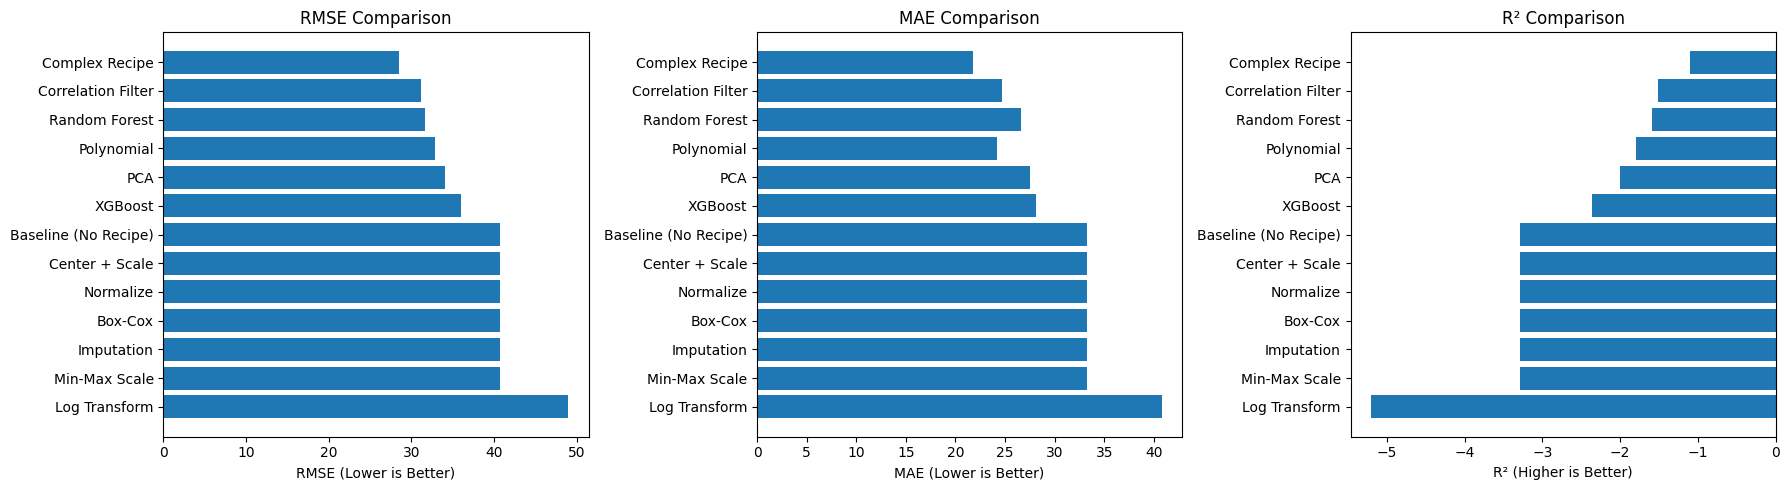


✅ Best Model by RMSE: Complex Recipe
   RMSE: 28.5246
   MAE: 21.7780
   R²: -1.1045


In [22]:
# Collect test set statistics from all models
comparison_data = []

models_info = [
    ("Baseline (No Recipe)", stats_baseline),
    ("Normalize", stats_normalize),
    ("Min-Max Scale", stats_scale),
    ("Center + Scale", stats_cs),
    ("Polynomial", stats_poly),
    # ("Interactions", stats_interact),
    ("PCA", stats_pca),
    ("Correlation Filter", stats_corr),
    ("Log Transform", stats_log),
    ("Box-Cox", stats_boxcox),
    ("Imputation", stats_impute),
    ("Complex Recipe", stats_complex),
    ("Random Forest", stats_rf),
    ("XGBoost", stats_xgb)
]

for model_name, stats in models_info:
    test_stats = stats[stats['split'] == 'test']
    
    rmse_val = test_stats[test_stats['metric'] == 'rmse']['value'].values[0]
    mae_val = test_stats[test_stats['metric'] == 'mae']['value'].values[0]
    r2_val = test_stats[test_stats['metric'] == 'r_squared']['value'].values[0]
    
    comparison_data.append({
        'Model': model_name,
        'RMSE': rmse_val,
        'MAE': mae_val,
        'R²': r2_val
    })

comparison_df = pd.DataFrame(comparison_data)

# Sort by RMSE (lower is better)
comparison_df = comparison_df.sort_values('RMSE')

print("\n" + "="*70)
print("MODEL COMPARISON - Test Set Performance")
print("="*70)
display(comparison_df)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE comparison
axes[0].barh(comparison_df['Model'], comparison_df['RMSE'])
axes[0].set_xlabel('RMSE (Lower is Better)')
axes[0].set_title('RMSE Comparison')
axes[0].invert_yaxis()

# MAE comparison
axes[1].barh(comparison_df['Model'], comparison_df['MAE'])
axes[1].set_xlabel('MAE (Lower is Better)')
axes[1].set_title('MAE Comparison')
axes[1].invert_yaxis()

# R² comparison
axes[2].barh(comparison_df['Model'], comparison_df['R²'])
axes[2].set_xlabel('R² (Higher is Better)')
axes[2].set_title('R² Comparison')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n✅ Best Model by RMSE:", comparison_df.iloc[0]['Model'])
print(f"   RMSE: {comparison_df.iloc[0]['RMSE']:.4f}")
print(f"   MAE: {comparison_df.iloc[0]['MAE']:.4f}")
print(f"   R²: {comparison_df.iloc[0]['R²']:.4f}")

# 21. Time Series Recipe Steps

## Time Series Feature Engineering

These steps create time-based features specifically designed for forecasting models.

In [23]:
from py_recipes.selectors import (
    all_numeric, all_nominal, all_predictors, all_outcomes,
    all_numeric_predictors, all_nominal_predictors,
    contains, starts_with, ends_with, matches  # ← These are now available
)

# Recipe with lag features (previous values)
rec_lag = (
    recipe()
    # .step_lag(["target"], lags=[1, 2, 3])  # Create 1, 2, and 3-step lags
    .step_rm(contains("lag"))
    .step_lag(all_numeric_predictors(), lags=[1, 2, 3])
    .step_naomit()  # Remove rows with NaN from lagging
)

# Workflow
wf_lag = (
    workflow()
    .add_recipe(rec_lag)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_lag = wf_lag.fit(train_data)
fit_lag = fit_lag.evaluate(test_data)

print("✓ Lag features model fitted successfully!")

outputs_lag, coefs_lag, stats_lag = fit_lag.extract_outputs()

print("\n=== Lag Features Model Statistics ===")
display(stats_lag[stats_lag['split'] == 'test'][['metric', 'value']])

# Fit on training data
rec_fit = rec_lag.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Lag features model fitted successfully!

=== Lag Features Model Statistics ===


,metric,value
7,rmse,33.710387
8,mae,28.996888
9,mape,22.289563
10,smape,25.450345
11,r_squared,-1.62065
12,mda,45.454545



Processed training data:

Processed test data:
Index(['date', 'mean_nwe_lsfo_crack_trade_month',
       'mean_sing_gasoline_vs_vlsfo_trade_month', 'new_sweet_sr_margin',
       'target', 'totaltar', 'mean_nwe_lsfo_crack_trade_month_lag_1',
       'mean_nwe_lsfo_crack_trade_month_lag_2',
       'mean_nwe_lsfo_crack_trade_month_lag_3',
       'mean_sing_gasoline_vs_vlsfo_trade_month_lag_1',
       'mean_sing_gasoline_vs_vlsfo_trade_month_lag_2',
       'mean_sing_gasoline_vs_vlsfo_trade_month_lag_3',
       'new_sweet_sr_margin_lag_1', 'new_sweet_sr_margin_lag_2',
       'new_sweet_sr_margin_lag_3', 'totaltar_lag_1', 'totaltar_lag_2',
       'totaltar_lag_3'],
      dtype='object')


,date,mean_nwe_lsfo_crack_trade_month,mean_sing_gasoline_vs_vlsfo_trade_month,new_sweet_sr_margin,target,totaltar,mean_nwe_lsfo_crack_trade_month_lag_1,mean_nwe_lsfo_crack_trade_month_lag_2,mean_nwe_lsfo_crack_trade_month_lag_3,mean_sing_gasoline_vs_vlsfo_trade_month_lag_1,mean_sing_gasoline_vs_vlsfo_trade_month_lag_2,mean_sing_gasoline_vs_vlsfo_trade_month_lag_3,new_sweet_sr_margin_lag_1,new_sweet_sr_margin_lag_2,new_sweet_sr_margin_lag_3,totaltar_lag_1,totaltar_lag_2,totaltar_lag_3
3,2020-07-01,-2.71,-3.20,-1.55,79.77,0.00,-3.44,3.89,-3.07,-4.28,-8.75,-16.09,6.61,0.57,0.47,0.00,0.00,0.00
4,2020-08-01,-2.63,-5.35,-2.70,48.27,0.00,-2.71,-3.44,3.89,-3.20,-4.28,-8.75,-1.55,6.61,0.57,0.00,0.00,0.00
5,2020-09-01,-2.08,-3.26,-2.10,98.01,0.00,-2.63,-2.71,-3.44,-5.35,-3.20,-4.28,-2.70,-1.55,6.61,0.00,0.00,0.00
6,2020-10-01,0.16,-4.31,-3.34,49.77,0.00,-2.08,-2.63,-2.71,-3.26,-5.35,-3.20,-2.10,-2.70,-1.55,0.00,0.00,0.00
7,2020-11-01,1.80,-7.40,-2.53,35.48,0.00,0.16,-2.08,-2.63,-4.31,-3.26,-5.35,-3.34,-2.10,-2.70,0.00,0.00,0.00
8,2020-12-01,0.94,-7.65,0.00,63.98,0.00,1.80,0.16,-2.08,-7.40,-4.31,-3.26,-2.53,-3.34,-2.10,0.00,0.00,0.00
9,2021-01-01,0.63,-7.67,-0.05,109.76,0.00,0.94,1.80,0.16,-7.65,-7.40,-4.31,0.00,-2.53,-3.34,0.00,0.00,0.00
10,2021-02-01,2.60,-9.41,-0.55,102.98,0.00,0.63,0.94,1.80,-7.67,-7.65,-7.40,-0.05,0.00,-2.53,0.00,0.00,0.00
11,2021-03-01,1.86,-6.70,-0.10,123.83,0.00,2.60,0.63,0.94,-9.41,-7.67,-7.65,-0.55,-0.05,0.00,0.00,0.00,0.00
12,2021-04-01,0.13,-3.81,-0.26,95.58,0.00,1.86,2.60,0.63,-6.70,-9.41,-7.67,-0.10,-0.55,-0.05,0.00,0.00,0.00


,date,mean_nwe_lsfo_crack_trade_month,mean_sing_gasoline_vs_vlsfo_trade_month,new_sweet_sr_margin,target,totaltar,mean_nwe_lsfo_crack_trade_month_lag_1,mean_nwe_lsfo_crack_trade_month_lag_2,mean_nwe_lsfo_crack_trade_month_lag_3,mean_sing_gasoline_vs_vlsfo_trade_month_lag_1,mean_sing_gasoline_vs_vlsfo_trade_month_lag_2,mean_sing_gasoline_vs_vlsfo_trade_month_lag_3,new_sweet_sr_margin_lag_1,new_sweet_sr_margin_lag_2,new_sweet_sr_margin_lag_3,totaltar_lag_1,totaltar_lag_2,totaltar_lag_3
3,2024-01-01,-5.47,-1.61,0.06,122.65,0.00,-6.70,-6.92,-6.51,3.24,-8.22,-5.16,-4.27,1.97,4.19,0.00,0.00,0.00
4,2024-02-01,-7.82,0.72,2.85,129.09,0.00,-5.47,-6.70,-6.92,-1.61,3.24,-8.22,0.06,-4.27,1.97,0.00,0.00,0.00
5,2024-03-01,-6.85,-0.88,1.68,145.57,31.26,-7.82,-5.47,-6.70,0.72,-1.61,3.24,2.85,0.06,-4.27,0.00,0.00,0.00
6,2024-04-01,-8.21,2.44,1.84,158.23,57.00,-6.85,-7.82,-5.47,-0.88,0.72,-1.61,1.68,2.85,0.06,31.26,0.00,0.00
7,2024-05-01,-8.37,-0.52,1.18,104.04,13.45,-8.21,-6.85,-7.82,2.44,-0.88,0.72,1.84,1.68,2.85,57.00,31.26,0.00
8,2024-06-01,-8.28,-3.48,-3.23,173.23,57.00,-8.37,-8.21,-6.85,-0.52,2.44,-0.88,1.18,1.84,1.68,13.45,57.00,31.26
9,2024-07-01,-7.06,-3.96,-0.77,126.20,69.19,-8.28,-8.37,-8.21,-3.48,-0.52,2.44,-3.23,1.18,1.84,57.00,13.45,57.00
10,2024-08-01,-6.74,-4.09,-0.94,105.07,63.10,-7.06,-8.28,-8.37,-3.96,-3.48,-0.52,-0.77,-3.23,1.18,69.19,57.00,13.45
11,2024-09-01,-3.99,-10.08,-3.36,127.01,57.00,-6.74,-7.06,-8.28,-4.09,-3.96,-3.48,-0.94,-0.77,-3.23,63.10,69.19,57.00
12,2024-10-01,-3.43,-9.63,-4.50,101.18,57.00,-3.99,-6.74,-7.06,-10.08,-4.09,-3.96,-3.36,-0.94,-0.77,57.00,63.10,69.19


In [24]:
# Recipe with differencing (for stationarity)
rec_diff = (
    recipe()
    .step_diff(all_numeric_predictors(), lag=1, differences=1)  # First difference
    .step_naomit()  # Remove NaN from differencing
    .step_normalize(all_numeric_predictors())
)

# Workflow
wf_diff = (
    workflow()
    .add_recipe(rec_diff)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_diff = wf_diff.fit(train_data)
fit_diff = fit_diff.evaluate(test_data)

print("✓ Differencing model fitted successfully!")

outputs_diff, coefs_diff, stats_diff = fit_diff.extract_outputs()

print("\n=== Differencing Model Statistics ===")
display(stats_diff[stats_diff['split'] == 'test'][['metric', 'value']])

# Show differenced data
rec_fit = rec_diff.prep(train_data)
train_processed = rec_fit.bake(train_data)
print("\nDifferenced features (removes trend):")
display(train_processed.head())

# Fit on training data
rec_fit = rec_diff.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Differencing model fitted successfully!

=== Differencing Model Statistics ===


,metric,value
7,rmse,44.16441
8,mae,37.418266
9,mape,28.143119
10,smape,34.18871
11,r_squared,-3.985887
12,mda,23.076923



Differenced features (removes trend):


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar,mean_med_diesel_crack_input1_trade_month_lag2_diff_lag_1,mean_nwe_hsfo_crack_trade_month_lag1_diff_lag_1,mean_nwe_lsfo_crack_trade_month_diff_lag_1,mean_nwe_ulsfo_crack_trade_month_lag3_diff_lag_1,mean_sing_gasoline_vs_vlsfo_trade_month_diff_lag_1,mean_sing_vlsfo_crack_trade_month_lag3_diff_lag_1,new_sweet_sr_margin_diff_lag_1,totaltar_diff_lag_1
1,2020-05-01,0.168354,0.086096,1.182267,0.842582,-1.079327,1.171028,0.393679,113.53,-0.240273,0.201725,0.124622,0.960695,-1.185409,1.594212,-1.333227,0.033091,3.212239e-18
2,2020-06-01,0.395361,0.133570,-0.013689,-0.251077,-0.157960,-0.205708,2.206445,43.31,-0.240273,0.178145,0.015673,-1.014674,-1.887169,0.925153,-1.870762,1.547925,3.212239e-18
3,2020-07-01,0.420584,0.271968,0.105417,-0.570507,0.064652,-0.630608,-0.242590,79.77,-0.240273,0.025647,0.089393,0.099495,-0.487940,0.134870,-0.521528,-2.073396,3.212239e-18
4,2020-08-01,0.234868,0.352432,0.118469,-1.301988,-0.378511,-0.976315,-0.587736,48.27,-0.240273,-0.133770,0.042421,0.009643,-1.232622,-0.618114,-0.409272,-0.285688,3.212239e-18
5,2020-09-01,0.179564,0.371743,0.208207,-0.932685,0.052285,-0.993067,-0.407660,98.01,-0.240273,-0.035211,-0.007160,0.074613,0.756773,0.370323,0.057023,0.160602,3.212239e-18



Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target', 'totaltar',
       'mean_med_diesel_crack_input1_trade_month_lag2_diff_lag_1',
       'mean_nwe_hsfo_crack_trade_month_lag1_diff_lag_1',
       'mean_nwe_lsfo_crack_trade_month_diff_lag_1',
       'mean_nwe_ulsfo_crack_trade_month_lag3_diff_lag_1',
       'mean_sing_gasoline_vs_vlsfo_trade_month_diff_lag_1',
       'mean_sing_vlsfo_crack_trade_month_lag3_diff_lag_1',
       'new_sweet_sr_margin_diff_lag_1', 'totaltar_diff_lag_1'],
      dtype='object')


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar,mean_med_diesel_crack_input1_trade_month_lag2_diff_lag_1,mean_nwe_hsfo_crack_trade_month_lag1_diff_lag_1,mean_nwe_lsfo_crack_trade_month_diff_lag_1,mean_nwe_ulsfo_crack_trade_month_lag3_diff_lag_1,mean_sing_gasoline_vs_vlsfo_trade_month_diff_lag_1,mean_sing_vlsfo_crack_trade_month_lag3_diff_lag_1,new_sweet_sr_margin_diff_lag_1,totaltar_diff_lag_1
1,2020-05-01,0.168354,0.086096,1.182267,0.842582,-1.079327,1.171028,0.393679,113.53,-0.240273,0.201725,0.124622,0.960695,-1.185409,1.594212,-1.333227,0.033091,3.212239e-18
2,2020-06-01,0.395361,0.133570,-0.013689,-0.251077,-0.157960,-0.205708,2.206445,43.31,-0.240273,0.178145,0.015673,-1.014674,-1.887169,0.925153,-1.870762,1.547925,3.212239e-18
3,2020-07-01,0.420584,0.271968,0.105417,-0.570507,0.064652,-0.630608,-0.242590,79.77,-0.240273,0.025647,0.089393,0.099495,-0.487940,0.134870,-0.521528,-2.073396,3.212239e-18
4,2020-08-01,0.234868,0.352432,0.118469,-1.301988,-0.378511,-0.976315,-0.587736,48.27,-0.240273,-0.133770,0.042421,0.009643,-1.232622,-0.618114,-0.409272,-0.285688,3.212239e-18
5,2020-09-01,0.179564,0.371743,0.208207,-0.932685,0.052285,-0.993067,-0.407660,98.01,-0.240273,-0.035211,-0.007160,0.074613,0.756773,0.370323,0.057023,0.160602,3.212239e-18
6,2020-10-01,0.137900,0.413585,0.573684,-0.885186,-0.164144,-1.046370,-0.779817,49.77,-0.240273,-0.024903,0.011107,0.308229,0.175192,-0.361680,0.005213,-0.308640,3.212239e-18
7,2020-11-01,0.157517,0.387031,0.841265,-0.912498,-0.801062,-0.865141,-0.536715,35.48,-0.240273,0.021411,-0.044346,0.225288,0.039990,-0.837249,0.337664,0.214157,3.212239e-18
8,2020-12-01,0.183488,0.551178,0.700948,-1.052620,-0.852592,-0.982407,0.222606,63.98,-0.240273,0.026212,0.110269,-0.120298,-0.163885,-0.175183,-0.085456,0.652796,3.212239e-18
9,2021-01-01,0.190401,0.338753,0.650368,-0.816313,-0.856715,-0.677819,0.207600,109.76,-0.240273,0.011809,-0.195048,-0.044269,0.516415,-0.121565,0.512525,-0.005163,3.212239e-18
10,2021-02-01,1.867078,0.329902,0.971792,-0.683317,-1.215368,-0.478314,0.057537,102.98,-0.240273,1.273728,-0.029994,0.270906,0.329708,-0.522534,0.363569,-0.119923,3.212239e-18


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar,mean_med_diesel_crack_input1_trade_month_lag2_diff_lag_1,mean_nwe_hsfo_crack_trade_month_lag1_diff_lag_1,mean_nwe_lsfo_crack_trade_month_diff_lag_1,mean_nwe_ulsfo_crack_trade_month_lag3_diff_lag_1,mean_sing_gasoline_vs_vlsfo_trade_month_diff_lag_1,mean_sing_vlsfo_crack_trade_month_lag3_diff_lag_1,new_sweet_sr_margin_diff_lag_1,totaltar_diff_lag_1
1,2023-11-01,-0.675029,0.021725,-0.581483,-0.433948,-0.970082,-0.196571,0.813856,118.37,-0.240273,-0.051590,-0.400550,-0.058092,0.340438,-0.830255,0.102357,-0.558562,3.212239e-18
2,2023-12-01,-0.679513,-0.289670,-0.545588,-0.828188,1.392080,-0.379323,-1.058935,113.03,-0.240273,0.003196,-0.275292,0.028995,-0.623142,2.554674,-0.178283,-1.583753,3.212239e-18
3,2024-01-01,-0.584787,-0.053911,-0.344903,-0.696379,0.392386,-0.185910,0.240614,122.65,-0.240273,0.078174,0.168332,0.168612,0.327562,-1.247543,0.354934,1.111836,3.212239e-18
4,2024-02-01,-0.475861,1.796759,-0.728327,-0.290264,0.872651,0.619725,1.077968,129.09,-0.240273,0.088905,1.477674,-0.326267,0.823301,0.426272,1.222761,0.719102,3.212239e-18
5,2024-03-01,-0.464277,-0.179435,-0.570062,-0.064645,0.542856,0.135430,0.726819,145.57,0.421654,0.015339,-1.625082,0.132671,0.497100,-0.489897,-0.605720,-0.290788,5.794160e-01
6,2024-04-01,-0.505942,1.790322,-0.791959,-0.283139,1.227182,-0.111286,0.774840,158.23,0.966696,-0.024903,1.574228,-0.189415,-0.305525,0.657062,-0.268952,0.048392,4.771007e-01
7,2024-05-01,-0.569466,-0.284038,-0.818064,0.386594,0.617060,0.238990,0.576756,104.04,0.044529,-0.041424,-1.704673,-0.023534,1.299725,-0.806943,0.577288,-0.160726,-8.072158e-01
8,2024-06-01,-0.671479,-0.044255,-0.803380,0.257160,0.006938,0.196348,-0.746803,173.23,0.966696,-0.070511,0.171594,0.011025,-0.144571,-0.806943,0.020324,-1.117061,8.072158e-01
9,2024-07-01,-0.599360,0.138398,-0.604326,0.071914,-0.092001,-0.289470,-0.008491,126.20,1.224817,0.061089,0.125274,0.167230,-0.245436,-0.228801,-0.607879,0.634944,2.259463e-01
10,2024-08-01,-0.536583,0.148054,-0.552115,-0.197641,-0.118797,-0.204185,-0.059513,105.07,1.095862,0.054029,-0.014989,0.042819,-0.397806,-0.147208,0.201661,-0.035765,-1.128805e-01


In [25]:
# # Recipe with percent changes
# rec_pct = (
#     recipe()
#     .step_pct_change(all_numeric_predictors(), periods=1)  # Period-over-period % change
#     .step_naomit()
#     .step_normalize(all_numeric_predictors())
# )

# # Workflow
# wf_pct = (
#     workflow()
#     .add_recipe(rec_pct)
#     .add_model(linear_reg().set_engine("sklearn"))
# )

# # Fit and evaluate
# fit_pct = wf_pct.fit(train_data)
# fit_pct = fit_pct.evaluate(test_data)

# print("✓ Percent change model fitted successfully!")

# outputs_pct, coefs_pct, stats_pct = fit_pct.extract_outputs()

# print("\n=== Percent Change Model Statistics ===")
# display(stats_pct[stats_pct['split'] == 'test'][['metric', 'value']])

# # Fit on training data
# rec_fit = rec_pct.prep(train_data)

# # Apply to training data
# train_processed = rec_fit.bake(train_data)

# print("\nProcessed training data:")

# # Apply to test data (using training parameters!)
# test_processed = rec_fit.bake(test_data)
# print("\nProcessed test data:")
# print(train_processed.columns)
# display(train_processed)
# display(test_processed)

In [26]:
# Recipe with rolling window features
rec_rolling = (
    recipe()
    .step_rolling(["target"], window=3, stats=["mean", "std", "min", "max"])
    .step_naomit()
    .step_normalize(all_numeric_predictors())
)

# Workflow
wf_rolling = (
    workflow()
    .add_recipe(rec_rolling)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_rolling = wf_rolling.fit(train_data)
fit_rolling = fit_rolling.evaluate(test_data)

print("✓ Rolling window model fitted successfully!")

outputs_rolling, coefs_rolling, stats_rolling = fit_rolling.extract_outputs()

print("\n=== Rolling Window Model Statistics ===")
display(stats_rolling[stats_rolling['split'] == 'test'][['metric', 'value']])

# Fit on training data
rec_fit = rec_rolling.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Rolling window model fitted successfully!

=== Rolling Window Model Statistics ===


,metric,value
7,rmse,17.449177
8,mae,13.434113
9,mape,10.552903
10,smape,10.618242
11,r_squared,0.26839
12,mda,83.333333



Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target', 'totaltar', 'target_rolling_3_mean', 'target_rolling_3_std',
       'target_rolling_3_min', 'target_rolling_3_max'],
      dtype='object')


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar,target_rolling_3_mean,target_rolling_3_std,target_rolling_3_min,target_rolling_3_max
2,2020-06-01,0.394807,0.134070,0.015954,-0.229234,-0.185394,-0.177334,2.193345,43.31,-0.243434,-0.030085,1.415489,-1.161115,0.401764
3,2020-07-01,0.419730,0.270782,0.135709,-0.547582,0.037761,-0.604404,-0.230339,79.77,-0.243434,-0.835795,0.464433,-1.161115,-0.446554
4,2020-08-01,0.236227,0.350266,0.148833,-1.276586,-0.406481,-0.951878,-0.571912,48.27,-0.243434,-1.744236,-0.585988,-1.161115,-1.633917
5,2020-09-01,0.181582,0.369342,0.239060,-0.908533,0.025363,-0.968715,-0.393700,98.01,-0.243434,-0.982793,-0.217115,-0.967434,-0.992403
6,2020-10-01,0.140414,0.410674,0.606530,-0.861195,-0.191592,-1.022291,-0.762005,49.77,-0.243434,-1.400404,-0.002742,-0.967434,-0.992403
7,2020-11-01,0.159798,0.384444,0.875570,-0.888415,-0.830061,-0.840135,-0.521419,35.48,-0.243434,-1.578445,0.303314,-1.466864,-0.992403
8,2020-12-01,0.185459,0.546591,0.734488,-1.028062,-0.881717,-0.958000,0.230042,63.98,-0.243434,-2.052154,-0.964180,-1.466864,-2.189262
9,2021-01-01,0.192290,0.336754,0.683633,-0.792555,-0.885849,-0.651857,0.215191,109.76,-0.243434,-1.217073,0.625639,-1.466864,-0.579147
10,2021-02-01,1.848981,0.328010,1.006809,-0.660009,-1.245375,-0.451332,0.066681,102.98,-0.243434,-0.277450,-0.248284,-0.353984,-0.579147
11,2021-03-01,-0.027396,0.260449,0.885413,-0.552315,-0.685424,-0.448271,0.200340,123.83,-0.243434,0.555683,-1.211635,1.168905,-0.084295


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar,target_rolling_3_mean,target_rolling_3_std,target_rolling_3_min,target_rolling_3_max
2,2023-12-01,-0.667255,-0.284016,-0.518846,-0.804390,1.368420,-0.351836,-1.038234,113.03,-0.243434,0.590205,-1.572766,1.351261,-0.276327
3,2024-01-01,-0.573657,-0.051128,-0.317065,-0.673027,0.366293,-0.157434,0.247863,122.65,-0.243434,0.799010,-1.609753,1.561342,-0.125797
4,2024-02-01,-0.466030,1.777003,-0.702580,-0.268288,0.847727,0.652316,1.076549,129.09,-0.243434,0.948236,-1.386406,1.561342,0.100703
5,2024-03-01,-0.454584,-0.175123,-0.543453,-0.043433,0.517129,0.165547,0.729036,145.57,0.410844,1.401204,-1.130476,1.936987,0.680316
6,2024-04-01,-0.495752,1.770644,-0.766559,-0.261187,1.203121,-0.082429,0.776559,158.23,0.949586,1.896490,-0.939422,2.188459,1.125577
7,2024-05-01,-0.558519,-0.278452,-0.792807,0.406278,0.591513,0.269636,0.580526,104.04,0.038077,1.547785,0.000915,1.210296,1.125577
8,2024-06-01,-0.659316,-0.041590,-0.778043,0.277282,-0.020094,0.226776,-0.729333,173.23,0.949586,1.932822,0.552002,1.210296,1.653138
9,2024-07-01,-0.588057,0.138839,-0.577903,0.092664,-0.119274,-0.261523,0.001337,126.20,1.204725,1.486953,0.479045,1.210296,1.653138
10,2024-08-01,-0.526028,0.148377,-0.525408,-0.175979,-0.146135,-0.175803,-0.049157,105.07,1.077260,1.501291,0.448815,1.250516,1.653138
11,2024-09-01,-0.587319,0.080020,-0.074273,-0.593736,-1.383814,-0.495723,-0.767946,127.01,0.949586,0.857893,-1.088100,1.250516,0.027547


In [27]:
# Recipe with date features
rec_date = (
    recipe()
    .step_date("date", features=["year", "month", "quarter", "dayofweek", "dayofyear"])
    # .step_normalize(all_numeric_predictors())
)

# Workflow
wf_date = (
    workflow()
    .add_recipe(rec_date)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_date = wf_date.fit(train_data)
fit_date = fit_date.evaluate(test_data)

print("✓ Date features model fitted successfully!")

outputs_date, coefs_date, stats_date = fit_date.extract_outputs()

print("\n=== Date Features Model Statistics ===")
display(stats_date[stats_date['split'] == 'test'][['metric', 'value']])

# Fit on training data
rec_fit = rec_date.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Date features model fitted successfully!

=== Date Features Model Statistics ===


,metric,value
7,rmse,45.314438
8,mae,36.921187
9,mape,27.825772
10,smape,34.72297
11,r_squared,-4.311181
12,mda,28.571429



Processed training data:

Processed test data:
Index(['mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target', 'totaltar', 'date_year', 'date_month', 'date_quarter',
       'date_dayofweek', 'date_dayofyear'],
      dtype='object')


,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar,date_year,date_month,date_quarter,date_dayofweek,date_dayofyear
0,-56.18,-11.43,-3.07,28.58,-16.09,26.91,0.47,137.65,0.00,2020,4,2,2,92
1,-42.36,-9.17,3.89,22.64,-8.75,20.36,0.57,113.53,0.00,2020,5,2,4,122
2,-30.21,-8.58,-3.44,13.43,-4.28,11.32,6.61,43.31,0.00,2020,6,2,0,153
3,-28.86,-6.86,-2.71,10.74,-3.20,8.53,-1.55,79.77,0.00,2020,7,3,2,183
4,-38.80,-5.86,-2.63,4.58,-5.35,6.26,-2.70,48.27,0.00,2020,8,3,5,214
5,-41.76,-5.62,-2.08,7.69,-3.26,6.15,-2.10,98.01,0.00,2020,9,3,1,245
6,-43.99,-5.10,0.16,8.09,-4.31,5.80,-3.34,49.77,0.00,2020,10,4,3,275
7,-42.94,-5.43,1.80,7.86,-7.40,6.99,-2.53,35.48,0.00,2020,11,4,6,306
8,-41.55,-3.39,0.94,6.68,-7.65,6.22,0.00,63.98,0.00,2020,12,4,1,336
9,-41.18,-6.03,0.63,8.67,-7.67,8.22,-0.05,109.76,0.00,2021,1,1,4,1


,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar,date_year,date_month,date_quarter,date_dayofweek,date_dayofyear
0,-83.38,-4.18,-6.51,10.72,-5.16,11.28,4.19,107.65,0.00,2023,10,4,6,274
1,-87.50,-9.97,-6.92,11.89,-8.22,11.38,1.97,118.37,0.00,2023,11,4,2,305
2,-87.74,-13.84,-6.70,8.57,3.24,10.18,-4.27,113.03,0.00,2023,12,4,4,335
3,-82.67,-10.91,-5.47,9.68,-1.61,11.45,0.06,122.65,0.00,2024,1,1,0,1
4,-76.84,12.09,-7.82,13.10,0.72,16.74,2.85,129.09,0.00,2024,2,1,3,32
5,-76.22,-12.47,-6.85,15.00,-0.88,13.56,1.68,145.57,31.26,2024,3,1,4,61
6,-78.45,12.01,-8.21,13.16,2.44,11.94,1.84,158.23,57.00,2024,4,2,0,92
7,-81.85,-13.77,-8.37,18.80,-0.52,14.24,1.18,104.04,13.45,2024,5,2,2,122
8,-87.31,-10.79,-8.28,17.71,-3.48,13.96,-3.23,173.23,57.00,2024,6,2,5,153
9,-83.45,-8.52,-7.06,16.15,-3.96,10.77,-0.77,126.20,69.19,2024,7,3,0,183


In [28]:
# Recipe with timeseries signature (comprehensive date features)
rec_ts_sig = (
    recipe()
    .step_timeseries_signature(
        "date",
        features=["year", "month", "quarter", "day_of_week", "day_of_year", "is_weekend", "is_month_start", "is_month_end"]
    )
    .step_normalize(all_numeric_predictors())
)

# Workflow
wf_ts_sig = (
    workflow()
    .add_recipe(rec_ts_sig)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_ts_sig = wf_ts_sig.fit(train_data)
fit_ts_sig = fit_ts_sig.evaluate(test_data)

print("✓ Timeseries signature model fitted successfully!")

outputs_ts_sig, coefs_ts_sig, stats_ts_sig = fit_ts_sig.extract_outputs()

print("\n=== Timeseries Signature Model Statistics ===")
display(stats_ts_sig[stats_ts_sig['split'] == 'test'][['metric', 'value']])

# Fit on training data
rec_fit = rec_ts_sig.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Timeseries signature model fitted successfully!

=== Timeseries Signature Model Statistics ===


,metric,value
7,rmse,45.259856
8,mae,36.853841
9,mape,27.769134
10,smape,34.655872
11,r_squared,-4.298394
12,mda,35.714286



Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target', 'totaltar', 'year', 'month', 'quarter', 'day_of_week',
       'day_of_year', 'is_weekend', 'is_month_start', 'is_month_end'],
      dtype='object')


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar,year,month,quarter,day_of_week,day_of_year,is_weekend,is_month_start,is_month_end
0,2020-04-01,-0.088770,-0.094595,0.046119,1.487556,-2.378036,2.031849,0.358746,137.65,-0.237232,-1.425573,-0.766750,-0.475191,-0.411569,-0.761939,-0.559017,0.0,0.0
1,2020-05-01,0.172544,0.089438,1.195442,0.793182,-0.956278,1.074411,0.389075,113.53,-0.237232,-1.425573,-0.460050,-0.475191,0.636061,-0.459849,-0.559017,0.0,0.0
2,2020-06-01,0.402280,0.137482,-0.014980,-0.283450,-0.090439,-0.246999,2.220933,43.31,-0.237232,-1.425573,-0.153350,-0.475191,-1.459198,-0.147689,-0.559017,0.0,0.0
3,2020-07-01,0.427807,0.277542,0.105567,-0.597906,0.118757,-0.654823,-0.253895,79.77,-0.237232,-1.425573,0.153350,0.475191,-0.411569,0.154402,-0.559017,0.0,0.0
4,2020-08-01,0.239857,0.358972,0.118778,-1.317998,-0.297698,-0.986637,-0.602676,48.27,-0.237232,-1.425573,0.460050,0.475191,1.159875,0.466562,1.788854,0.0,0.0
5,2020-09-01,0.183889,0.378516,0.209601,-0.954445,0.107135,-1.002717,-0.420703,98.01,-0.237232,-1.425573,0.766750,0.475191,-0.935383,0.778722,-0.559017,0.0,0.0
6,2020-10-01,0.141723,0.420859,0.579498,-0.907686,-0.096250,-1.053877,-0.796780,49.77,-0.237232,-1.425573,1.073450,1.425573,0.112246,1.080813,-0.559017,0.0,0.0
7,2020-11-01,0.161577,0.393987,0.850315,-0.934573,-0.694783,-0.879931,-0.551117,35.48,-0.237232,-1.425573,1.380150,1.425573,1.683690,1.392973,1.788854,0.0,0.0
8,2020-12-01,0.187859,0.560105,0.708301,-1.072512,-0.743208,-0.992484,0.216201,63.98,-0.237232,-1.425573,1.686851,1.425573,-0.935383,1.695063,-0.559017,0.0,0.0
9,2021-01-01,0.194855,0.345129,0.657110,-0.839885,-0.747082,-0.700137,0.201036,109.76,-0.237232,-0.475191,-1.686851,-1.425573,0.636061,-1.678280,-0.559017,0.0,0.0


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar,year,month,quarter,day_of_week,day_of_year,is_weekend,is_month_start,is_month_end
0,2023-10-01,-0.603078,0.495775,-0.521937,-0.600244,-0.260895,-0.252846,1.486976,107.65,-0.237232,1.425573,1.073450,1.425573,1.683690,1.070743,1.788854,0.0,0.0
1,2023-11-01,-0.680981,0.024293,-0.589642,-0.463473,-0.853617,-0.238228,0.813678,118.37,-0.237232,1.425573,1.380150,1.425573,-0.411569,1.382903,-0.559017,0.0,0.0
2,2023-12-01,-0.685519,-0.290842,-0.553312,-0.851575,1.366184,-0.413637,-1.078838,113.03,-0.237232,1.425573,1.686851,1.425573,0.636061,1.684993,-0.559017,0.0,0.0
3,2024-01-01,-0.589653,-0.052251,-0.350199,-0.721818,0.426739,-0.227996,0.234398,122.65,-0.237232,2.375955,-1.686851,-1.425573,-1.459198,-1.678280,-0.559017,0.0,0.0
4,2024-02-01,-0.479418,1.820648,-0.738261,-0.322026,0.878060,0.545263,1.080571,129.09,-0.237232,2.375955,-1.380150,-1.425573,0.112246,-1.366120,-0.559017,0.0,0.0
5,2024-03-01,-0.467694,-0.179283,-0.578082,-0.099920,0.568140,0.080430,0.725724,145.57,0.432258,2.375955,-1.073450,-1.425573,0.636061,-1.074099,-0.559017,0.0,0.0
6,2024-04-01,-0.509860,1.814133,-0.802663,-0.315013,1.211224,-0.156371,0.774250,158.23,0.983528,2.375955,-0.766750,-0.475191,-1.459198,-0.761939,-0.559017,0.0,0.0
7,2024-05-01,-0.574149,-0.285142,-0.829084,0.344293,0.637872,0.179828,0.574080,104.04,0.050824,2.375955,-0.460050,-0.475191,-0.411569,-0.459849,-0.559017,0.0,0.0
8,2024-06-01,-0.677388,-0.042480,-0.814222,0.216874,0.064521,0.138900,-0.763419,173.23,0.983528,2.375955,-0.153350,-0.475191,1.159875,-0.147689,1.788854,0.0,0.0
9,2024-07-01,-0.604402,0.142367,-0.612760,0.034513,-0.028455,-0.327394,-0.017331,126.20,1.244599,2.375955,0.153350,0.475191,-1.459198,0.154402,-0.559017,0.0,0.0


In [29]:
# Recipe with Fourier features (capture seasonal patterns)
rec_fourier = (
    recipe()
    .step_fourier("date", period=12, K=3)  # Monthly seasonality with 3 Fourier pairs
    .step_normalize(all_numeric_predictors())
)

# Workflow
wf_fourier = (
    workflow()
    .add_recipe(rec_fourier)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_fourier = wf_fourier.fit(train_data)
fit_fourier = fit_fourier.evaluate(test_data)

print("✓ Fourier features model fitted successfully!")

outputs_fourier, coefs_fourier, stats_fourier = fit_fourier.extract_outputs()

print("\n=== Fourier Features Model Statistics ===")
display(stats_fourier[stats_fourier['split'] == 'test'][['metric', 'value']])

# Fit on training data
rec_fit = rec_fourier.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Fourier features model fitted successfully!

=== Fourier Features Model Statistics ===


,metric,value
7,rmse,49.843078
8,mae,39.780171
9,mape,30.884001
10,smape,40.08613
11,r_squared,-5.425806
12,mda,35.714286



Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target', 'totaltar', 'fourier_p12_k1_sin', 'fourier_p12_k1_cos',
       'fourier_p12_k2_sin', 'fourier_p12_k2_cos', 'fourier_p12_k3_sin',
       'fourier_p12_k3_cos'],
      dtype='object')


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar,fourier_p12_k1_sin,fourier_p12_k1_cos,fourier_p12_k2_sin,fourier_p12_k2_cos,fourier_p12_k3_sin,fourier_p12_k3_cos
0,2020-04-01,-0.088770,-0.094595,0.046119,1.487556,-2.378036,2.031849,0.358746,137.65,-0.237232,0.004383,1.441137,0.150143,1.477395,0.069171,1.318761
1,2020-05-01,0.172544,0.089438,1.195442,0.793182,-0.956278,1.074411,0.389075,113.53,-0.237232,0.004383,-1.475863,0.150143,1.477395,0.069171,-1.450637
2,2020-06-01,0.402280,0.137482,-0.014980,-0.283450,-0.090439,-0.246999,2.220933,43.31,-0.237232,0.691346,1.245735,1.411341,0.780197,1.521772,-0.065938
3,2020-07-01,0.427807,0.277542,0.105567,-0.597906,0.118757,-0.654823,-0.253895,79.77,-0.237232,-0.682581,-1.280461,1.411341,0.780197,-1.383429,-0.065938
4,2020-08-01,0.239857,0.358972,0.118778,-1.317998,-0.297698,-0.986637,-0.602676,48.27,-0.237232,1.194239,0.711887,1.411341,-0.614198,0.069171,-1.450637
5,2020-09-01,0.183889,0.378516,0.209601,-0.954445,0.107135,-1.002717,-0.420703,98.01,-0.237232,-1.369545,-0.017363,0.150143,-1.311395,1.521772,-0.065938
6,2020-10-01,0.141723,0.420859,0.579498,-0.907686,-0.096250,-1.053877,-0.796780,49.77,-0.237232,1.378310,-0.017363,0.150143,-1.311395,-1.383429,-0.065938
7,2020-11-01,0.161577,0.393987,0.850315,-0.934573,-0.694783,-0.879931,-0.551117,35.48,-0.237232,-1.185473,0.711887,-1.111056,-0.614198,0.069171,-1.450637
8,2020-12-01,0.187859,0.560105,0.708301,-1.072512,-0.743208,-0.992484,0.216201,63.98,-0.237232,1.194239,-0.746613,-1.111056,-0.614198,0.069171,1.318761
9,2021-01-01,0.194855,0.345129,0.657110,-0.839885,-0.747082,-0.700137,0.201036,109.76,-0.237232,-0.682581,1.245735,-1.111056,0.780197,-1.383429,-0.065938


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar,fourier_p12_k1_sin,fourier_p12_k1_cos,fourier_p12_k2_sin,fourier_p12_k2_cos,fourier_p12_k3_sin,fourier_p12_k3_cos
0,2023-10-01,-0.603078,0.495775,-0.521937,-0.600244,-0.260895,-0.252846,1.486976,107.65,-0.237232,0.004383,1.441137,0.150143,1.477395,0.069171,1.318761
1,2023-11-01,-0.680981,0.024293,-0.589642,-0.463473,-0.853617,-0.238228,0.813678,118.37,-0.237232,-0.682581,-1.280461,1.411341,0.780197,-1.383429,-0.065938
2,2023-12-01,-0.685519,-0.290842,-0.553312,-0.851575,1.366184,-0.413637,-1.078838,113.03,-0.237232,0.691346,1.245735,1.411341,0.780197,1.521772,-0.065938
3,2024-01-01,-0.589653,-0.052251,-0.350199,-0.721818,0.426739,-0.227996,0.234398,122.65,-0.237232,-1.185473,-0.746613,1.411341,-0.614198,0.069171,1.318761
4,2024-02-01,-0.479418,1.820648,-0.738261,-0.322026,0.878060,0.545263,1.080571,129.09,-0.237232,1.378310,-0.017363,0.150143,-1.311395,-1.383429,-0.065938
5,2024-03-01,-0.467694,-0.179283,-0.578082,-0.099920,0.568140,0.080430,0.725724,145.57,0.432258,-1.185473,-0.746613,1.411341,-0.614198,0.069171,1.318761
6,2024-04-01,-0.509860,1.814133,-0.802663,-0.315013,1.211224,-0.156371,0.774250,158.23,0.983528,1.378310,-0.017363,0.150143,-1.311395,-1.383429,-0.065938
7,2024-05-01,-0.574149,-0.285142,-0.829084,0.344293,0.637872,0.179828,0.574080,104.04,0.050824,-1.369545,-0.017363,0.150143,-1.311395,1.521772,-0.065938
8,2024-06-01,-0.677388,-0.042480,-0.814222,0.216874,0.064521,0.138900,-0.763419,173.23,0.983528,1.194239,-0.746613,-1.111056,-0.614198,0.069171,1.318761
9,2024-07-01,-0.604402,0.142367,-0.612760,0.034513,-0.028455,-0.327394,-0.017331,126.20,1.244599,-1.185473,0.711887,-1.111056,-0.614198,0.069171,-1.450637


In [30]:
# Recipe with exponentially weighted moving features
rec_ewm = (
    recipe()
    .step_ewm(["target"], span=5, statistics=["mean", "std"])
    .step_naomit()
    .step_normalize(all_numeric_predictors())
)

# Workflow
wf_ewm = (
    workflow()
    .add_recipe(rec_ewm)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_ewm = wf_ewm.fit(train_data)
fit_ewm = fit_ewm.evaluate(test_data)

print("✓ EWM model fitted successfully!")

outputs_ewm, coefs_ewm, stats_ewm = fit_ewm.extract_outputs()

print("\n=== EWM Model Statistics ===")
display(stats_ewm[stats_ewm['split'] == 'test'][['metric', 'value']])

# Fit on training data
rec_fit = rec_ewm.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ EWM model fitted successfully!

=== EWM Model Statistics ===


,metric,value
7,rmse,26.448488
8,mae,23.290405
9,mape,19.962207
10,smape,17.584864
11,r_squared,-0.788131
12,mda,84.615385



Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target', 'totaltar', 'ewm_target_mean_5', 'ewm_target_std_5'],
      dtype='object')


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar,ewm_target_mean_5,ewm_target_std_5
1,2020-05-01,0.168354,0.086096,1.182267,0.842582,-1.079327,1.171028,0.393679,113.53,-0.240273,1.262776,-1.392763
2,2020-06-01,0.395361,0.133570,-0.013689,-0.251077,-0.157960,-0.205708,2.206445,43.31,-0.240273,-0.700833,1.869529
3,2020-07-01,0.420584,0.271968,0.105417,-0.570507,0.064652,-0.630608,-0.242590,79.77,-0.240273,-0.821045,0.541978
4,2020-08-01,0.234868,0.352432,0.118469,-1.301988,-0.378511,-0.976315,-0.587736,48.27,-0.240273,-1.513628,0.285896
5,2020-09-01,0.179564,0.371743,0.208207,-0.932685,0.052285,-0.993067,-0.407660,98.01,-0.240273,-0.976431,-0.027638
6,2020-10-01,0.137900,0.413585,0.573684,-0.885186,-0.164144,-1.046370,-0.779817,49.77,-0.240273,-1.532615,-0.167220
7,2020-11-01,0.157517,0.387031,0.841265,-0.912498,-0.801062,-0.865141,-0.536715,35.48,-0.240273,-2.141855,-0.145273
8,2020-12-01,0.183488,0.551178,0.700948,-1.052620,-0.852592,-0.982407,0.222606,63.98,-0.240273,-2.028208,-0.673351
9,2021-01-01,0.190401,0.338753,0.650368,-0.816313,-0.856715,-0.677819,0.207600,109.76,-0.240273,-1.148096,0.147806
10,2021-02-01,1.867078,0.329902,0.971792,-0.683317,-1.215368,-0.478314,0.057537,102.98,-0.240273,-0.688606,-0.123135


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar,ewm_target_mean_5,ewm_target_std_5
1,2023-11-01,-0.675029,0.021725,-0.581483,-0.433948,-0.970082,-0.196571,0.813856,118.37,-0.240273,0.790665,-2.294736
2,2023-12-01,-0.679513,-0.289670,-0.545588,-0.828188,1.392080,-0.379323,-1.058935,113.03,-0.240273,0.764801,-2.555631
3,2024-01-01,-0.584787,-0.053911,-0.344903,-0.696379,0.392386,-0.185910,0.240614,122.65,-0.240273,0.960269,-2.408422
4,2024-02-01,-0.475861,1.796759,-0.728327,-0.290264,0.872651,0.619725,1.077968,129.09,-0.240273,1.194193,-2.231713
5,2024-03-01,-0.464277,-0.179435,-0.570062,-0.064645,0.542856,0.135430,0.726819,145.57,0.421654,1.643943,-1.626731
6,2024-04-01,-0.505942,1.790322,-0.791959,-0.283139,1.227182,-0.111286,0.774840,158.23,0.966696,2.153124,-1.205792
7,2024-05-01,-0.569466,-0.284038,-0.818064,0.386594,0.617060,0.238990,0.576756,104.04,0.044529,1.499740,-0.656791
8,2024-06-01,-0.671479,-0.044255,-0.803380,0.257160,0.006938,0.196348,-0.746803,173.23,0.966696,2.307720,-0.019101
9,2024-07-01,-0.599360,0.138398,-0.604326,0.071914,-0.092001,-0.289470,-0.008491,126.20,1.224817,2.006465,-0.435842
10,2024-08-01,-0.536583,0.148054,-0.552115,-0.197641,-0.118797,-0.204185,-0.059513,105.07,1.095862,1.438718,-0.355610


# 22. Supervised Feature Selection Steps

## Statistical Filter Methods

These steps use statistical tests to score and rank features based on their relationship with the outcome variable.

In [31]:
# Recipe with ANOVA filter (keep top 50% of features)
rec_anova = (
    recipe()
    .step_filter_anova(outcome="target", top_p=0.5, use_pvalue=True)
    .step_normalize(all_numeric_predictors())
)

# Workflow
wf_anova = (
    workflow()
    .add_recipe(rec_anova)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_anova = wf_anova.fit(train_data)
fit_anova = fit_anova.evaluate(test_data)

print("✓ ANOVA filter model fitted successfully!")

outputs_anova, coefs_anova, stats_anova = fit_anova.extract_outputs()

print("\n=== ANOVA Filter Model Statistics ===")
display(stats_anova[stats_anova['split'] == 'test'][['metric', 'value']])

# Fit on training data
rec_fit = rec_anova.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ ANOVA filter model fitted successfully!

=== ANOVA Filter Model Statistics ===


,metric,value
7,rmse,37.049183
8,mae,29.864532
9,mape,22.363156
10,smape,26.504377
11,r_squared,-2.550383
12,mda,35.714286



Processed training data:

Processed test data:
Index(['date', 'totaltar', 'new_sweet_sr_margin',
       'mean_sing_gasoline_vs_vlsfo_trade_month', 'target'],
      dtype='object')


,date,totaltar,new_sweet_sr_margin,mean_sing_gasoline_vs_vlsfo_trade_month,target
0,2020-04-01,-0.237232,0.358746,-2.378036,137.65
1,2020-05-01,-0.237232,0.389075,-0.956278,113.53
2,2020-06-01,-0.237232,2.220933,-0.090439,43.31
3,2020-07-01,-0.237232,-0.253895,0.118757,79.77
4,2020-08-01,-0.237232,-0.602676,-0.297698,48.27
5,2020-09-01,-0.237232,-0.420703,0.107135,98.01
6,2020-10-01,-0.237232,-0.796780,-0.096250,49.77
7,2020-11-01,-0.237232,-0.551117,-0.694783,35.48
8,2020-12-01,-0.237232,0.216201,-0.743208,63.98
9,2021-01-01,-0.237232,0.201036,-0.747082,109.76


,date,totaltar,new_sweet_sr_margin,mean_sing_gasoline_vs_vlsfo_trade_month,target
0,2023-10-01,-0.237232,1.486976,-0.260895,107.65
1,2023-11-01,-0.237232,0.813678,-0.853617,118.37
2,2023-12-01,-0.237232,-1.078838,1.366184,113.03
3,2024-01-01,-0.237232,0.234398,0.426739,122.65
4,2024-02-01,-0.237232,1.080571,0.878060,129.09
5,2024-03-01,0.432258,0.725724,0.568140,145.57
6,2024-04-01,0.983528,0.774250,1.211224,158.23
7,2024-05-01,0.050824,0.574080,0.637872,104.04
8,2024-06-01,0.983528,-0.763419,0.064521,173.23
9,2024-07-01,1.244599,-0.017331,-0.028455,126.20


In [32]:
# Recipe with RF importance filter (keep top 5 features)
rec_rf_imp = (
    recipe()
    .step_filter_rf_importance(outcome="target", top_n=5, trees=50)
    .step_normalize(all_numeric_predictors())
)

# Workflow
wf_rf_imp = (
    workflow()
    .add_recipe(rec_rf_imp)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_rf_imp = wf_rf_imp.fit(train_data)
fit_rf_imp = fit_rf_imp.evaluate(test_data)

print("✓ RF importance filter model fitted successfully!")

outputs_rf_imp, coefs_rf_imp, stats_rf_imp = fit_rf_imp.extract_outputs()

print("\n=== RF Importance Filter Model Statistics ===")
display(stats_rf_imp[stats_rf_imp['split'] == 'test'][['metric', 'value']])

# Fit on training data
rec_fit = rec_rf_imp.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ RF importance filter model fitted successfully!

=== RF Importance Filter Model Statistics ===


,metric,value
7,rmse,33.859207
8,mae,27.761193
9,mape,20.817197
10,smape,24.170068
11,r_squared,-1.965319
12,mda,64.285714



Processed training data:

Processed test data:
Index(['mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3',
       'mean_nwe_ulsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target'],
      dtype='object')


,mean_nwe_hsfo_crack_trade_month_lag1,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,mean_nwe_ulsfo_crack_trade_month_lag3,new_sweet_sr_margin,target
0,-0.094595,-2.378036,2.031849,1.487556,0.358746,137.65
1,0.089438,-0.956278,1.074411,0.793182,0.389075,113.53
2,0.137482,-0.090439,-0.246999,-0.283450,2.220933,43.31
3,0.277542,0.118757,-0.654823,-0.597906,-0.253895,79.77
4,0.358972,-0.297698,-0.986637,-1.317998,-0.602676,48.27
5,0.378516,0.107135,-1.002717,-0.954445,-0.420703,98.01
6,0.420859,-0.096250,-1.053877,-0.907686,-0.796780,49.77
7,0.393987,-0.694783,-0.879931,-0.934573,-0.551117,35.48
8,0.560105,-0.743208,-0.992484,-1.072512,0.216201,63.98
9,0.345129,-0.747082,-0.700137,-0.839885,0.201036,109.76


,mean_nwe_hsfo_crack_trade_month_lag1,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,mean_nwe_ulsfo_crack_trade_month_lag3,new_sweet_sr_margin,target
0,0.495775,-0.260895,-0.252846,-0.600244,1.486976,107.65
1,0.024293,-0.853617,-0.238228,-0.463473,0.813678,118.37
2,-0.290842,1.366184,-0.413637,-0.851575,-1.078838,113.03
3,-0.052251,0.426739,-0.227996,-0.721818,0.234398,122.65
4,1.820648,0.878060,0.545263,-0.322026,1.080571,129.09
5,-0.179283,0.568140,0.080430,-0.099920,0.725724,145.57
6,1.814133,1.211224,-0.156371,-0.315013,0.774250,158.23
7,-0.285142,0.637872,0.179828,0.344293,0.574080,104.04
8,-0.042480,0.064521,0.138900,0.216874,-0.763419,173.23
9,0.142367,-0.028455,-0.327394,0.034513,-0.017331,126.20


In [33]:
# Recipe with mutual information filter (keep top 6 features)
rec_mi = (
    recipe()
    .step_filter_mutual_info(outcome="target", top_n=6, n_neighbors=3)
    .step_normalize(all_numeric_predictors())
)

# Workflow
wf_mi = (
    workflow()
    .add_recipe(rec_mi)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_mi = wf_mi.fit(train_data)
fit_mi = fit_mi.evaluate(test_data)

print("✓ Mutual information filter model fitted successfully!")

outputs_mi, coefs_mi, stats_mi = fit_mi.extract_outputs()

print("\n=== Mutual Information Filter Model Statistics ===")
display(stats_mi[stats_mi['split'] == 'test'][['metric', 'value']])

# Fit on training data
rec_fit = rec_mi.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Mutual information filter model fitted successfully!

=== Mutual Information Filter Model Statistics ===


,metric,value
7,rmse,40.484316
8,mae,33.191172
9,mape,24.725979
10,smape,29.660672
11,r_squared,-3.239275
12,mda,64.285714



Processed training data:

Processed test data:
Index(['mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'mean_med_diesel_crack_input1_trade_month_lag2', 'totaltar', 'target'],
      dtype='object')


,mean_nwe_ulsfo_crack_trade_month_lag3,mean_nwe_hsfo_crack_trade_month_lag1,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,mean_med_diesel_crack_input1_trade_month_lag2,totaltar,target
0,1.487556,-0.094595,2.031849,0.358746,-0.088770,-0.237232,137.65
1,0.793182,0.089438,1.074411,0.389075,0.172544,-0.237232,113.53
2,-0.283450,0.137482,-0.246999,2.220933,0.402280,-0.237232,43.31
3,-0.597906,0.277542,-0.654823,-0.253895,0.427807,-0.237232,79.77
4,-1.317998,0.358972,-0.986637,-0.602676,0.239857,-0.237232,48.27
5,-0.954445,0.378516,-1.002717,-0.420703,0.183889,-0.237232,98.01
6,-0.907686,0.420859,-1.053877,-0.796780,0.141723,-0.237232,49.77
7,-0.934573,0.393987,-0.879931,-0.551117,0.161577,-0.237232,35.48
8,-1.072512,0.560105,-0.992484,0.216201,0.187859,-0.237232,63.98
9,-0.839885,0.345129,-0.700137,0.201036,0.194855,-0.237232,109.76


,mean_nwe_ulsfo_crack_trade_month_lag3,mean_nwe_hsfo_crack_trade_month_lag1,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,mean_med_diesel_crack_input1_trade_month_lag2,totaltar,target
0,-0.600244,0.495775,-0.252846,1.486976,-0.603078,-0.237232,107.65
1,-0.463473,0.024293,-0.238228,0.813678,-0.680981,-0.237232,118.37
2,-0.851575,-0.290842,-0.413637,-1.078838,-0.685519,-0.237232,113.03
3,-0.721818,-0.052251,-0.227996,0.234398,-0.589653,-0.237232,122.65
4,-0.322026,1.820648,0.545263,1.080571,-0.479418,-0.237232,129.09
5,-0.099920,-0.179283,0.080430,0.725724,-0.467694,0.432258,145.57
6,-0.315013,1.814133,-0.156371,0.774250,-0.509860,0.983528,158.23
7,0.344293,-0.285142,0.179828,0.574080,-0.574149,0.050824,104.04
8,0.216874,-0.042480,0.138900,-0.763419,-0.677388,0.983528,173.23
9,0.034513,0.142367,-0.327394,-0.017331,-0.604402,1.244599,126.20


# 23. Unsupervised Filter Steps

## Data Quality Filters

These steps remove low-quality features based on variance, correlation, and missing data.

In [34]:
# Recipe with zero variance filter
rec_zv = (
    recipe()
    .step_zv()  # Remove columns with zero variance
    .step_normalize(all_numeric_predictors())
)

# Workflow
wf_zv = (
    workflow()
    .add_recipe(rec_zv)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_zv = wf_zv.fit(train_data)
fit_zv = fit_zv.evaluate(test_data)

print("✓ Zero variance filter model fitted successfully!")

outputs_zv, coefs_zv, stats_zv = fit_zv.extract_outputs()

print("\n=== Zero Variance Filter Model Statistics ===")
display(stats_zv[stats_zv['split'] == 'test'][['metric', 'value']])

# Fit on training data
rec_fit = rec_zv.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Zero variance filter model fitted successfully!

=== Zero Variance Filter Model Statistics ===


,metric,value
7,rmse,40.693426
8,mae,33.265367
9,mape,25.063394
10,smape,30.300796
11,r_squared,-3.283181
12,mda,14.285714



Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target', 'totaltar'],
      dtype='object')


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2020-04-01,-0.088770,-0.094595,0.046119,1.487556,-2.378036,2.031849,0.358746,137.65,-0.237232
1,2020-05-01,0.172544,0.089438,1.195442,0.793182,-0.956278,1.074411,0.389075,113.53,-0.237232
2,2020-06-01,0.402280,0.137482,-0.014980,-0.283450,-0.090439,-0.246999,2.220933,43.31,-0.237232
3,2020-07-01,0.427807,0.277542,0.105567,-0.597906,0.118757,-0.654823,-0.253895,79.77,-0.237232
4,2020-08-01,0.239857,0.358972,0.118778,-1.317998,-0.297698,-0.986637,-0.602676,48.27,-0.237232
5,2020-09-01,0.183889,0.378516,0.209601,-0.954445,0.107135,-1.002717,-0.420703,98.01,-0.237232
6,2020-10-01,0.141723,0.420859,0.579498,-0.907686,-0.096250,-1.053877,-0.796780,49.77,-0.237232
7,2020-11-01,0.161577,0.393987,0.850315,-0.934573,-0.694783,-0.879931,-0.551117,35.48,-0.237232
8,2020-12-01,0.187859,0.560105,0.708301,-1.072512,-0.743208,-0.992484,0.216201,63.98,-0.237232
9,2021-01-01,0.194855,0.345129,0.657110,-0.839885,-0.747082,-0.700137,0.201036,109.76,-0.237232


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2023-10-01,-0.603078,0.495775,-0.521937,-0.600244,-0.260895,-0.252846,1.486976,107.65,-0.237232
1,2023-11-01,-0.680981,0.024293,-0.589642,-0.463473,-0.853617,-0.238228,0.813678,118.37,-0.237232
2,2023-12-01,-0.685519,-0.290842,-0.553312,-0.851575,1.366184,-0.413637,-1.078838,113.03,-0.237232
3,2024-01-01,-0.589653,-0.052251,-0.350199,-0.721818,0.426739,-0.227996,0.234398,122.65,-0.237232
4,2024-02-01,-0.479418,1.820648,-0.738261,-0.322026,0.878060,0.545263,1.080571,129.09,-0.237232
5,2024-03-01,-0.467694,-0.179283,-0.578082,-0.099920,0.568140,0.080430,0.725724,145.57,0.432258
6,2024-04-01,-0.509860,1.814133,-0.802663,-0.315013,1.211224,-0.156371,0.774250,158.23,0.983528
7,2024-05-01,-0.574149,-0.285142,-0.829084,0.344293,0.637872,0.179828,0.574080,104.04,0.050824
8,2024-06-01,-0.677388,-0.042480,-0.814222,0.216874,0.064521,0.138900,-0.763419,173.23,0.983528
9,2024-07-01,-0.604402,0.142367,-0.612760,0.034513,-0.028455,-0.327394,-0.017331,126.20,1.244599


In [35]:
# Recipe with near-zero variance filter
rec_nzv = (
    recipe()
    .step_nzv(freq_cut=10.0, unique_cut=15.0)  # More lenient thresholds
    .step_normalize(all_numeric_predictors())
)

# Workflow
wf_nzv = (
    workflow()
    .add_recipe(rec_nzv)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_nzv = wf_nzv.fit(train_data)
fit_nzv = fit_nzv.evaluate(test_data)

print("✓ Near-zero variance filter model fitted successfully!")

outputs_nzv, coefs_nzv, stats_nzv = fit_nzv.extract_outputs()

print("\n=== Near-Zero Variance Filter Model Statistics ===")
display(stats_nzv[stats_nzv['split'] == 'test'][['metric', 'value']])

# Fit on training data
rec_fit = rec_nzv.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Near-zero variance filter model fitted successfully!

=== Near-Zero Variance Filter Model Statistics ===


,metric,value
7,rmse,31.858978
8,mae,25.829098
9,mape,19.282743
10,smape,22.138266
11,r_squared,-1.625316
12,mda,64.285714



Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target'],
      dtype='object')


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target
0,2020-04-01,-0.088770,-0.094595,0.046119,1.487556,-2.378036,2.031849,0.358746,137.65
1,2020-05-01,0.172544,0.089438,1.195442,0.793182,-0.956278,1.074411,0.389075,113.53
2,2020-06-01,0.402280,0.137482,-0.014980,-0.283450,-0.090439,-0.246999,2.220933,43.31
3,2020-07-01,0.427807,0.277542,0.105567,-0.597906,0.118757,-0.654823,-0.253895,79.77
4,2020-08-01,0.239857,0.358972,0.118778,-1.317998,-0.297698,-0.986637,-0.602676,48.27
5,2020-09-01,0.183889,0.378516,0.209601,-0.954445,0.107135,-1.002717,-0.420703,98.01
6,2020-10-01,0.141723,0.420859,0.579498,-0.907686,-0.096250,-1.053877,-0.796780,49.77
7,2020-11-01,0.161577,0.393987,0.850315,-0.934573,-0.694783,-0.879931,-0.551117,35.48
8,2020-12-01,0.187859,0.560105,0.708301,-1.072512,-0.743208,-0.992484,0.216201,63.98
9,2021-01-01,0.194855,0.345129,0.657110,-0.839885,-0.747082,-0.700137,0.201036,109.76


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target
0,2023-10-01,-0.603078,0.495775,-0.521937,-0.600244,-0.260895,-0.252846,1.486976,107.65
1,2023-11-01,-0.680981,0.024293,-0.589642,-0.463473,-0.853617,-0.238228,0.813678,118.37
2,2023-12-01,-0.685519,-0.290842,-0.553312,-0.851575,1.366184,-0.413637,-1.078838,113.03
3,2024-01-01,-0.589653,-0.052251,-0.350199,-0.721818,0.426739,-0.227996,0.234398,122.65
4,2024-02-01,-0.479418,1.820648,-0.738261,-0.322026,0.878060,0.545263,1.080571,129.09
5,2024-03-01,-0.467694,-0.179283,-0.578082,-0.099920,0.568140,0.080430,0.725724,145.57
6,2024-04-01,-0.509860,1.814133,-0.802663,-0.315013,1.211224,-0.156371,0.774250,158.23
7,2024-05-01,-0.574149,-0.285142,-0.829084,0.344293,0.637872,0.179828,0.574080,104.04
8,2024-06-01,-0.677388,-0.042480,-0.814222,0.216874,0.064521,0.138900,-0.763419,173.23
9,2024-07-01,-0.604402,0.142367,-0.612760,0.034513,-0.028455,-0.327394,-0.017331,126.20


In [36]:
# Recipe with linear combinations filter
rec_lincomb = (
    recipe()
    .step_lincomb(threshold=1e-5)  # Remove linearly dependent columns
    .step_normalize(all_numeric_predictors())
)

# Workflow
wf_lincomb = (
    workflow()
    .add_recipe(rec_lincomb)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_lincomb = wf_lincomb.fit(train_data)
fit_lincomb = fit_lincomb.evaluate(test_data)

print("✓ Linear combinations filter model fitted successfully!")

outputs_lincomb, coefs_lincomb, stats_lincomb = fit_lincomb.extract_outputs()

print("\n=== Linear Combinations Filter Model Statistics ===")
display(stats_lincomb[stats_lincomb['split'] == 'test'][['metric', 'value']])

# Fit on training data
rec_fit = rec_lincomb.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Linear combinations filter model fitted successfully!

=== Linear Combinations Filter Model Statistics ===


,metric,value
7,rmse,40.693426
8,mae,33.265367
9,mape,25.063394
10,smape,30.300796
11,r_squared,-3.283181
12,mda,14.285714



Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target', 'totaltar'],
      dtype='object')


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2020-04-01,-0.088770,-0.094595,0.046119,1.487556,-2.378036,2.031849,0.358746,137.65,-0.237232
1,2020-05-01,0.172544,0.089438,1.195442,0.793182,-0.956278,1.074411,0.389075,113.53,-0.237232
2,2020-06-01,0.402280,0.137482,-0.014980,-0.283450,-0.090439,-0.246999,2.220933,43.31,-0.237232
3,2020-07-01,0.427807,0.277542,0.105567,-0.597906,0.118757,-0.654823,-0.253895,79.77,-0.237232
4,2020-08-01,0.239857,0.358972,0.118778,-1.317998,-0.297698,-0.986637,-0.602676,48.27,-0.237232
5,2020-09-01,0.183889,0.378516,0.209601,-0.954445,0.107135,-1.002717,-0.420703,98.01,-0.237232
6,2020-10-01,0.141723,0.420859,0.579498,-0.907686,-0.096250,-1.053877,-0.796780,49.77,-0.237232
7,2020-11-01,0.161577,0.393987,0.850315,-0.934573,-0.694783,-0.879931,-0.551117,35.48,-0.237232
8,2020-12-01,0.187859,0.560105,0.708301,-1.072512,-0.743208,-0.992484,0.216201,63.98,-0.237232
9,2021-01-01,0.194855,0.345129,0.657110,-0.839885,-0.747082,-0.700137,0.201036,109.76,-0.237232


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2023-10-01,-0.603078,0.495775,-0.521937,-0.600244,-0.260895,-0.252846,1.486976,107.65,-0.237232
1,2023-11-01,-0.680981,0.024293,-0.589642,-0.463473,-0.853617,-0.238228,0.813678,118.37,-0.237232
2,2023-12-01,-0.685519,-0.290842,-0.553312,-0.851575,1.366184,-0.413637,-1.078838,113.03,-0.237232
3,2024-01-01,-0.589653,-0.052251,-0.350199,-0.721818,0.426739,-0.227996,0.234398,122.65,-0.237232
4,2024-02-01,-0.479418,1.820648,-0.738261,-0.322026,0.878060,0.545263,1.080571,129.09,-0.237232
5,2024-03-01,-0.467694,-0.179283,-0.578082,-0.099920,0.568140,0.080430,0.725724,145.57,0.432258
6,2024-04-01,-0.509860,1.814133,-0.802663,-0.315013,1.211224,-0.156371,0.774250,158.23,0.983528
7,2024-05-01,-0.574149,-0.285142,-0.829084,0.344293,0.637872,0.179828,0.574080,104.04,0.050824
8,2024-06-01,-0.677388,-0.042480,-0.814222,0.216874,0.064521,0.138900,-0.763419,173.23,0.983528
9,2024-07-01,-0.604402,0.142367,-0.612760,0.034513,-0.028455,-0.327394,-0.017331,126.20,1.244599


In [37]:
# Recipe with missing data filter
rec_missing = (
    recipe()
    .step_filter_missing(threshold=0.3)  # Remove columns with >30% missing
    .step_impute_median(all_numeric_predictors())  # Impute remaining
    .step_normalize(all_numeric_predictors())
)

# Workflow
wf_missing = (
    workflow()
    .add_recipe(rec_missing)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_missing = wf_missing.fit(train_data)
fit_missing = fit_missing.evaluate(test_data)

print("✓ Missing data filter model fitted successfully!")

outputs_missing, coefs_missing, stats_missing = fit_missing.extract_outputs()

print("\n=== Missing Data Filter Model Statistics ===")
display(stats_missing[stats_missing['split'] == 'test'][['metric', 'value']])

# Fit on training data
rec_fit = rec_missing.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Missing data filter model fitted successfully!

=== Missing Data Filter Model Statistics ===


,metric,value
7,rmse,40.693426
8,mae,33.265367
9,mape,25.063394
10,smape,30.300796
11,r_squared,-3.283181
12,mda,14.285714



Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target', 'totaltar'],
      dtype='object')


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2020-04-01,-0.088770,-0.094595,0.046119,1.487556,-2.378036,2.031849,0.358746,137.65,-0.237232
1,2020-05-01,0.172544,0.089438,1.195442,0.793182,-0.956278,1.074411,0.389075,113.53,-0.237232
2,2020-06-01,0.402280,0.137482,-0.014980,-0.283450,-0.090439,-0.246999,2.220933,43.31,-0.237232
3,2020-07-01,0.427807,0.277542,0.105567,-0.597906,0.118757,-0.654823,-0.253895,79.77,-0.237232
4,2020-08-01,0.239857,0.358972,0.118778,-1.317998,-0.297698,-0.986637,-0.602676,48.27,-0.237232
5,2020-09-01,0.183889,0.378516,0.209601,-0.954445,0.107135,-1.002717,-0.420703,98.01,-0.237232
6,2020-10-01,0.141723,0.420859,0.579498,-0.907686,-0.096250,-1.053877,-0.796780,49.77,-0.237232
7,2020-11-01,0.161577,0.393987,0.850315,-0.934573,-0.694783,-0.879931,-0.551117,35.48,-0.237232
8,2020-12-01,0.187859,0.560105,0.708301,-1.072512,-0.743208,-0.992484,0.216201,63.98,-0.237232
9,2021-01-01,0.194855,0.345129,0.657110,-0.839885,-0.747082,-0.700137,0.201036,109.76,-0.237232


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2023-10-01,-0.603078,0.495775,-0.521937,-0.600244,-0.260895,-0.252846,1.486976,107.65,-0.237232
1,2023-11-01,-0.680981,0.024293,-0.589642,-0.463473,-0.853617,-0.238228,0.813678,118.37,-0.237232
2,2023-12-01,-0.685519,-0.290842,-0.553312,-0.851575,1.366184,-0.413637,-1.078838,113.03,-0.237232
3,2024-01-01,-0.589653,-0.052251,-0.350199,-0.721818,0.426739,-0.227996,0.234398,122.65,-0.237232
4,2024-02-01,-0.479418,1.820648,-0.738261,-0.322026,0.878060,0.545263,1.080571,129.09,-0.237232
5,2024-03-01,-0.467694,-0.179283,-0.578082,-0.099920,0.568140,0.080430,0.725724,145.57,0.432258
6,2024-04-01,-0.509860,1.814133,-0.802663,-0.315013,1.211224,-0.156371,0.774250,158.23,0.983528
7,2024-05-01,-0.574149,-0.285142,-0.829084,0.344293,0.637872,0.179828,0.574080,104.04,0.050824
8,2024-06-01,-0.677388,-0.042480,-0.814222,0.216874,0.064521,0.138900,-0.763419,173.23,0.983528
9,2024-07-01,-0.604402,0.142367,-0.612760,0.034513,-0.028455,-0.327394,-0.017331,126.20,1.244599


# 24. Discretization Steps

## Binning Continuous Variables

These steps convert continuous variables into categorical bins.

In [38]:
# Recipe with discretization (quantile bins)
rec_discretize = (
    recipe()
    .step_discretize(all_numeric_predictors(), num_breaks=4, method="quantile")
    .step_dummy(all_nominal_predictors())  # One-hot encode bins
)

# Workflow
wf_discretize = (
    workflow()
    .add_recipe(rec_discretize)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_discretize = wf_discretize.fit(train_data)
fit_discretize = fit_discretize.evaluate(test_data)

print("✓ Discretization model fitted successfully!")

outputs_discretize, coefs_discretize, stats_discretize = fit_discretize.extract_outputs()

print("\n=== Discretization Model Statistics ===")
display(stats_discretize[stats_discretize['split'] == 'test'][['metric', 'value']])

# Fit on training data
rec_fit = rec_discretize.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Discretization model fitted successfully!

=== Discretization Model Statistics ===


,metric,value
7,rmse,47.375866
8,mae,38.49256
9,mape,30.220833
10,smape,38.834392
11,r_squared,-4.805401
12,mda,57.142857



Processed training data:

Processed test data:
Index(['date', 'target', 'mean_med_diesel_crack_input1_trade_month_lag2_bin_1',
       'mean_med_diesel_crack_input1_trade_month_lag2_bin_2',
       'mean_med_diesel_crack_input1_trade_month_lag2_bin_3',
       'mean_med_diesel_crack_input1_trade_month_lag2_bin_4',
       'mean_nwe_hsfo_crack_trade_month_lag1_bin_1',
       'mean_nwe_hsfo_crack_trade_month_lag1_bin_2',
       'mean_nwe_hsfo_crack_trade_month_lag1_bin_3',
       'mean_nwe_hsfo_crack_trade_month_lag1_bin_4',
       'mean_nwe_lsfo_crack_trade_month_bin_1',
       'mean_nwe_lsfo_crack_trade_month_bin_2',
       'mean_nwe_lsfo_crack_trade_month_bin_3',
       'mean_nwe_lsfo_crack_trade_month_bin_4',
       'mean_nwe_ulsfo_crack_trade_month_lag3_bin_1',
       'mean_nwe_ulsfo_crack_trade_month_lag3_bin_2',
       'mean_nwe_ulsfo_crack_trade_month_lag3_bin_3',
       'mean_nwe_ulsfo_crack_trade_month_lag3_bin_4',
       'mean_sing_gasoline_vs_vlsfo_trade_month_bin_1',
       'me

,date,target,mean_med_diesel_crack_input1_trade_month_lag2_bin_1,mean_med_diesel_crack_input1_trade_month_lag2_bin_2,mean_med_diesel_crack_input1_trade_month_lag2_bin_3,mean_med_diesel_crack_input1_trade_month_lag2_bin_4,mean_nwe_hsfo_crack_trade_month_lag1_bin_1,mean_nwe_hsfo_crack_trade_month_lag1_bin_2,mean_nwe_hsfo_crack_trade_month_lag1_bin_3,mean_nwe_hsfo_crack_trade_month_lag1_bin_4,...,mean_sing_gasoline_vs_vlsfo_trade_month_bin_4,mean_sing_vlsfo_crack_trade_month_lag3_bin_1,mean_sing_vlsfo_crack_trade_month_lag3_bin_2,mean_sing_vlsfo_crack_trade_month_lag3_bin_3,mean_sing_vlsfo_crack_trade_month_lag3_bin_4,new_sweet_sr_margin_bin_1,new_sweet_sr_margin_bin_2,new_sweet_sr_margin_bin_3,new_sweet_sr_margin_bin_4,totaltar_bin_1
0,2020-04-01,137.65,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,2020-05-01,113.53,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
2,2020-06-01,43.31,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,2020-07-01,79.77,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,2020-08-01,48.27,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5,2020-09-01,98.01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
6,2020-10-01,49.77,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7,2020-11-01,35.48,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8,2020-12-01,63.98,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9,2021-01-01,109.76,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


,date,target,mean_med_diesel_crack_input1_trade_month_lag2_bin_1,mean_med_diesel_crack_input1_trade_month_lag2_bin_2,mean_med_diesel_crack_input1_trade_month_lag2_bin_3,mean_med_diesel_crack_input1_trade_month_lag2_bin_4,mean_nwe_hsfo_crack_trade_month_lag1_bin_1,mean_nwe_hsfo_crack_trade_month_lag1_bin_2,mean_nwe_hsfo_crack_trade_month_lag1_bin_3,mean_nwe_hsfo_crack_trade_month_lag1_bin_4,...,mean_sing_gasoline_vs_vlsfo_trade_month_bin_4,mean_sing_vlsfo_crack_trade_month_lag3_bin_1,mean_sing_vlsfo_crack_trade_month_lag3_bin_2,mean_sing_vlsfo_crack_trade_month_lag3_bin_3,mean_sing_vlsfo_crack_trade_month_lag3_bin_4,new_sweet_sr_margin_bin_1,new_sweet_sr_margin_bin_2,new_sweet_sr_margin_bin_3,new_sweet_sr_margin_bin_4,totaltar_bin_1
0,2023-10-01,107.65,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
1,2023-11-01,118.37,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,2023-12-01,113.03,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,2024-01-01,122.65,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,2024-02-01,129.09,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
5,2024-03-01,145.57,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
6,2024-04-01,158.23,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
7,2024-05-01,104.04,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
8,2024-06-01,173.23,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
9,2024-07-01,126.20,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [39]:
# # Recipe with custom cutting points
# rec_cut = (
#     recipe()
#     .step_cut(
#         columns=["totaltar"],
#         breaks={"totaltar": [0, 0.5, 1.0, 2.0, 10.0]},  # Custom breakpoints
#         labels={"totaltar": ["very_low", "low", "medium", "high"]}
#     )
#     # .step_dummy(all_nominal_predictors())
#     .step_normalize(all_numeric_predictors())
# )

# # Workflow
# wf_cut = (
#     workflow()
#     .add_recipe(rec_cut)
#     .add_model(linear_reg().set_engine("sklearn"))
# )

# # Fit and evaluate
# fit_cut = wf_cut.fit(train_data)
# fit_cut = fit_cut.evaluate(test_data)

# print("✓ Custom cut model fitted successfully!")

# outputs_cut, coefs_cut, stats_cut = fit_cut.extract_outputs()

# print("\n=== Custom Cut Model Statistics ===")
# display(stats_cut[stats_cut['split'] == 'test'][['metric', 'value']])

# # Fit on training data
# rec_fit = rec_cut.prep(train_data)

# # Apply to training data
# train_processed = rec_fit.bake(train_data)

# print("\nProcessed training data:")

# # Apply to test data (using training parameters!)
# test_processed = rec_fit.bake(test_data)
# print("\nProcessed test data:")
# print(train_processed.columns)
# display(train_processed)
# display(test_processed)

In [40]:
# Recipe with percentile transformation
rec_percentile = (
    recipe()
    .step_percentile(all_numeric_predictors(), num_breaks=100, as_integer=True)
    # .step_normalize(all_numeric_predictors())
)

# Workflow
wf_percentile = (
    workflow()
    .add_recipe(rec_percentile)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_percentile = wf_percentile.fit(train_data)
fit_percentile = fit_percentile.evaluate(test_data)

print("✓ Percentile transformation model fitted successfully!")

outputs_percentile, coefs_percentile, stats_percentile = fit_percentile.extract_outputs()

print("\n=== Percentile Transformation Model Statistics ===")
display(stats_percentile[stats_percentile['split'] == 'test'][['metric', 'value']])

# Fit on training data
rec_fit = rec_percentile.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Percentile transformation model fitted successfully!

=== Percentile Transformation Model Statistics ===


,metric,value
7,rmse,40.711331
8,mae,33.364628
9,mape,25.766618
10,smape,31.333488
11,r_squared,-3.286951
12,mda,50.0



Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target', 'totaltar'],
      dtype='object')


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2020-04-01,64,40,42,91,1,96,75,137.65,7
1,2020-05-01,74,56,98,83,13,86,78,113.53,7
2,2020-06-01,86,61,40,54,47,59,97,43.31,7
3,2020-07-01,88,69,44,27,59,20,35,79.77,7
4,2020-08-01,83,79,49,1,37,8,13,48.27,7
5,2020-09-01,76,81,54,5,57,3,28,98.01,7
6,2020-10-01,69,86,74,10,44,1,11,49.77,7
7,2020-11-01,71,83,86,8,22,10,20,35.48,7
8,2020-12-01,79,88,79,3,20,5,73,63.98,7
9,2021-01-01,81,76,76,15,18,13,70,109.76,7


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2023-10-01,19,87,30,26,39,57,93,107.65,7
1,2023-11-01,13,48,28,33,14,60,88,118.37,7
2,2023-12-01,13,28,28,14,89,48,9,113.03,7
3,2024-01-01,19,44,32,20,68,60,73,122.65,7
4,2024-02-01,36,93,22,49,80,82,89,129.09,7
5,2024-03-01,37,31,28,71,70,68,86,145.57,69
6,2024-04-01,35,93,21,50,88,63,87,158.23,69
7,2024-05-01,21,28,21,77,72,72,84,104.04,53
8,2024-06-01,14,44,21,75,56,70,11,173.23,69
9,2024-07-01,18,62,27,72,49,52,57,126.20,76


# 25. Additional Transformation Steps

## Advanced Transformations

Additional transformation methods including square root, Yeo-Johnson, and splines.

In [41]:
# # Recipe with square root transformation
# rec_sqrt = (
#     recipe()
#     .step_sqrt(all_numeric_predictors(), inplace=False)
#     .step_normalize(all_numeric_predictors())
# )

# # Workflow
# wf_sqrt = (
#     workflow()
#     .add_recipe(rec_sqrt)
#     .add_model(linear_reg().set_engine("sklearn"))
# )

# # Fit and evaluate
# fit_sqrt = wf_sqrt.fit(train_data)
# fit_sqrt = fit_sqrt.evaluate(test_data)

# print("✓ Square root transformation model fitted successfully!")

# outputs_sqrt, coefs_sqrt, stats_sqrt = fit_sqrt.extract_outputs()

# print("\n=== Square Root Transformation Model Statistics ===")
# display(stats_sqrt[stats_sqrt['split'] == 'test'][['metric', 'value']])

# # Fit on training data
# rec_fit = rec_sqrt.prep(train_data)

# # Apply to training data
# train_processed = rec_fit.bake(train_data)

# print("\nProcessed training data:")

# # Apply to test data (using training parameters!)
# test_processed = rec_fit.bake(test_data)
# print("\nProcessed test data:")
# print(train_processed.columns)
# display(train_processed)
# display(test_processed)

In [42]:
# Recipe with Yeo-Johnson transformation (handles negative values)
rec_yj = (
    recipe()
    .step_yeojohnson(all_numeric_predictors(), inplace=True)
    .step_normalize(all_numeric_predictors())
)

# Workflow
wf_yj = (
    workflow()
    .add_recipe(rec_yj)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_yj = wf_yj.fit(train_data)
fit_yj = fit_yj.evaluate(test_data)

print("✓ Yeo-Johnson transformation model fitted successfully!")

outputs_yj, coefs_yj, stats_yj = fit_yj.extract_outputs()

# Fit on training data
rec_fit = rec_yj.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Yeo-Johnson transformation model fitted successfully!

Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target', 'totaltar'],
      dtype='object')


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2020-04-01,0.192856,0.008752,0.034954,1.440649,-2.333063,1.676522,0.472387,137.65,-0.405831
1,2020-05-01,0.629063,0.218634,1.202009,1.021093,-0.953256,1.267336,0.500067,113.53,-0.405831
2,2020-06-01,0.983893,0.272400,-0.025633,-0.033842,-0.103120,0.073749,1.910207,43.31,-0.405831
3,2020-07-01,1.021362,0.426374,0.093981,-0.534509,0.104129,-0.701699,-0.167694,79.77,-0.405831
4,2020-08-01,0.736095,0.513778,0.107109,-2.689000,-0.307610,-1.727154,-0.581795,48.27,-0.405831
5,2020-09-01,0.647268,0.534496,0.197484,-1.335865,0.092590,-1.791915,-0.362499,98.01,-0.405831
6,2020-10-01,0.579280,0.579018,0.568767,-1.210296,-0.108864,-2.010738,-0.822450,49.77,-0.405831
7,2020-11-01,0.611404,0.550824,0.845646,-1.281552,-0.697545,-1.339109,-0.519002,35.48,-0.405831
8,2020-12-01,0.653623,0.721409,0.700022,-1.691454,-0.744957,-1.750494,0.337474,63.98,-0.405831
9,2021-01-01,0.664802,0.499039,0.647742,-1.041052,-0.748749,-0.814237,0.322555,109.76,-0.405831


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2023-10-01,-0.744729,0.656450,-0.525948,-0.538806,-0.271352,0.064934,1.384479,107.65,-0.405831
1,2023-11-01,-0.894472,0.145027,-0.592507,-0.303030,-0.852956,0.086873,0.863309,118.37,-0.405831
2,2023-12-01,-0.903251,-0.221107,-0.556799,-1.069228,1.379432,-0.200063,-1.182851,113.03,-0.405831
3,2024-01-01,-0.719112,0.057563,-0.356872,-0.777127,0.411316,0.102038,0.355213,122.65,-0.405831
4,2024-02-01,-0.510927,1.597188,-0.738439,-0.088119,0.869883,0.924268,1.075856,129.09,-0.405831
5,2024-03-01,-0.489019,-0.089731,-0.581147,0.202932,0.553518,0.495748,0.791031,145.57,2.580276
6,2024-04-01,-0.568028,1.593526,-0.801608,-0.078122,1.216753,0.203961,0.831064,158.23,2.582264
7,2024-05-01,-0.689597,-0.214352,-0.827512,0.664035,0.624032,0.601151,0.663159,104.04,2.568812
8,2024-06-01,-0.887526,0.068785,-0.812942,0.545001,0.050305,0.558816,-0.780632,173.23,2.582264
9,2024-07-01,-0.747258,0.277842,-0.615223,0.357096,-0.041810,-0.052269,0.096153,126.20,2.582546


In [43]:
# Recipe with B-splines (flexible non-linear transformations)
rec_bs = (
    recipe()
    .step_bs(all_numeric_predictors(), degree=3, df=5)  # Cubic splines with 5 degrees of freedom
    .step_normalize(all_numeric_predictors())
)

# Workflow
wf_bs = (
    workflow()
    .add_recipe(rec_bs)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_bs = wf_bs.fit(train_data)
fit_bs = fit_bs.evaluate(test_data)

print("✓ B-splines model fitted successfully!")

outputs_bs, coefs_bs, stats_bs = fit_bs.extract_outputs()

print("\n=== B-Splines Model Statistics ===")
display(stats_bs[stats_bs['split'] == 'test'][['metric', 'value']])

# Fit on training data
rec_fit = rec_bs.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ B-splines model fitted successfully!

=== B-Splines Model Statistics ===


,metric,value
7,rmse,40.693426
8,mae,33.265367
9,mape,25.063394
10,smape,30.300796
11,r_squared,-3.283181
12,mda,14.285714



Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target', 'totaltar'],
      dtype='object')


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2020-04-01,-0.088770,-0.094595,0.046119,1.487556,-2.378036,2.031849,0.358746,137.65,-0.237232
1,2020-05-01,0.172544,0.089438,1.195442,0.793182,-0.956278,1.074411,0.389075,113.53,-0.237232
2,2020-06-01,0.402280,0.137482,-0.014980,-0.283450,-0.090439,-0.246999,2.220933,43.31,-0.237232
3,2020-07-01,0.427807,0.277542,0.105567,-0.597906,0.118757,-0.654823,-0.253895,79.77,-0.237232
4,2020-08-01,0.239857,0.358972,0.118778,-1.317998,-0.297698,-0.986637,-0.602676,48.27,-0.237232
5,2020-09-01,0.183889,0.378516,0.209601,-0.954445,0.107135,-1.002717,-0.420703,98.01,-0.237232
6,2020-10-01,0.141723,0.420859,0.579498,-0.907686,-0.096250,-1.053877,-0.796780,49.77,-0.237232
7,2020-11-01,0.161577,0.393987,0.850315,-0.934573,-0.694783,-0.879931,-0.551117,35.48,-0.237232
8,2020-12-01,0.187859,0.560105,0.708301,-1.072512,-0.743208,-0.992484,0.216201,63.98,-0.237232
9,2021-01-01,0.194855,0.345129,0.657110,-0.839885,-0.747082,-0.700137,0.201036,109.76,-0.237232


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2023-10-01,-0.603078,0.495775,-0.521937,-0.600244,-0.260895,-0.252846,1.486976,107.65,-0.237232
1,2023-11-01,-0.680981,0.024293,-0.589642,-0.463473,-0.853617,-0.238228,0.813678,118.37,-0.237232
2,2023-12-01,-0.685519,-0.290842,-0.553312,-0.851575,1.366184,-0.413637,-1.078838,113.03,-0.237232
3,2024-01-01,-0.589653,-0.052251,-0.350199,-0.721818,0.426739,-0.227996,0.234398,122.65,-0.237232
4,2024-02-01,-0.479418,1.820648,-0.738261,-0.322026,0.878060,0.545263,1.080571,129.09,-0.237232
5,2024-03-01,-0.467694,-0.179283,-0.578082,-0.099920,0.568140,0.080430,0.725724,145.57,0.432258
6,2024-04-01,-0.509860,1.814133,-0.802663,-0.315013,1.211224,-0.156371,0.774250,158.23,0.983528
7,2024-05-01,-0.574149,-0.285142,-0.829084,0.344293,0.637872,0.179828,0.574080,104.04,0.050824
8,2024-06-01,-0.677388,-0.042480,-0.814222,0.216874,0.064521,0.138900,-0.763419,173.23,0.983528
9,2024-07-01,-0.604402,0.142367,-0.612760,0.034513,-0.028455,-0.327394,-0.017331,126.20,1.244599


In [44]:
# Recipe with natural splines (boundary-constrained)
rec_ns = (
    recipe()
    .step_ns(all_numeric_predictors(), knots=3)  # Natural cubic splines
    .step_normalize(all_numeric_predictors())
)

# Workflow
wf_ns = (
    workflow()
    .add_recipe(rec_ns)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_ns = wf_ns.fit(train_data)
fit_ns = fit_ns.evaluate(test_data)

print("✓ Natural splines model fitted successfully!")

outputs_ns, coefs_ns, stats_ns = fit_ns.extract_outputs()

# Fit on training data
rec_fit = rec_ns.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Natural splines model fitted successfully!

Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target', 'totaltar'],
      dtype='object')


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2020-04-01,-0.088770,-0.094595,0.046119,1.487556,-2.378036,2.031849,0.358746,137.65,-0.237232
1,2020-05-01,0.172544,0.089438,1.195442,0.793182,-0.956278,1.074411,0.389075,113.53,-0.237232
2,2020-06-01,0.402280,0.137482,-0.014980,-0.283450,-0.090439,-0.246999,2.220933,43.31,-0.237232
3,2020-07-01,0.427807,0.277542,0.105567,-0.597906,0.118757,-0.654823,-0.253895,79.77,-0.237232
4,2020-08-01,0.239857,0.358972,0.118778,-1.317998,-0.297698,-0.986637,-0.602676,48.27,-0.237232
5,2020-09-01,0.183889,0.378516,0.209601,-0.954445,0.107135,-1.002717,-0.420703,98.01,-0.237232
6,2020-10-01,0.141723,0.420859,0.579498,-0.907686,-0.096250,-1.053877,-0.796780,49.77,-0.237232
7,2020-11-01,0.161577,0.393987,0.850315,-0.934573,-0.694783,-0.879931,-0.551117,35.48,-0.237232
8,2020-12-01,0.187859,0.560105,0.708301,-1.072512,-0.743208,-0.992484,0.216201,63.98,-0.237232
9,2021-01-01,0.194855,0.345129,0.657110,-0.839885,-0.747082,-0.700137,0.201036,109.76,-0.237232


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar
0,2023-10-01,-0.603078,0.495775,-0.521937,-0.600244,-0.260895,-0.252846,1.486976,107.65,-0.237232
1,2023-11-01,-0.680981,0.024293,-0.589642,-0.463473,-0.853617,-0.238228,0.813678,118.37,-0.237232
2,2023-12-01,-0.685519,-0.290842,-0.553312,-0.851575,1.366184,-0.413637,-1.078838,113.03,-0.237232
3,2024-01-01,-0.589653,-0.052251,-0.350199,-0.721818,0.426739,-0.227996,0.234398,122.65,-0.237232
4,2024-02-01,-0.479418,1.820648,-0.738261,-0.322026,0.878060,0.545263,1.080571,129.09,-0.237232
5,2024-03-01,-0.467694,-0.179283,-0.578082,-0.099920,0.568140,0.080430,0.725724,145.57,0.432258
6,2024-04-01,-0.509860,1.814133,-0.802663,-0.315013,1.211224,-0.156371,0.774250,158.23,0.983528
7,2024-05-01,-0.574149,-0.285142,-0.829084,0.344293,0.637872,0.179828,0.574080,104.04,0.050824
8,2024-06-01,-0.677388,-0.042480,-0.814222,0.216874,0.064521,0.138900,-0.763419,173.23,0.983528
9,2024-07-01,-0.604402,0.142367,-0.612760,0.034513,-0.028455,-0.327394,-0.017331,126.20,1.244599


In [45]:
# Recipe with ratio features
rec_ratio = (
    recipe()
    .step_ratio(
        [("mean_nwe_lsfo_crack_trade_month", "mean_nwe_hsfo_crack_trade_month_lag1")]
    )
    .step_naomit()  # Remove NaN from division by zero
    # .step_normalize(all_numeric_predictors())
)

# Workflow
wf_ratio = (
    workflow()
    .add_recipe(rec_ratio)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_ratio = wf_ratio.fit(train_data)
fit_ratio = fit_ratio.evaluate(test_data)

print("✓ Ratio features model fitted successfully!")

outputs_ratio, coefs_ratio, stats_ratio = fit_ratio.extract_outputs()

print("\n=== Ratio Features Model Statistics ===")
display(stats_ratio[stats_ratio['split'] == 'test'][['metric', 'value']])

# Fit on training data
rec_fit = rec_ratio.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Ratio features model fitted successfully!

=== Ratio Features Model Statistics ===


,metric,value
7,rmse,40.564226
8,mae,32.97644
9,mape,24.806926
10,smape,29.994809
11,r_squared,-3.256026
12,mda,14.285714



Processed training data:

Processed test data:
Index(['date', 'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_trade_month_lag3',
       'mean_sing_gasoline_vs_vlsfo_trade_month',
       'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin',
       'target', 'totaltar',
       'mean_nwe_lsfo_crack_trade_month_per_mean_nwe_hsfo_crack_trade_month_lag1'],
      dtype='object')


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar,mean_nwe_lsfo_crack_trade_month_per_mean_nwe_hsfo_crack_trade_month_lag1
0,2020-04-01,-56.18,-11.43,-3.07,28.58,-16.09,26.91,0.47,137.65,0.00,0.268591
1,2020-05-01,-42.36,-9.17,3.89,22.64,-8.75,20.36,0.57,113.53,0.00,-0.424209
2,2020-06-01,-30.21,-8.58,-3.44,13.43,-4.28,11.32,6.61,43.31,0.00,0.400932
3,2020-07-01,-28.86,-6.86,-2.71,10.74,-3.20,8.53,-1.55,79.77,0.00,0.395044
4,2020-08-01,-38.80,-5.86,-2.63,4.58,-5.35,6.26,-2.70,48.27,0.00,0.448805
5,2020-09-01,-41.76,-5.62,-2.08,7.69,-3.26,6.15,-2.10,98.01,0.00,0.370107
6,2020-10-01,-43.99,-5.10,0.16,8.09,-4.31,5.80,-3.34,49.77,0.00,-0.031373
7,2020-11-01,-42.94,-5.43,1.80,7.86,-7.40,6.99,-2.53,35.48,0.00,-0.331492
8,2020-12-01,-41.55,-3.39,0.94,6.68,-7.65,6.22,0.00,63.98,0.00,-0.277286
9,2021-01-01,-41.18,-6.03,0.63,8.67,-7.67,8.22,-0.05,109.76,0.00,-0.104478


,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_sing_vlsfo_crack_trade_month_lag3,new_sweet_sr_margin,target,totaltar,mean_nwe_lsfo_crack_trade_month_per_mean_nwe_hsfo_crack_trade_month_lag1
0,2023-10-01,-83.38,-4.18,-6.51,10.72,-5.16,11.28,4.19,107.65,0.00,1.557416
1,2023-11-01,-87.50,-9.97,-6.92,11.89,-8.22,11.38,1.97,118.37,0.00,0.694082
2,2023-12-01,-87.74,-13.84,-6.70,8.57,3.24,10.18,-4.27,113.03,0.00,0.484104
3,2024-01-01,-82.67,-10.91,-5.47,9.68,-1.61,11.45,0.06,122.65,0.00,0.501375
4,2024-02-01,-76.84,12.09,-7.82,13.10,0.72,16.74,2.85,129.09,0.00,-0.646816
5,2024-03-01,-76.22,-12.47,-6.85,15.00,-0.88,13.56,1.68,145.57,31.26,0.549318
6,2024-04-01,-78.45,12.01,-8.21,13.16,2.44,11.94,1.84,158.23,57.00,-0.683597
7,2024-05-01,-81.85,-13.77,-8.37,18.80,-0.52,14.24,1.18,104.04,13.45,0.607843
8,2024-06-01,-87.31,-10.79,-8.28,17.71,-3.48,13.96,-3.23,173.23,57.00,0.767377
9,2024-07-01,-83.45,-8.52,-7.06,16.15,-3.96,10.77,-0.77,126.20,69.19,0.828638


# 26. Advanced Dimensionality Reduction

## ICA, Kernel PCA, and PLS

Advanced methods for feature extraction and dimensionality reduction.

In [46]:
# Recipe with ICA (finds independent signals)
rec_ica = (
    recipe()
    .step_normalize(all_numeric_predictors())
    .step_ica(all_numeric_predictors(), num_comp=5)
)

# Workflow
wf_ica = (
    workflow()
    .add_recipe(rec_ica)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_ica = wf_ica.fit(train_data)
fit_ica = fit_ica.evaluate(test_data)

print("✓ ICA model fitted successfully!")

outputs_ica, coefs_ica, stats_ica = fit_ica.extract_outputs()

print("\n=== ICA Model Statistics ===")
display(stats_ica[stats_ica['split'] == 'test'][['metric', 'value']])

# Fit on training data
rec_fit = rec_ica.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ ICA model fitted successfully!

=== ICA Model Statistics ===


,metric,value
7,rmse,32.548817
8,mae,25.848433
9,mape,19.15934
10,smape,22.084021
11,r_squared,-1.740238
12,mda,35.714286



Processed training data:

Processed test data:
Index(['date', 'target', 'IC1', 'IC2', 'IC3', 'IC4', 'IC5'], dtype='object')


,date,target,IC1,IC2,IC3,IC4,IC5
0,2020-04-01,137.65,2.108745,-2.018171,-0.022673,-0.127618,0.265718
1,2020-05-01,113.53,1.833502,-0.911343,0.167883,0.096636,-0.157919
2,2020-06-01,43.31,0.021233,-1.028969,-0.165407,1.281918,0.061048
3,2020-07-01,79.77,-0.175525,0.737517,-0.217058,0.429197,0.158897
4,2020-08-01,48.27,0.012786,1.064646,-0.162838,0.508570,-0.007521
5,2020-09-01,98.01,-0.155838,0.952873,-0.016571,0.455537,0.004078
6,2020-10-01,49.77,0.257977,1.140713,0.051839,0.317682,-0.122900
7,2020-11-01,35.48,0.901434,0.818382,0.009015,0.453040,-0.262483
8,2020-12-01,63.98,0.801818,0.436024,0.076301,0.884898,-0.144007
9,2021-01-01,109.76,0.836927,0.270119,-0.028096,0.715737,-0.207474


,date,target,IC1,IC2,IC3,IC4,IC5
0,2023-10-01,107.65,-0.226523,-1.028903,0.654931,0.939969,0.141330
1,2023-11-01,118.37,0.129806,-0.900591,0.297905,0.530122,-0.187596
2,2023-12-01,113.03,-1.393588,0.965133,0.331072,-0.517285,-0.344240
3,2024-01-01,122.65,-0.558745,-0.085152,0.384841,0.175441,-0.267036
4,2024-02-01,129.09,-1.051208,-0.718510,1.600915,0.943328,1.515167
5,2024-03-01,145.57,-0.807542,-0.467375,0.254063,-0.149753,-0.076430
6,2024-04-01,158.23,-1.585657,-0.024332,1.519013,0.277266,1.508123
7,2024-05-01,104.04,-0.956048,-0.661970,0.265503,-0.186349,-0.022749
8,2024-06-01,173.23,-0.710586,0.154998,0.311066,-1.039396,0.182572
9,2024-07-01,126.20,-0.610056,0.001128,0.352155,-0.666300,0.143682


In [47]:
# Recipe with Kernel PCA (non-linear dimensionality reduction)
rec_kpca = (
    recipe()
    .step_normalize(all_numeric_predictors())
    .step_kpca(all_numeric_predictors(), num_comp=5, kernel='rbf')
)

# Workflow
wf_kpca = (
    workflow()
    .add_recipe(rec_kpca)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_kpca = wf_kpca.fit(train_data)
fit_kpca = fit_kpca.evaluate(test_data)

print("✓ Kernel PCA model fitted successfully!")

outputs_kpca, coefs_kpca, stats_kpca = fit_kpca.extract_outputs()

print("\n=== Kernel PCA Model Statistics ===")
display(stats_kpca[stats_kpca['split'] == 'test'][['metric', 'value']])

# Fit on training data
rec_kpca = rec_percentile.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ Kernel PCA model fitted successfully!

=== Kernel PCA Model Statistics ===


,metric,value
7,rmse,27.534461
8,mae,21.134374
9,mape,15.46504
10,smape,17.317031
11,r_squared,-0.960971
12,mda,42.857143



Processed training data:

Processed test data:
Index(['date', 'target', 'IC1', 'IC2', 'IC3', 'IC4', 'IC5'], dtype='object')


,date,target,IC1,IC2,IC3,IC4,IC5
0,2020-04-01,137.65,2.108745,-2.018171,-0.022673,-0.127618,0.265718
1,2020-05-01,113.53,1.833502,-0.911343,0.167883,0.096636,-0.157919
2,2020-06-01,43.31,0.021233,-1.028969,-0.165407,1.281918,0.061048
3,2020-07-01,79.77,-0.175525,0.737517,-0.217058,0.429197,0.158897
4,2020-08-01,48.27,0.012786,1.064646,-0.162838,0.508570,-0.007521
5,2020-09-01,98.01,-0.155838,0.952873,-0.016571,0.455537,0.004078
6,2020-10-01,49.77,0.257977,1.140713,0.051839,0.317682,-0.122900
7,2020-11-01,35.48,0.901434,0.818382,0.009015,0.453040,-0.262483
8,2020-12-01,63.98,0.801818,0.436024,0.076301,0.884898,-0.144007
9,2021-01-01,109.76,0.836927,0.270119,-0.028096,0.715737,-0.207474


,date,target,IC1,IC2,IC3,IC4,IC5
0,2023-10-01,107.65,-0.226523,-1.028903,0.654931,0.939969,0.141330
1,2023-11-01,118.37,0.129806,-0.900591,0.297905,0.530122,-0.187596
2,2023-12-01,113.03,-1.393588,0.965133,0.331072,-0.517285,-0.344240
3,2024-01-01,122.65,-0.558745,-0.085152,0.384841,0.175441,-0.267036
4,2024-02-01,129.09,-1.051208,-0.718510,1.600915,0.943328,1.515167
5,2024-03-01,145.57,-0.807542,-0.467375,0.254063,-0.149753,-0.076430
6,2024-04-01,158.23,-1.585657,-0.024332,1.519013,0.277266,1.508123
7,2024-05-01,104.04,-0.956048,-0.661970,0.265503,-0.186349,-0.022749
8,2024-06-01,173.23,-0.710586,0.154998,0.311066,-1.039396,0.182572
9,2024-07-01,126.20,-0.610056,0.001128,0.352155,-0.666300,0.143682


In [48]:
# Recipe with PLS (supervised dimensionality reduction)
rec_pls = (
    recipe()
    .step_normalize(all_numeric_predictors())
    .step_pls(all_numeric_predictors(), outcome="target", num_comp=5)
)

# Workflow
wf_pls = (
    workflow()
    .add_recipe(rec_pls)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_pls = wf_pls.fit(train_data)
fit_pls = fit_pls.evaluate(test_data)

print("✓ PLS model fitted successfully!")

outputs_pls, coefs_pls, stats_pls = fit_pls.extract_outputs()

print("\n=== PLS Model Statistics ===")
display(stats_pls[stats_pls['split'] == 'test'][['metric', 'value']])

# Fit on training data
rec_fit = rec_pls.prep(train_data)

# Apply to training data
train_processed = rec_fit.bake(train_data)

print("\nProcessed training data:")

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test_data)
print("\nProcessed test data:")
print(train_processed.columns)
display(train_processed)
display(test_processed)

✓ PLS model fitted successfully!

=== PLS Model Statistics ===


,metric,value
7,rmse,40.773288
8,mae,33.605825
9,mape,25.357181
10,smape,30.621104
11,r_squared,-3.300009
12,mda,21.428571



Processed training data:

Processed test data:
Index(['date', 'target', 'PLS1', 'PLS2', 'PLS3', 'PLS4', 'PLS5'], dtype='object')


,date,target,PLS1,PLS2,PLS3,PLS4,PLS5
0,2020-04-01,137.65,1.386881,1.846311,-0.659717,-0.236785,-0.180057
1,2020-05-01,113.53,0.793173,0.513280,-0.687060,-0.102459,0.864903
2,2020-06-01,43.31,-1.166846,0.567339,0.715273,1.332946,1.364534
3,2020-07-01,79.77,-0.145676,-0.817695,0.183407,-0.069426,-0.037988
4,2020-08-01,48.27,-0.086650,-1.553016,0.622878,0.038590,-0.540180
5,2020-09-01,98.01,-0.244399,-1.300046,0.363945,0.068075,-0.244270
6,2020-10-01,49.77,0.085357,-1.638337,0.257451,-0.121609,-0.306923
7,2020-11-01,35.48,0.281206,-1.646846,0.444311,0.053023,-0.135688
8,2020-12-01,63.98,-0.112464,-1.467715,0.768058,0.685142,0.210549
9,2021-01-01,109.76,-0.041285,-1.126750,0.610224,0.459403,0.216628


,date,target,PLS1,PLS2,PLS3,PLS4,PLS5
0,2023-10-01,107.65,-1.090812,0.344702,0.597950,1.468240,0.081643
1,2023-11-01,118.37,-0.664348,0.274615,0.672940,0.805730,-0.500446
2,2023-12-01,113.03,-0.771340,-0.498244,-0.358308,-0.731641,-1.137802
3,2024-01-01,122.65,-0.857963,-0.077867,0.140018,0.270560,-0.398766
4,2024-02-01,129.09,-0.720615,0.608068,-0.636245,1.732895,0.036759
5,2024-03-01,145.57,-0.610170,0.524109,0.418452,0.702963,0.114027
6,2024-04-01,158.23,-0.219449,-0.182330,0.347625,2.330622,0.183459
7,2024-05-01,104.04,-0.760458,1.042764,-0.094538,0.241096,-0.173615
8,2024-06-01,173.23,0.624564,0.042446,0.411584,0.226744,-0.947270
9,2024-07-01,126.20,0.387849,-0.243603,1.044654,1.050513,-0.340270


# 26. Recipe Pattern: SplitWise Adaptive Dummy Encoding

Automatically transform numeric predictors using data-driven threshold detection.

**SplitWise** determines whether to:
- Keep predictor linear (if relationship is linear)
- Create binary dummy with 1 split point (if threshold relationship)
- Create binary dummy with 2 split points (if U-shaped relationship)

Decision based on AIC/BIC model comparison using shallow decision trees.

**Reference:** Kurbucz et al. (2025). SplitWise Regression: Stepwise Modeling with Adaptive Dummy Encoding. arXiv:2505.15423

In [49]:
# Recipe with SplitWise adaptive dummy encoding
rec_splitwise = (
    recipe()
    .step_splitwise(
        outcome='target',
        min_improvement=2.0,  # Minimum AIC improvement for transformation
        min_support=0.1,      # Minimum 10% in each group
        criterion='AIC',        # Model selection criterion
        feature_type='both'
    )
    .step_select_corr(all_numeric_predictors(), threshold=0.9)
)

# First, prep the recipe to inspect transformation decisions
rec_splitwise_prepped = rec_splitwise.prep(train_data)

# Access the prepared step to see transformation decisions
splitwise_step = rec_splitwise_prepped.prepared_steps[0]
decisions = splitwise_step.get_decisions()
display(decisions)

{'mean_med_diesel_crack_input1_trade_month_lag2': {'decision': 'single_split',
  'cutoffs': {'threshold': np.float64(-48.53500175476074),
   'type': 'greater_equal'}},
 'mean_nwe_hsfo_crack_trade_month_lag1': {'decision': 'single_split',
  'cutoffs': {'threshold': np.float64(-8.675000190734863),
   'type': 'greater_equal'}},
 'mean_nwe_lsfo_crack_trade_month': {'decision': 'single_split',
  'cutoffs': {'threshold': np.float64(-10.09000015258789),
   'type': 'greater_equal'}},
 'mean_nwe_ulsfo_crack_trade_month_lag3': {'decision': 'single_split',
  'cutoffs': {'threshold': np.float64(8.220000267028809),
   'type': 'greater_equal'}},
 'mean_sing_gasoline_vs_vlsfo_trade_month': {'decision': 'linear',
  'cutoffs': {}},
 'mean_sing_vlsfo_crack_trade_month_lag3': {'decision': 'single_split',
  'cutoffs': {'threshold': np.float64(7.605000019073486),
   'type': 'greater_equal'}},
 'new_sweet_sr_margin': {'decision': 'linear', 'cutoffs': {}},
 'totaltar': {'decision': 'linear', 'cutoffs': {}}}

In [50]:
print("=== SplitWise Transformation Decisions ===")
print("\nFor each predictor, SplitWise decided:\n")
for var, info in decisions.items():
    decision = info['decision']
    cutoffs = info['cutoffs']
    
    if decision == 'linear':
        print(f"  {var:15} → LINEAR (kept unchanged)")
    elif decision == 'single_split':
        threshold = cutoffs['threshold']
        print(f"  {var:15} → SINGLE SPLIT at {threshold:.4f} (threshold effect detected)")
    elif decision == 'double_split':
        lower = cutoffs['lower']
        upper = cutoffs['upper']
        print(f"  {var:15} → DOUBLE SPLIT ({lower:.4f}, {upper:.4f}) (U-shaped effect)")

print("\n" + "="*60)


=== SplitWise Transformation Decisions ===

For each predictor, SplitWise decided:

  mean_med_diesel_crack_input1_trade_month_lag2 → SINGLE SPLIT at -48.5350 (threshold effect detected)
  mean_nwe_hsfo_crack_trade_month_lag1 → SINGLE SPLIT at -8.6750 (threshold effect detected)
  mean_nwe_lsfo_crack_trade_month → SINGLE SPLIT at -10.0900 (threshold effect detected)
  mean_nwe_ulsfo_crack_trade_month_lag3 → SINGLE SPLIT at 8.2200 (threshold effect detected)
  mean_sing_gasoline_vs_vlsfo_trade_month → LINEAR (kept unchanged)
  mean_sing_vlsfo_crack_trade_month_lag3 → SINGLE SPLIT at 7.6050 (threshold effect detected)
  new_sweet_sr_margin → LINEAR (kept unchanged)
  totaltar        → LINEAR (kept unchanged)



In [51]:
# Now build workflow and fit model
wf_splitwise = (
    workflow()
    .add_recipe(rec_splitwise)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_splitwise = wf_splitwise.fit(train_data)
fit_splitwise = fit_splitwise.evaluate(test_data)

print("\n✓ SplitWise model fitted successfully!")

outputs_splitwise, coefs_splitwise, stats_splitwise = fit_splitwise.extract_outputs()

fig = plot_forecast(fit_splitwise, title="With SplitWise Adaptive Dummy Encoding")
fig.show()

# Show transformed data
train_processed = rec_splitwise_prepped.bake(train_data)
test_processed = rec_splitwise_prepped.bake(test_data)

print("\n=== Transformed Column Names ===")
print("Original columns:", [c for c in train_data.columns if c not in ['target', 'date']])
print("\nTransformed columns:", [c for c in train_processed.columns if c not in ['target', 'date']])
print("\nNote: Columns with '_ge_' are single-split dummies (>= threshold)")
print("      Columns with '_between_' are double-split dummies (lower < x < upper)")
print("      Naming: 'm' = minus, 'p' = decimal point (patsy-compatible)")

print("\nProcessed training data:")
display(train_processed.head(10))

print("\nProcessed test data:")
display(test_processed.tail(10))


✓ SplitWise model fitted successfully!



=== Transformed Column Names ===
Original columns: ['mean_med_diesel_crack_input1_trade_month_lag2', 'mean_nwe_hsfo_crack_trade_month_lag1', 'mean_nwe_lsfo_crack_trade_month', 'mean_nwe_ulsfo_crack_trade_month_lag3', 'mean_sing_gasoline_vs_vlsfo_trade_month', 'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin', 'totaltar']

Transformed columns: ['mean_sing_gasoline_vs_vlsfo_trade_month', 'new_sweet_sr_margin', 'totaltar', 'mean_med_diesel_crack_input1_trade_month_lag2_ge_m48p5350', 'mean_med_diesel_crack_input1_trade_month_lag2_ge_m48p5350_x_mean_med_diesel_crack_input1_trade_month_lag2', 'mean_nwe_hsfo_crack_trade_month_lag1_ge_m8p6750', 'mean_nwe_hsfo_crack_trade_month_lag1_ge_m8p6750_x_mean_nwe_hsfo_crack_trade_month_lag1', 'mean_nwe_lsfo_crack_trade_month_ge_m10p0900', 'mean_nwe_lsfo_crack_trade_month_ge_m10p0900_x_mean_nwe_lsfo_crack_trade_month', 'mean_nwe_ulsfo_crack_trade_month_lag3_ge_8p2200', 'mean_nwe_ulsfo_crack_trade_month_lag3_ge_8p2200_x_mean_nwe_ulsfo_crack

,date,mean_sing_gasoline_vs_vlsfo_trade_month,new_sweet_sr_margin,target,totaltar,mean_med_diesel_crack_input1_trade_month_lag2_ge_m48p5350,mean_med_diesel_crack_input1_trade_month_lag2_ge_m48p5350_x_mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1_ge_m8p6750,mean_nwe_hsfo_crack_trade_month_lag1_ge_m8p6750_x_mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month_ge_m10p0900,mean_nwe_lsfo_crack_trade_month_ge_m10p0900_x_mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3_ge_8p2200,mean_nwe_ulsfo_crack_trade_month_lag3_ge_8p2200_x_mean_nwe_ulsfo_crack_trade_month_lag3
0,2020-04-01,-16.09,0.47,137.65,0.0,0,-0.00,0,-0.00,1,-3.07,1,28.58
1,2020-05-01,-8.75,0.57,113.53,0.0,1,-42.36,0,-0.00,1,3.89,1,22.64
2,2020-06-01,-4.28,6.61,43.31,0.0,1,-30.21,1,-8.58,1,-3.44,1,13.43
3,2020-07-01,-3.20,-1.55,79.77,0.0,1,-28.86,1,-6.86,1,-2.71,1,10.74
4,2020-08-01,-5.35,-2.70,48.27,0.0,1,-38.80,1,-5.86,1,-2.63,0,0.00
5,2020-09-01,-3.26,-2.10,98.01,0.0,1,-41.76,1,-5.62,1,-2.08,0,0.00
6,2020-10-01,-4.31,-3.34,49.77,0.0,1,-43.99,1,-5.10,1,0.16,0,0.00
7,2020-11-01,-7.40,-2.53,35.48,0.0,1,-42.94,1,-5.43,1,1.80,0,0.00
8,2020-12-01,-7.65,0.00,63.98,0.0,1,-41.55,1,-3.39,1,0.94,0,0.00
9,2021-01-01,-7.67,-0.05,109.76,0.0,1,-41.18,1,-6.03,1,0.63,1,8.67



Processed test data:


,date,mean_sing_gasoline_vs_vlsfo_trade_month,new_sweet_sr_margin,target,totaltar,mean_med_diesel_crack_input1_trade_month_lag2_ge_m48p5350,mean_med_diesel_crack_input1_trade_month_lag2_ge_m48p5350_x_mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1_ge_m8p6750,mean_nwe_hsfo_crack_trade_month_lag1_ge_m8p6750_x_mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month_ge_m10p0900,mean_nwe_lsfo_crack_trade_month_ge_m10p0900_x_mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3_ge_8p2200,mean_nwe_ulsfo_crack_trade_month_lag3_ge_8p2200_x_mean_nwe_ulsfo_crack_trade_month_lag3
5,2024-03-01,-0.88,1.68,145.57,31.26,0,-0.0,0,-0.00,1,-6.85,1,15.00
6,2024-04-01,2.44,1.84,158.23,57.00,0,-0.0,1,12.01,1,-8.21,1,13.16
7,2024-05-01,-0.52,1.18,104.04,13.45,0,-0.0,0,-0.00,1,-8.37,1,18.80
8,2024-06-01,-3.48,-3.23,173.23,57.00,0,-0.0,0,-0.00,1,-8.28,1,17.71
9,2024-07-01,-3.96,-0.77,126.20,69.19,0,-0.0,1,-8.52,1,-7.06,1,16.15
10,2024-08-01,-4.09,-0.94,105.07,63.10,0,-0.0,1,-8.40,1,-6.74,1,13.88
11,2024-09-01,-10.08,-3.36,127.01,57.00,0,-0.0,0,-0.00,1,-3.99,1,10.35
12,2024-10-01,-9.63,-4.50,101.18,57.00,0,-0.0,0,-0.00,1,-3.43,1,11.66
13,2024-11-01,-9.06,-3.11,123.50,51.49,0,-0.0,1,-4.51,1,0.58,1,13.14
14,2024-12-01,-3.12,-1.27,120.14,51.31,0,-0.0,1,-3.27,1,-0.67,1,12.53


# 26b. SAFE - Surrogate Assisted Feature Extraction

SAFE uses a complex surrogate model to guide feature transformation for simple interpretable models by:
- **Numeric variables**: Detect changepoints in partial dependence plots → create intervals
- **Categorical variables**: Cluster similar levels based on model response → merge categories

This transfers knowledge from complex black-box models to interpretable simple models.

In [52]:
from sklearn.ensemble import GradientBoostingRegressor

# STEP 1: Create UNFITTED surrogate model
print("=== Creating UNFITTED Surrogate Model ===")

surrogate = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

print("✓ UNFITTED GradientBoostingRegressor created")
print("  Model will be fitted automatically during recipe.prep()")
print("  This eliminates manual preprocessing and fitting steps!")

# STEP 2: Create recipe with SAFE v2 transformation
rec_safe = (
    recipe()
    .step_safe_v2(
        surrogate_model=surrogate,    # UNFITTED model (fitted during prep)
        outcome='target',
        penalty=2.0,                 # Changepoint penalty (higher = fewer features)
        max_thresholds=2,             # NEW: Limit thresholds per feature
        #top_n=10,                     # Select top 30 transformed features
        keep_original_cols=True,      # Keep original features
        grid_resolution=1000,         # PDP grid points
        feature_type='numeric',
        output_mode='dummies',
        importance_method="hybrid"
    )
    .step_select_corr(all_numeric_predictors(), threshold=0.9)
)

# STEP 3: Prep the recipe (models fitted here automatically)
print("\n=== Applying SAFE v2 Transformation ===")
rec_safe_prepped = rec_safe.prep(train_data)

# Access the prepared step to see transformation details
safe_step = rec_safe_prepped.prepared_steps[0]
transformations = safe_step.get_transformations()

print("\n=== SAFE Transformation Summary ===\n")
for var, info in transformations.items():
    var_type = info['type']
    
    if var_type == 'numeric':
        changepoints = info['changepoints']
        print(f"  {var:15} → {len(changepoints)} changepoints detected (max_thresholds={safe_step.max_thresholds})")
    else:  # categorical
        levels = info['levels']
        merged = info['merged_levels']
        print(f"  {var:15} → Merged {len(levels)} levels into {len(merged)} groups")

# Show feature importances (calculated on TRANSFORMED features)
print("\n=== Feature Importances on Transformed Features (Top 10) ===\n")
importances = safe_step.get_feature_importances()
display(transformations)
display(importances)

# STEP 4: Build workflow and fit model
wf_safe = (
    workflow()
    .add_recipe(rec_safe)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_safe = wf_safe.fit(train_data)
fit_safe = fit_safe.evaluate(test_data)

print("\n✓ SAFE model fitted successfully!")

outputs_safe, coefs_safe, stats_safe = fit_safe.extract_outputs()

# Show transformed data
train_processed = rec_safe_prepped.bake(train_data)
test_processed = rec_safe_prepped.bake(test_data)

display(test_processed.tail(10))
display(outputs_safe)
display(test_processed.columns)

fig = plot_forecast(fit_safe, title="With SAFE Surrogate Assisted Feature Extraction")
fig.show()

=== Creating UNFITTED Surrogate Model ===
✓ UNFITTED GradientBoostingRegressor created
  Model will be fitted automatically during recipe.prep()
  This eliminates manual preprocessing and fitting steps!

=== Applying SAFE v2 Transformation ===

=== SAFE Transformation Summary ===

  mean_med_diesel_crack_input1_trade_month_lag2 → 2 changepoints detected (max_thresholds=2)
  mean_nwe_hsfo_crack_trade_month_lag1 → 2 changepoints detected (max_thresholds=2)
  mean_nwe_lsfo_crack_trade_month → 2 changepoints detected (max_thresholds=2)
  mean_nwe_ulsfo_crack_trade_month_lag3 → 2 changepoints detected (max_thresholds=2)
  mean_sing_gasoline_vs_vlsfo_trade_month → 2 changepoints detected (max_thresholds=2)
  mean_sing_vlsfo_crack_trade_month_lag3 → 2 changepoints detected (max_thresholds=2)
  new_sweet_sr_margin → 2 changepoints detected (max_thresholds=2)
  totaltar        → 2 changepoints detected (max_thresholds=2)

=== Feature Importances on Transformed Features (Top 10) ===



{'mean_med_diesel_crack_input1_trade_month_lag2': {'type': 'numeric',
  'original_name': 'mean_med_diesel_crack_input1_trade_month_lag2',
  'thresholds': [np.float64(-89.82226226226226),
   np.float64(-66.19153153153152)],
  'new_names': ['mean_med_diesel_crack_input1_trade_month_lag2_gt_89_82',
   'mean_med_diesel_crack_input1_trade_month_lag2_gt_66_19'],
  'changepoints': [np.float64(-89.82226226226226),
   np.float64(-66.19153153153152)],
  'intervals': ['mean_med_diesel_crack_input1_trade_month_lag2_gt_89_82',
   'mean_med_diesel_crack_input1_trade_month_lag2_gt_66_19']},
 'mean_nwe_hsfo_crack_trade_month_lag1': {'type': 'numeric',
  'original_name': 'mean_nwe_hsfo_crack_trade_month_lag1',
  'thresholds': [np.float64(-5.517307307307306),
   np.float64(7.612972972972976)],
  'new_names': ['mean_nwe_hsfo_crack_trade_month_lag1_gt_5_52',
   'mean_nwe_hsfo_crack_trade_month_lag1_gt_7_61'],
  'changepoints': [np.float64(-5.517307307307306),
   np.float64(7.612972972972976)],
  'interval

,feature,importance
0,mean_sing_vlsfo_crack_trade_month_lag3_gt_7_64,0.500000
1,mean_med_diesel_crack_input1_trade_month_lag2_...,0.412552
2,mean_nwe_ulsfo_crack_trade_month_lag3_gt_11_67,0.329597
3,mean_sing_gasoline_vs_vlsfo_trade_month_gt_7_07,0.280901
4,mean_nwe_hsfo_crack_trade_month_lag1_gt_5_52,0.207093
5,new_sweet_sr_margin_gt_5_03,0.205291
6,totaltar_gt_58_48,0.124224
7,mean_nwe_lsfo_crack_trade_month_gt_11_32,0.060995
8,mean_nwe_ulsfo_crack_trade_month_lag3_gt_7_19,0.046018
9,totaltar_gt_14_26,0.016288



✓ SAFE model fitted successfully!


,mean_med_diesel_crack_input1_trade_month_lag2_gt_89_82,mean_med_diesel_crack_input1_trade_month_lag2_gt_66_19,mean_nwe_hsfo_crack_trade_month_lag1_gt_5_52,mean_nwe_hsfo_crack_trade_month_lag1_gt_7_61,mean_nwe_lsfo_crack_trade_month_gt_13_03,mean_nwe_lsfo_crack_trade_month_gt_11_32,mean_nwe_ulsfo_crack_trade_month_lag3_gt_7_19,mean_nwe_ulsfo_crack_trade_month_lag3_gt_11_67,mean_sing_gasoline_vs_vlsfo_trade_month_gt_15_18,mean_sing_gasoline_vs_vlsfo_trade_month_gt_7_07,...,totaltar_gt_14_26,totaltar_gt_58_48,target,date,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,new_sweet_sr_margin
5,1,0,0,0,1,1,1,1,1,1,...,1,0,145.57,2024-03-01,-76.22,-12.47,-6.85,15.00,-0.88,1.68
6,1,0,1,1,1,1,1,1,1,1,...,1,0,158.23,2024-04-01,-78.45,12.01,-8.21,13.16,2.44,1.84
7,1,0,0,0,1,1,1,1,1,1,...,0,0,104.04,2024-05-01,-81.85,-13.77,-8.37,18.80,-0.52,1.18
8,1,0,0,0,1,1,1,1,1,1,...,1,0,173.23,2024-06-01,-87.31,-10.79,-8.28,17.71,-3.48,-3.23
9,1,0,0,0,1,1,1,1,1,1,...,1,1,126.20,2024-07-01,-83.45,-8.52,-7.06,16.15,-3.96,-0.77
10,1,0,0,0,1,1,1,1,1,1,...,1,1,105.07,2024-08-01,-80.09,-8.40,-6.74,13.88,-4.09,-0.94
11,1,0,0,0,1,1,1,0,1,0,...,1,0,127.01,2024-09-01,-83.41,-9.26,-3.99,10.35,-10.08,-3.36
12,1,0,0,0,1,1,1,0,1,0,...,1,0,101.18,2024-10-01,-78.32,-10.12,-3.43,11.66,-9.63,-4.50
13,1,0,1,0,1,1,1,1,1,0,...,1,0,123.50,2024-11-01,-73.15,-4.51,0.58,13.14,-9.06,-3.11
14,1,0,1,0,1,1,1,1,1,1,...,1,0,120.14,2024-12-01,-74.09,-3.27,-0.67,12.53,-3.12,-1.27


,date,actuals,fitted,forecast,residuals,split,model,model_group_name,group
0,2020-04-01,137.65,137.650000,137.65,-4.831691e-13,train,linear_reg,,global
1,2020-05-01,113.53,130.112967,113.53,-1.658297e+01,train,linear_reg,,global
2,2020-06-01,43.31,80.710220,43.31,-3.740022e+01,train,linear_reg,,global
3,2020-07-01,79.77,86.880949,79.77,-7.110949e+00,train,linear_reg,,global
4,2020-08-01,48.27,66.998798,48.27,-1.872880e+01,train,linear_reg,,global
5,2020-09-01,98.01,85.738152,98.01,1.227185e+01,train,linear_reg,,global
6,2020-10-01,49.77,57.449397,49.77,-7.679397e+00,train,linear_reg,,global
7,2020-11-01,35.48,40.072451,35.48,-4.592451e+00,train,linear_reg,,global
8,2020-12-01,63.98,45.251202,63.98,1.872880e+01,train,linear_reg,,global
9,2021-01-01,109.76,112.895974,109.76,-3.135974e+00,train,linear_reg,,global


Index(['mean_med_diesel_crack_input1_trade_month_lag2_gt_89_82',
       'mean_med_diesel_crack_input1_trade_month_lag2_gt_66_19',
       'mean_nwe_hsfo_crack_trade_month_lag1_gt_5_52',
       'mean_nwe_hsfo_crack_trade_month_lag1_gt_7_61',
       'mean_nwe_lsfo_crack_trade_month_gt_13_03',
       'mean_nwe_lsfo_crack_trade_month_gt_11_32',
       'mean_nwe_ulsfo_crack_trade_month_lag3_gt_7_19',
       'mean_nwe_ulsfo_crack_trade_month_lag3_gt_11_67',
       'mean_sing_gasoline_vs_vlsfo_trade_month_gt_15_18',
       'mean_sing_gasoline_vs_vlsfo_trade_month_gt_7_07',
       'mean_sing_vlsfo_crack_trade_month_lag3_gt_7_64',
       'mean_sing_vlsfo_crack_trade_month_lag3_gt_15_44',
       'new_sweet_sr_margin_gt_5_03', 'new_sweet_sr_margin_gt_0_65',
       'totaltar_gt_14_26', 'totaltar_gt_58_48', 'target', 'date',
       'mean_med_diesel_crack_input1_trade_month_lag2',
       'mean_nwe_hsfo_crack_trade_month_lag1',
       'mean_nwe_lsfo_crack_trade_month',
       'mean_nwe_ulsfo_crack_tra

# 26c. EIX - Explain Interactions in XGBoost

EIX analyzes tree structure from XGBoost/LightGBM models to identify important variable interactions by:
- Extracting tree node relationships (parent-child pairs)
- Identifying strong interactions where child gain > parent gain
- Creating interaction features (parent × child multiplication)

This transfers knowledge from tree models to create interpretable interaction features for linear models.

In [53]:
from xgboost import XGBRegressor

# STEP 1: Fit a tree model to analyze interactions (REQUIRED before step_eix)
print("=== Fitting Tree Model (XGBoost) ===")
tree_model = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

# Fit on training predictors
X_train = train_data.drop(['target', 'date'], axis=1)
y_train = train_data['target']
tree_model.fit(X_train, y_train)

print(f"✓ Tree model fitted with {tree_model.n_estimators} estimators")
print(f"  Training R²: {tree_model.score(X_train, y_train):.4f}")

# STEP 2: Create recipe with EIX transformation
rec_eix = (
    recipe()
    .step_eix(
        tree_model=tree_model,
        outcome='target',
        option='both',           # Extract variables + interactions
        top_n=15,                # Select top 15 features/interactions
        min_gain=0.0,            # Minimum gain threshold
        create_interactions=True # Create parent × child features
    )
    .step_select_corr(all_numeric_predictors(), threshold=0.9)
)

# STEP 3: Prep the recipe to inspect interactions
print("\n=== Analyzing Tree Structure ===")
rec_eix_prepped = rec_eix.prep(train_data)

# Access the prepared step to see interaction details
eix_step = rec_eix_prepped.prepared_steps[0]

# Get importance table
importance = eix_step.get_importance()

print("\n=== Feature & Interaction Importance (Top 10) ===\n")
display(importance.head(10))

# Get interactions to be created
interactions = eix_step.get_interactions()

if len(interactions) > 0:
    print("\n=== Interaction Features to Create ===\n")
    for inter in interactions[:5]:  # Show first 5
        print(f"  {inter['parent']:10} × {inter['child']:10} → {inter['name']:25} (gain: {inter['sumGain']:.4f})")
else:
    print("\n=== No strong interactions detected ===")

print("\n" + "="*60)

# STEP 4: Build workflow and fit model
wf_eix = (
    workflow()
    .add_recipe(rec_eix)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_eix = wf_eix.fit(train_data)
fit_eix = fit_eix.evaluate(test_data)

print("\n✓ EIX model fitted successfully!")

outputs_eix, coefs_eix, stats_eix = fit_eix.extract_outputs()

print("\n=== EIX Model Statistics ===\n")
display(stats_eix[stats_eix['split'] == 'test'][['metric', 'value']])

fig = plot_forecast(fit_eix, title="With EIX (Tree-Based Interaction Detection)")
fig.show()

# Show transformed data
train_processed = rec_eix_prepped.bake(train_data)
test_processed = rec_eix_prepped.bake(test_data)

print("\n=== Transformed Column Names ===\n")
print("Original columns:", [c for c in train_data.columns if c not in ['target', 'date']])
print("\nTransformed columns (variables + interactions):")
eix_features = [c for c in train_processed.columns if c not in ['target', 'date']]
for i, col in enumerate(eix_features, 1):
    if '_x_' in col:
        print(f"  {i:2}. {col:30} (interaction)")
    else:
        print(f"  {i:2}. {col:30} (variable)")

print("\nNote: Interaction features are created by multiplying parent × child variables")
print("      based on tree node relationships where child gain > parent gain.")

print("\nProcessed training data:")
display(train_processed.head(10))

print("\nProcessed test data:")
display(test_processed.head(10))

=== Fitting Tree Model (XGBoost) ===
✓ Tree model fitted with 100 estimators
  Training R²: 0.9928

=== Analyzing Tree Structure ===

=== Feature & Interaction Importance (Top 10) ===



,name,sumGain,frequency,meanGain,type,Parent,Child
0,new_sweet_sr_margin,79592.272733,104,765.310315,variable,None,None
1,mean_nwe_ulsfo_crack_trade_month_lag3,54625.016047,50,1092.500321,variable,None,None
2,mean_sing_gasoline_vs_vlsfo_trade_month,49128.755156,57,861.907985,variable,None,None
3,mean_med_diesel_crack_input1_trade_month_lag2,37267.573217,130,286.673640,variable,None,None
4,mean_nwe_hsfo_crack_trade_month_lag1,30660.905528,69,444.360950,variable,None,None
5,mean_sing_vlsfo_crack_trade_month_lag3,10155.766288,35,290.164751,variable,None,None
6,mean_nwe_lsfo_crack_trade_month,8000.868631,65,123.090287,variable,None,None



=== No strong interactions detected ===


✓ EIX model fitted successfully!

=== EIX Model Statistics ===



,metric,value
7,rmse,31.210258
8,mae,24.814437
9,mape,18.465263
10,smape,21.167397
11,r_squared,-1.51949
12,mda,57.142857



=== Transformed Column Names ===

Original columns: ['mean_med_diesel_crack_input1_trade_month_lag2', 'mean_nwe_hsfo_crack_trade_month_lag1', 'mean_nwe_lsfo_crack_trade_month', 'mean_nwe_ulsfo_crack_trade_month_lag3', 'mean_sing_gasoline_vs_vlsfo_trade_month', 'mean_sing_vlsfo_crack_trade_month_lag3', 'new_sweet_sr_margin', 'totaltar']

Transformed columns (variables + interactions):
   1. new_sweet_sr_margin            (variable)
   2. mean_nwe_ulsfo_crack_trade_month_lag3 (variable)
   3. mean_sing_gasoline_vs_vlsfo_trade_month (variable)
   4. mean_med_diesel_crack_input1_trade_month_lag2 (variable)
   5. mean_nwe_hsfo_crack_trade_month_lag1 (variable)
   6. mean_nwe_lsfo_crack_trade_month (variable)

Note: Interaction features are created by multiplying parent × child variables
      based on tree node relationships where child gain > parent gain.

Processed training data:


,new_sweet_sr_margin,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,target
0,0.47,28.58,-16.09,-56.18,-11.43,-3.07,137.65
1,0.57,22.64,-8.75,-42.36,-9.17,3.89,113.53
2,6.61,13.43,-4.28,-30.21,-8.58,-3.44,43.31
3,-1.55,10.74,-3.20,-28.86,-6.86,-2.71,79.77
4,-2.70,4.58,-5.35,-38.80,-5.86,-2.63,48.27
5,-2.10,7.69,-3.26,-41.76,-5.62,-2.08,98.01
6,-3.34,8.09,-4.31,-43.99,-5.10,0.16,49.77
7,-2.53,7.86,-7.40,-42.94,-5.43,1.80,35.48
8,0.00,6.68,-7.65,-41.55,-3.39,0.94,63.98
9,-0.05,8.67,-7.67,-41.18,-6.03,0.63,109.76



Processed test data:


,new_sweet_sr_margin,mean_nwe_ulsfo_crack_trade_month_lag3,mean_sing_gasoline_vs_vlsfo_trade_month,mean_med_diesel_crack_input1_trade_month_lag2,mean_nwe_hsfo_crack_trade_month_lag1,mean_nwe_lsfo_crack_trade_month,target
0,4.19,10.72,-5.16,-83.38,-4.18,-6.51,107.65
1,1.97,11.89,-8.22,-87.50,-9.97,-6.92,118.37
2,-4.27,8.57,3.24,-87.74,-13.84,-6.70,113.03
3,0.06,9.68,-1.61,-82.67,-10.91,-5.47,122.65
4,2.85,13.10,0.72,-76.84,12.09,-7.82,129.09
5,1.68,15.00,-0.88,-76.22,-12.47,-6.85,145.57
6,1.84,13.16,2.44,-78.45,12.01,-8.21,158.23
7,1.18,18.80,-0.52,-81.85,-13.77,-8.37,104.04
8,-3.23,17.71,-3.48,-87.31,-10.79,-8.28,173.23
9,-0.77,16.15,-3.96,-83.45,-8.52,-7.06,126.20


### 8.3 SHAP-Based Feature Selection

**Game theory-based feature importance using SHAP (SHapley Additive exPlanations)**

SHAP values explain how each feature contributes to predictions. The method:
- Uses **TreeExplainer** for tree models (XGBoost, LightGBM, RandomForest) → Fast
- Falls back to **KernelExplainer** for other models → Slower but model-agnostic
- Calculates mean absolute SHAP value for each feature
- Supports flexible selection: `threshold`, `top_n`, or `top_p`

In [54]:
# Using the same train_data from cell 55 above
# SHAP requires the shap package: pip install shap

from xgboost import XGBRegressor
import pandas as pd

# Create UNFITTED model for SHAP analysis
print("=== Creating UNFITTED Model for SHAP Analysis ===")

shap_model = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

print("✓ UNFITTED XGBoost model created")
print("  Model will be fitted automatically during recipe.prep()")

# Create recipe with SHAP-based feature selection
# The model will be fitted automatically during prep() on the recipe data
rec_shap = (
    recipe()
    .step_select_shap(
        outcome='target',
        model=shap_model,          # UNFITTED model (fitted during prep)
        top_n=10,                 # Keep top 10 features by SHAP importance
        shap_samples=None,        # Use all data (fast with TreeExplainer)
        random_state=42
    )
)

# Prep the recipe - this will fit the model and compute SHAP importance
print("\n=== Computing SHAP Values (model fitting + SHAP calculation) ===")
rec_shap_prepped = rec_shap.prep(train_data)

# Access the prepared step to see SHAP importance
shap_step = rec_shap_prepped.prepared_steps[0]

# Check if SHAP calculation succeeded
if shap_step._scores and any(score > 0 for score in shap_step._scores.values()):
    shap_scores = shap_step._scores

    # Create importance table
    shap_importance = pd.DataFrame([
        {'feature': feat, 'shap_importance': score}
        for feat, score in shap_scores.items()
    ]).sort_values('shap_importance', ascending=False)

    print("\n=== SHAP Feature Importance (Top 10) ===")
    print()
    display(shap_importance.head(10))

    selected = shap_step._selected_features
    print(f"\n✓ Selected {len(selected)} features out of {len(shap_scores)}")
    print(f"  Selected: {', '.join(sorted(selected)[:10])}...")
else:
    print("\n⚠️ SHAP calculation returned zero scores")
    print("  This may indicate a feature mismatch between model and data")
    shap_importance = pd.DataFrame({'feature': [], 'shap_importance': []})

print("\n" + "="*60)

# Build workflow and fit model
wf_shap = (
    workflow()
    .add_recipe(rec_shap)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_shap = wf_shap.fit(train_data)
fit_shap_eval = fit_shap.evaluate(test_data)

# Extract metrics
outputs_shap, coefs_shap, stats_shap = fit_shap_eval.extract_outputs()

print("\n=== SHAP-Selected Features + Linear Model ===")
print()
display(stats_shap[stats_shap['split'] == 'test'][['metric', 'value', 'split']].head(10))

print("\n✅ SHAP feature selection complete!")


=== Creating UNFITTED Model for SHAP Analysis ===
✓ UNFITTED XGBoost model created
  Model will be fitted automatically during recipe.prep()

=== Computing SHAP Values (model fitting + SHAP calculation) ===


ValueError: could not convert string to float: '[9.9005E1]'

### 8.4 Permutation-Based Feature Selection

**Model-agnostic feature importance via permutation**

Permutation importance measures how much model performance drops when a feature is randomly shuffled:
- **Model-agnostic**: Works with any sklearn-compatible model (linear, tree, SVM, neural networks)
- Shuffles each feature `n_repeats` times and measures performance drop
- Larger drop = more important feature
- Supports **parallel execution** via `n_jobs=-1`
- Supports custom **scoring metrics** (e.g., 'neg_mean_squared_error', 'r2')

In [ ]:
# Using the same train_data from cell 55 above

from xgboost import XGBRegressor

# Create UNFITTED model for Permutation Importance
print("=== Creating UNFITTED Model for Permutation Importance ===")

perm_model = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

print("✓ UNFITTED XGBoost model created")
print("  Model will be fitted automatically during recipe.prep()")

# Create recipe with Permutation-based feature selection
rec_perm = (
    recipe()
    .step_select_permutation(
        outcome='target',
        model=perm_model,              # UNFITTED model (fitted during prep)
        top_n=5,                      # Keep top 5 features
        n_repeats=10,                  # 10 permutation repeats for stability
        scoring='neg_mean_squared_error',  # Use MSE as scoring metric
        random_state=42,
        n_jobs=-1                      # Use all CPU cores for speed
    )
    .step_normalize(all_numeric_predictors())
)

# Prep the recipe - this will fit the model and compute permutation importance
print("\n=== Computing Permutation Importance (parallel execution) ===")
rec_perm_prepped = rec_perm.prep(train_data)

# Access the prepared step to see permutation importance
perm_step = rec_perm_prepped.prepared_steps[0]
perm_scores = perm_step._scores

# Create importance table
perm_importance = pd.DataFrame([
    {'feature': feat, 'perm_importance': score}
    for feat, score in perm_scores.items()
]).sort_values('perm_importance', ascending=False)

print("\n=== Permutation Feature Importance (Top 10) ===")
print()
display(perm_importance.head(10))

selected = perm_step._selected_features
print(f"\n✓ Selected {len(selected)} features out of {len(perm_scores)}")
print(f"  Selected: {', '.join(sorted(selected))}")

print("\n" + "="*60)

# Build workflow and fit model
wf_perm = (
    workflow()
    .add_recipe(rec_perm)
    .add_model(linear_reg().set_engine("sklearn"))
)

# Fit and evaluate
fit_perm = wf_perm.fit(train_data)
fit_perm_eval = fit_perm.evaluate(test_data)

# Extract metrics
outputs_perm, coefs_perm, stats_perm = fit_perm_eval.extract_outputs()

fig = plot_forecast(fit_perm, title="With Permutation-Based Feature Selection")
fig.show()

display(outputs_perm)


=== Creating UNFITTED Model for Permutation Importance ===
✓ UNFITTED XGBoost model created
  Model will be fitted automatically during recipe.prep()

=== Computing Permutation Importance (parallel execution) ===

=== Permutation Feature Importance (Top 10) ===



,feature,perm_importance
6,new_sweet_sr_margin,489.831158
0,mean_med_diesel_crack_input1_trade_month_lag2,255.382738
3,mean_nwe_ulsfo_crack_trade_month_lag3,213.478093
1,mean_nwe_hsfo_crack_trade_month_lag1,153.014414
4,mean_sing_gasoline_vs_vlsfo_trade_month,144.249758
5,mean_sing_vlsfo_crack_trade_month_lag3,141.164312
2,mean_nwe_lsfo_crack_trade_month,70.806039
7,totaltar,0.000000



✓ Selected 5 features out of 8
  Selected: mean_med_diesel_crack_input1_trade_month_lag2, mean_nwe_hsfo_crack_trade_month_lag1, mean_nwe_ulsfo_crack_trade_month_lag3, mean_sing_gasoline_vs_vlsfo_trade_month, new_sweet_sr_margin



,date,actuals,fitted,forecast,residuals,split,model,model_group_name,group
0,2020-04-01,137.65,85.696636,137.65,51.953364,train,linear_reg,,global
1,2020-05-01,113.53,95.094685,113.53,18.435315,train,linear_reg,,global
2,2020-06-01,43.31,120.179394,43.31,-76.869394,train,linear_reg,,global
3,2020-07-01,79.77,96.034388,79.77,-16.264388,train,linear_reg,,global
4,2020-08-01,48.27,90.713340,48.27,-42.443340,train,linear_reg,,global
5,2020-09-01,98.01,94.964095,98.01,3.045905,train,linear_reg,,global
6,2020-10-01,49.77,89.681699,49.77,-39.911699,train,linear_reg,,global
7,2020-11-01,35.48,88.275540,35.48,-52.795540,train,linear_reg,,global
8,2020-12-01,63.98,95.477686,63.98,-31.497686,train,linear_reg,,global
9,2021-01-01,109.76,95.605443,109.76,14.154557,train,linear_reg,,global


=== SHAP vs Permutation Importance Comparison (Top 15) ===



,feature,shap_importance,perm_importance
0,mean_med_diesel_crack_input1_trade_month_lag2,0.0,255.382738
1,mean_nwe_hsfo_crack_trade_month_lag1,0.0,153.014414
2,mean_nwe_lsfo_crack_trade_month,0.0,70.806039
3,mean_nwe_ulsfo_crack_trade_month_lag3,0.0,213.478093
4,mean_sing_gasoline_vs_vlsfo_trade_month,0.0,144.249758
5,mean_sing_vlsfo_crack_trade_month_lag3,0.0,141.164312
6,new_sweet_sr_margin,0.0,489.831158
7,totaltar,0.0,0.000000


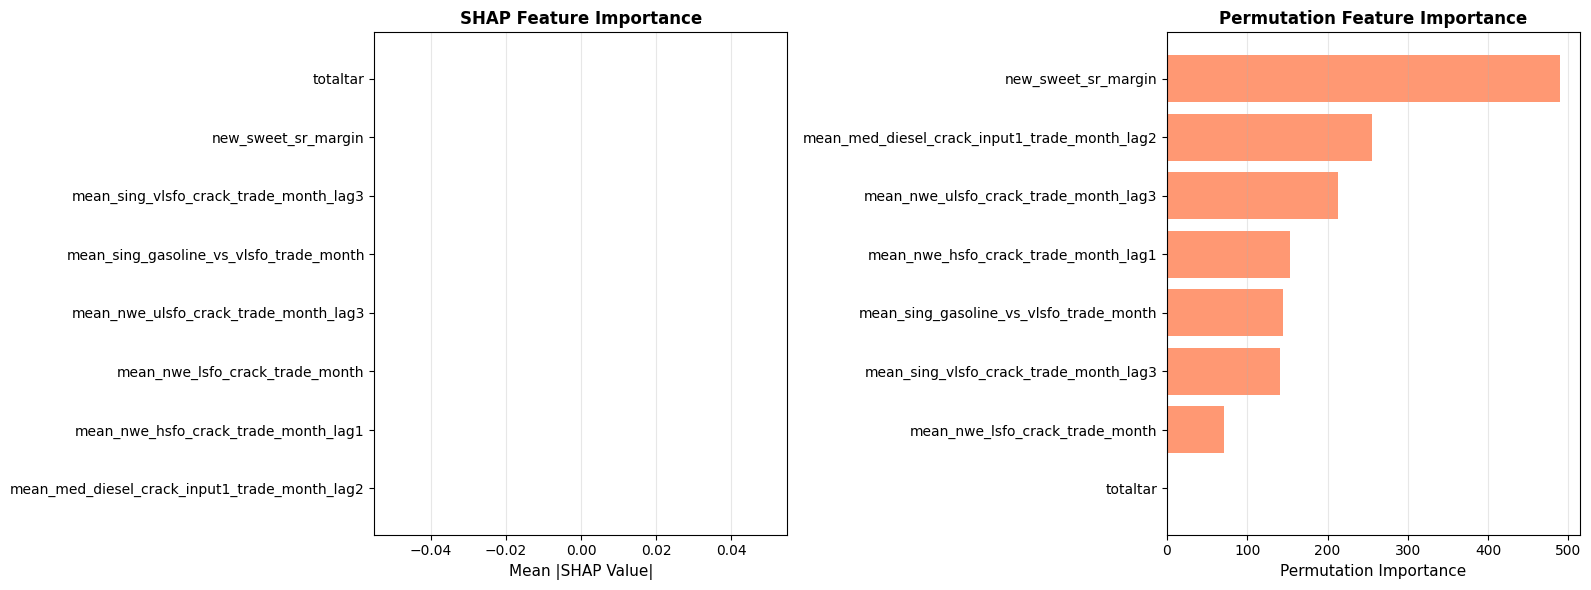


✅ Both methods identify similar top features!
   SHAP is faster for tree models, Permutation is model-agnostic.


In [ ]:
# Compare SHAP vs Permutation importance rankings

import matplotlib.pyplot as plt

# Merge importance scores
comparison = pd.merge(
    shap_importance,
    perm_importance,
    on='feature',
    how='outer'
).fillna(0)

# Normalize scores to 0-1 range for comparison
comparison['shap_norm'] = comparison['shap_importance'] / comparison['shap_importance'].max()
comparison['perm_norm'] = comparison['perm_importance'] / comparison['perm_importance'].max()

# Sort by SHAP importance
comparison = comparison.sort_values('shap_importance', ascending=False).head(15)

print("=== SHAP vs Permutation Importance Comparison (Top 15) ===")
print()
display(comparison[['feature', 'shap_importance', 'perm_importance']].reset_index(drop=True))

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# SHAP importance
comparison_shap = comparison.sort_values('shap_importance', ascending=True).tail(12)
ax1.barh(comparison_shap['feature'], comparison_shap['shap_importance'], color='skyblue', alpha=0.8)
ax1.set_xlabel('Mean |SHAP Value|', fontsize=11)
ax1.set_title('SHAP Feature Importance', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Permutation importance
comparison_perm = comparison.sort_values('perm_importance', ascending=True).tail(12)
ax2.barh(comparison_perm['feature'], comparison_perm['perm_importance'], color='coral', alpha=0.8)
ax2.set_xlabel('Permutation Importance', fontsize=11)
ax2.set_title('Permutation Feature Importance', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Both methods identify similar top features!")
print("   SHAP is faster for tree models, Permutation is model-agnostic.")

### When to Use Each Method

**Use `step_select_shap()` when:**
- ✅ You have **tree-based models** (XGBoost, LightGBM, RandomForest) → **Very fast with TreeExplainer**
- ✅ You want **interpretable importance** (explains how features affect predictions)
- ✅ You need to explain **individual predictions** later (SHAP values available per observation)
- ✅ You have the `shap` package installed

**Use `step_select_permutation()` when:**
- ✅ You have **non-tree models** (linear models, SVM, neural networks)
- ✅ You want a **simpler, model-agnostic** approach
- ✅ You can afford **longer computation** (use `n_jobs=-1` for parallel execution)
- ✅ You don't want to install additional packages (uses sklearn built-in)

**Performance Comparison:**
- **SHAP with TreeExplainer**: Very fast (O(TLD²) where T=trees, L=leaves, D=depth)
- **SHAP with KernelExplainer**: Slower (use `shap_samples` to limit computation)
- **Permutation**: Slowest (`n_repeats × n_features` model evaluations), but model-agnostic

**Both methods:**
- Require a **pre-trained model**
- Support flexible selection (`threshold`, `top_n`, `top_p`)
- Handle **categorical features** via one-hot encoding
- Work with **regression and classification**
- Store importance scores in `_scores` attribute after prep

# 27. Comprehensive Model Comparison

Compare all recipe variations including the new steps.


COMPREHENSIVE MODEL COMPARISON - All Recipe Steps


,Model,RMSE,MAE,R²
16,Rolling Windows,17.449177,13.434113,0.268390
20,EWM Features,26.448488,23.290405,-0.788131
35,Kernel PCA,27.534461,21.134374,-0.960971
11,Complex Recipe,28.524646,21.778031,-1.104546
39,EIX,31.210258,24.814437,-1.519490
7,Correlation Filter,31.212343,24.707113,-1.519827
12,Random Forest,31.668382,26.613147,-1.593998
25,Near-Zero Variance,31.858978,25.829098,-1.625316
34,ICA,32.548817,25.848433,-1.740238
37,SplitWise,32.635818,23.736492,-1.754907


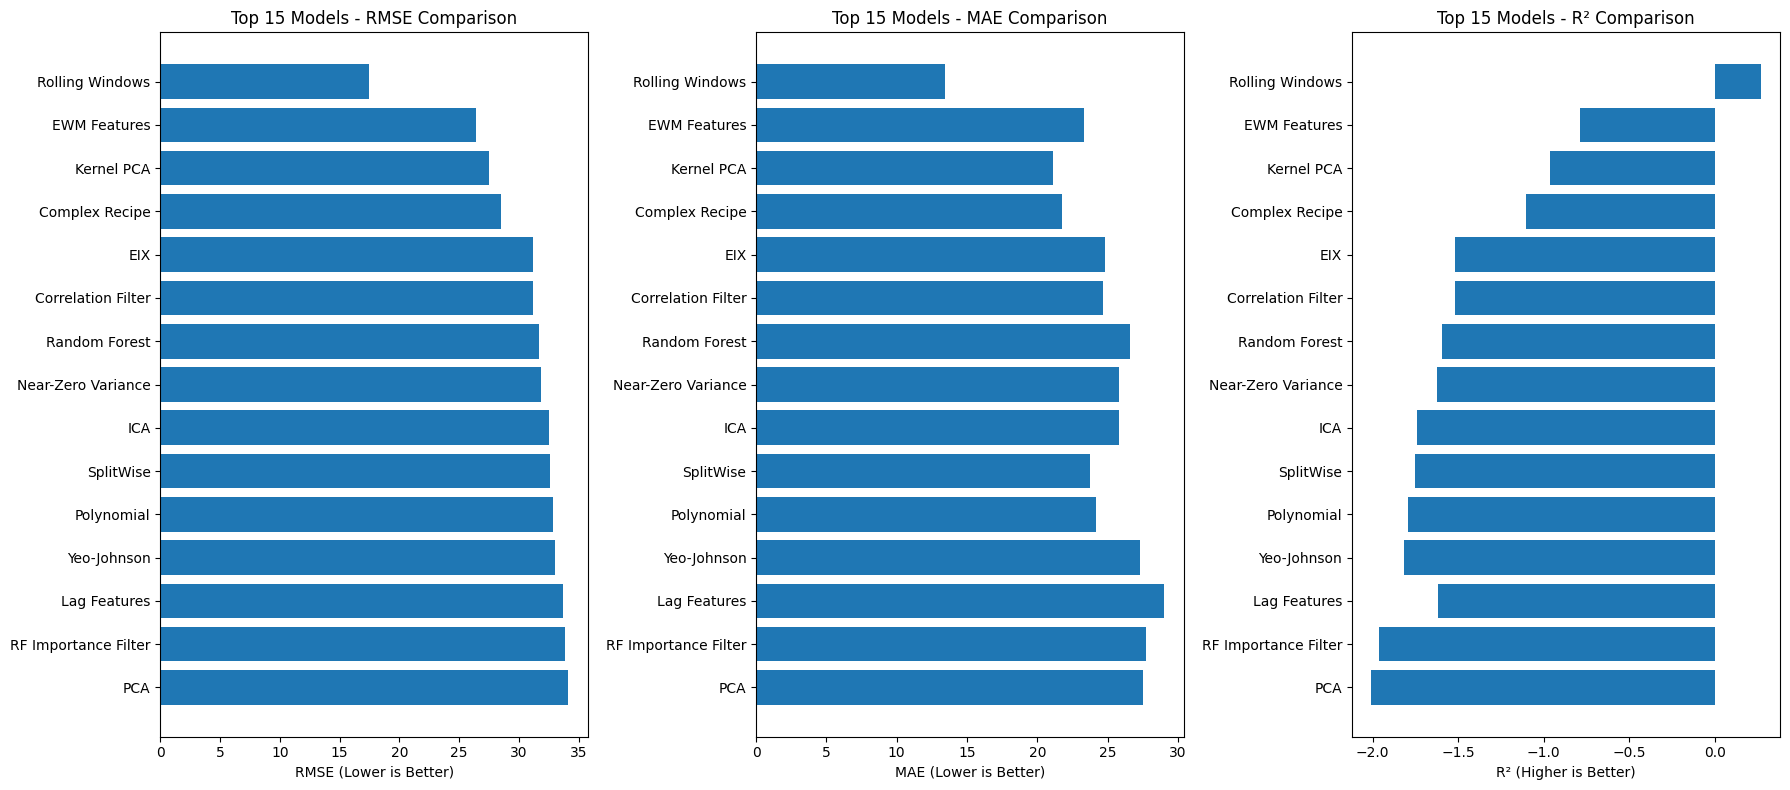


✅ Best Model Overall:
   Model: Rolling Windows
   RMSE: 17.4492
   MAE: 13.4341
   R²: 0.2684


In [ ]:
# Collect test set statistics from ALL models
all_comparison_data = []

all_models_info = [
    # Original models
    ("Baseline (No Recipe)", stats_baseline),
    ("Normalize", stats_normalize),
    ("Min-Max Scale", stats_scale),
    ("Center + Scale", stats_cs),
    ("Polynomial", stats_poly),
    ("Interactions", stats_interact),
    ("PCA", stats_pca),
    ("Correlation Filter", stats_corr),
    ("Log Transform", stats_log),
    ("Box-Cox", stats_boxcox),
    ("Imputation", stats_impute),
    ("Complex Recipe", stats_complex),
    ("Random Forest", stats_rf),
    ("XGBoost", stats_xgb),

    # Time series steps
    ("Lag Features", stats_lag),
    ("Differencing", stats_diff),
    # ("Percent Change", stats_pct),
    ("Rolling Windows", stats_rolling),
    ("Date Features", stats_date),
    ("Timeseries Signature", stats_ts_sig),
    ("Fourier Features", stats_fourier),
    ("EWM Features", stats_ewm),

    # Supervised filters
    ("ANOVA Filter", stats_anova),
    ("RF Importance Filter", stats_rf_imp),
    ("Mutual Info Filter", stats_mi),

    # Unsupervised filters
    ("Zero Variance Filter", stats_zv),
    ("Near-Zero Variance", stats_nzv),
    ("Linear Combinations", stats_lincomb),
    ("Missing Data Filter", stats_missing),

    # Discretization
    ("Discretization", stats_discretize),
    # ("Custom Cut", stats_cut),
    ("Percentile Transform", stats_percentile),

    # Other transformations
    # ("Square Root", stats_sqrt),
    ("Yeo-Johnson", stats_yj),
    ("B-Splines", stats_bs),
    ("Natural Splines", stats_ns),
    ("Ratio Features", stats_ratio),

    # Advanced reduction
    ("ICA", stats_ica),
    ("Kernel PCA", stats_kpca),
    ("PLS", stats_pls),
    ("SplitWise", stats_splitwise),
    ("SAFE", stats_safe),
    ("EIX", stats_eix),
]

for model_name, stats in all_models_info:
    test_stats = stats[stats['split'] == 'test']

    rmse_val = test_stats[test_stats['metric'] == 'rmse']['value'].values[0]
    mae_val = test_stats[test_stats['metric'] == 'mae']['value'].values[0]
    r2_val = test_stats[test_stats['metric'] == 'r_squared']['value'].values[0]

    all_comparison_data.append({
        'Model': model_name,
        'RMSE': rmse_val,
        'MAE': mae_val,
        'R²': r2_val
    })

all_comparison_df = pd.DataFrame(all_comparison_data)

# Sort by RMSE (lower is better)
all_comparison_df = all_comparison_df.sort_values('RMSE')

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON - All Recipe Steps")
print("="*80)
display(all_comparison_df)

# Plot top 15 models
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

top_15 = all_comparison_df.head(15)

# RMSE comparison
axes[0].barh(top_15['Model'], top_15['RMSE'])
axes[0].set_xlabel('RMSE (Lower is Better)')
axes[0].set_title('Top 15 Models - RMSE Comparison')
axes[0].invert_yaxis()

# MAE comparison
axes[1].barh(top_15['Model'], top_15['MAE'])
axes[1].set_xlabel('MAE (Lower is Better)')
axes[1].set_title('Top 15 Models - MAE Comparison')
axes[1].invert_yaxis()

# R² comparison
axes[2].barh(top_15['Model'], top_15['R²'])
axes[2].set_xlabel('R² (Higher is Better)')
axes[2].set_title('Top 15 Models - R² Comparison')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n✅ Best Model Overall:")
print(f"   Model: {all_comparison_df.iloc[0]['Model']}")
print(f"   RMSE: {all_comparison_df.iloc[0]['RMSE']:.4f}")
print(f"   MAE: {all_comparison_df.iloc[0]['MAE']:.4f}")
print(f"   R²: {all_comparison_df.iloc[0]['R²']:.4f}")

# 28. Complete Recipe Steps Summary

## All 51+ Recipe Steps Demonstrated

### 1. **Normalization & Scaling** (5 steps)
- `step_normalize()` - Standardize to mean=0, sd=1
- `step_center()` - Center to mean=0
- `step_scale()` - Scale to sd=1
- `step_range()` - Min-max scaling to [0,1]
- `step_percentile()` - Convert to percentile ranks

### 2. **Transformations** (7 steps)
- `step_log()` - Log transformation
- `step_sqrt()` - Square root transformation
- `step_boxcox()` - Box-Cox power transformation
- `step_yeojohnson()` - Yeo-Johnson transformation
- `step_bs()` - B-spline basis functions
- `step_ns()` - Natural spline basis functions
- `step_harmonic()` - Harmonic features

### 3. **Time Series Features** (11 steps)
- `step_lag()` - Lagged features
- `step_diff()` - Differencing
- `step_pct_change()` - Percent changes
- `step_rolling()` - Rolling window statistics
- `step_date()` - Extract date components
- `step_timeseries_signature()` - Comprehensive time features
- `step_fourier()` - Fourier features for seasonality
- `step_holiday()` - Holiday indicators
- `step_lead()` - Future/lead features
- `step_ewm()` - Exponentially weighted moving features
- `step_expanding()` - Expanding window statistics

### 4. **Feature Engineering** (5 steps)
- `step_poly()` - Polynomial features
- `step_interact()` - Interaction terms
- `step_ratio()` - Ratio features
- `step_mutate()` - Custom feature creation
- `step_pca()` - Principal components

### 5. **Supervised Feature Selection** (5 steps)
- `step_filter_anova()` - ANOVA F-test filter
- `step_filter_rf_importance()` - Random Forest importance
- `step_filter_mutual_info()` - Mutual information
- `step_filter_roc_auc()` - ROC AUC scoring
- `step_filter_chisq()` - Chi-squared test
- `step_select_shap()` - SHAP value-based selection
- `step_select_permutation()` - Permutation importance selection

### 6. **Unsupervised Filters** (5 steps)
- `step_select_corr()` - Correlation-based selection
- `step_zv()` - Zero variance filter
- `step_nzv()` - Near-zero variance filter
- `step_lincomb()` - Linear combinations filter
- `step_filter_missing()` - Missing data filter

### 7. **Imputation** (5 steps)
- `step_impute_mean()` - Mean imputation
- `step_impute_median()` - Median imputation
- `step_impute_mode()` - Mode imputation
- `step_impute_knn()` - K-nearest neighbors imputation
- `step_impute_linear()` - Linear regression imputation

### 8. **Discretization** (3 steps)
- `step_discretize()` - Quantile/width-based binning
- `step_cut()` - Custom threshold binning
- `step_percentile()` - Percentile transformation

### 9. **Advanced Dimensionality Reduction** (3 steps)
- `step_ica()` - Independent Component Analysis
- `step_kpca()` - Kernel PCA
- `step_pls()` - Partial Least Squares

### 10. **Column Operations** (2 steps)
- `step_rm()` - Remove columns
- `step_select()` - Select specific columns

### 11. **Categorical Handling** (5 steps)
- `step_dummy()` - One-hot encoding
- `step_other()` - Pool rare levels
- `step_novel()` - Handle novel levels
- `step_indicate_na()` - Missing value indicators
- `step_integer()` - Integer encoding

### 12. **Adaptive Transformations** (2 steps)
- `step_splitwise()` - Data-driven dummy encoding via decision trees
- `step_safe()` - Surrogate Assisted Feature Extraction
- `step_eix()` - Tree-based interaction detection (EIX)

## Key Takeaways

### Best Practices by Model Type:
- **Linear Models**: Normalize, polynomial, interactions, PCA
- **Tree Models**: Minimal preprocessing, imputation only
- **Time Series**: Lag, diff, rolling, Fourier, date features
- **High-Dimensional**: PCA, ICA, supervised filters

### Recipe Order Matters:
1. **Filter**: Remove bad features (zv, nzv, missing)
2. **Impute**: Handle missing values
3. **Transform**: Log, Box-Cox, Yeo-Johnson
4. **Scale**: Normalize, center, range
5. **Engineer**: Polynomial, interactions, PCA
6. **Select**: Final feature selection

### Time Series Best Practices:
- Use `step_lag()` for autoregressive features
- Use `step_diff()` to achieve stationarity
- Use `step_fourier()` for seasonal patterns
- Use `step_rolling()` for trend capture
- Use `step_date()` for calendar effects

### Feature Selection Strategy:
- **Unsupervised First**: Remove zv, nzv, lincomb
- **Supervised Second**: ANOVA, RF importance, MI
- **Final Validation**: Cross-validation with best subset

## Recipe Benefits Summary:

✓ **Consistency**: Same transformations on train/test
✓ **No Leakage**: Statistics learned from training only
✓ **Reproducibility**: Exact same preprocessing pipeline
✓ **Flexibility**: Easy to add/remove/reorder steps
✓ **Composability**: Mix and match for optimal performance
✓ **Workflow Integration**: Seamless with py-tidymodels ecosystem